# Starbucks Capstone Notebook
Starbucks has always been my go-to coffee shop in Indonesia. The place is nice and cozy, the service is great, and the coffee is, of course, great. Therefore, when I was given a chance to explore Starbucks' data and create something out of it, I was really excited. The data itself is described below.

## Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - 
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

## Problem Statement
The problem here is in how to create a great recommender system for Starbucks users. It has to consider whether a user likes being given offers or not, and which offer to give to a certain user should he/she likes to recieve and view offers. My strategy in solving the problems will be outlined in the Objectives section below.

## Objectives
My primary objective in this notebook is to create a recommendation engine on promotion. However, I also have several objectives to be completed. They will be described below.  

#### Create an exploratory data analysis to describe Starbucks' user demographics
I want to understand Starbucks' user demographics prior to creating the recommendation engine. This will be in the form of data visualization on demographics attribute such as age, income, gender, or purchase behavior attribute such as amount of transaction, number of transaction done by gender, and number of promotion which is completed by users.

#### Engineer feature which is going to be used for the recommendation engine
This will be predecated by data cleaning. Then, I will create ratios as features because based on my experience in this industry, ratio data is always preferable.

#### Divide the user in this data into clusters
I will use KMeans clustering to cluster the user data. It will be interesting to look at the characteristics of each cluster. I will describe some if the result is too many.

#### Create recommendation engine based on clusters
My idea is to create cluster-promotion matrix where the index will be the clusters, and the columns will be the number of transactions on each promo (the count, not the amount). Then, I will map the user id to the cluster and create recommendations based on that.

## Measurements the Effectiveness of the Recommendation Engine
Although it's not possible to directly measure the effectiveness of the engine, Starbucks can always do an A/B testing for a certain period of time. Starbucks has to assign cookies in the app to divide users into 2 groups, control and experiment group. The control group will not be given this recommendation engine, and the experiment group will. The metrics to watch are:

**Invariant Metrics**
1. The amount of user in control and experiment group. This should be at least similar, close to 50:50.
2. The number of cookies assigned to each group.

**Evaluation Metrics**
1. The average transaction amount. If the experiment group has higher average transaction amount, the recommendation engine can be considered useful.
2. Percentage of offer completed. If the experiment group has higher percentage of offer completed, the recommendation engine can be considered useful.
3. Ratio of transaction from offer and offer received. The higher it is for the experiment group, the better.
4. Ratio of transaction not from offer and offer received. The lower it is for the experiment group, the better.

## Initial look at the data
Before starting to do anything, I will look at each data set and see what kind of data cleaning should I do to create the exploratory data analysis, clustering, and recommendation engine.

In [1]:
import pandas as pd
import numpy as np
import math
import json

#import machine learning libraries
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib

#import clustering libraries
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

import time
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

d:\anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


The portfolio dataset is quite simple. It contains the channel of promotion, difficulty, duration of promotion (in days), offer id, offer type, and reward for completing a promotion. There are not many things to be cleaned here except:
1. Divide channels column into 4 dummy columns: web, email, mobile, and social.
2. Create a dictionary with offer id as keys and aliases for the purpose of simplifying the merging of 3 data sets later.

Next, I will take a look at profile dataset. 

In [5]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [6]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [9]:
profile.duplicated().value_counts()

False    17000
dtype: int64

There are a couple of things that has to be done to clean this data set. What I detected are:
1. There are a couple of people with the age of 118
2. There are a couple of people with missing data on gender and income columns. This is a problem since without the complete data, I will not be able to build good user clusters. I will impute the missing values using machine learning.

I will take a look at the users with the age 118. 

In [15]:
profile[profile['age'] == 118].head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN


In [16]:
profile[profile['age'] == 118].isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

Judging from the number of null values and the first few lines of the sliced dataframe, the people with age 118 has no gender and income recorded. This might be because of sign up issues or the users deliberately didn't fill the columns. This makes creating the machine learning prediction for the null values a bit trickier than I thought.

In [19]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [20]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [21]:
transcript.sample(25)

,event,person,time,value
4671,offer received,5a5bffb68f8d4527b532dbfb19da7d3f,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
133519,transaction,9bdcc054e9ad403589ef9216baff243d,354,{'amount': 10.28}
277695,offer viewed,06ccdaa9fbaa4c21b4321c83bcd2a000,612,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
282742,transaction,cc35fd7b202a43d19eddbec7b76e01ca,624,{'amount': 15.22}
159693,offer received,22983eb87bcd4795b330c2d20d910653,408,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
229367,offer viewed,c52343cf47e84dadbedd0b9632d626ec,528,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
298648,transaction,7b221e9580134a8aac4f31f7562f079d,678,{'amount': 19.68}
48113,transaction,b914d62e1a024a63817296ee8edb84f5,132,{'amount': 3.55}
269022,transaction,e0570660882b49db860b43f704e5590b,594,{'amount': 16.13}
61729,offer received,325da16cf16c4d72972f28281f752201,168,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}


There are no missing values in the dataframe which is great. However, there are a lot of cleaning to do:
1. Create dummy variables for event with 1 or 0 as the value.
2. The problematic one is the column value. Some has only offer id (which correspond to the event offer received and offer viewed), some has reward and offer id (which correspond to offer completed) and some has amount (which correspond to transaction). 
3. The transactions happened are not really clear. They don't show the transactions happened because of certain offer, or even not because of any offer.
4. The column time is in hours. It will be better if I create duration in hour in the **portfolio dataframe**.

# Data Preprocessing
## Cleaning Portfolio
First, I will create dummy variables for channels using pd.get_dummies and stack.

In [23]:
#create dummy variables
portfolio = pd.concat([portfolio, pd.get_dummies(portfolio['channels'].apply(pd.Series).stack()).sum(level=0)], axis = 1)
portfolio.drop('channels', axis = 1, inplace = True)

In [24]:
portfolio

,difficulty,duration,id,offer_type,reward,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1


Then, I will create a dictionary with id as keys and aliases as values.

In [25]:
portfolio_offer_id = portfolio.id.tolist()
portfolio_offer_name = ['bogo1', 'bogo2', 'informational1', 'bogo3', 'discount1', 'discount2', 'discount3', 'informational2', 'bogo4', 'discount4']
offer_name_dict = dict(zip(portfolio_offer_id, portfolio_offer_name))

In [26]:
offer_name_dict

{'0b1e1539f2cc45b7b9fa7c272da2e1d7': 'discount1',
 '2298d6c36e964ae4a3e7e9706d1fb8c2': 'discount2',
 '2906b810c7d4411798c6938adc9daaa5': 'discount4',
 '3f207df678b143eea3cee63160fa8bed': 'informational1',
 '4d5c57ea9a6940dd891ad53e9dbe8da0': 'bogo2',
 '5a8bc65990b245e5a138643cd4eb9837': 'informational2',
 '9b98b8c7a33c4b65b9aebfe6a799e6d9': 'bogo3',
 'ae264e3637204a6fb9bb56bc8210ddfd': 'bogo1',
 'f19421c1d4aa40978ebb69ca19b0e20d': 'bogo4',
 'fafdcd668e3743c1bb461111dcafc2a4': 'discount3'}

## Cleaning Transcript and Profile
I decided to clean both transcript and profile at the same time by joining the two dataframes.

In [27]:
#merging two dataframes
df = pd.merge(profile,transcript, left_on = 'id', right_on = 'person') 
df.drop(['person'], axis = 1, inplace = True)

In [28]:
#creating dummies for event column, dropping the event column
value_dummies = pd.get_dummies(df['event'])
value_dummies.columns = ['offer_completed', 'offer_received', 'offer_viewed', 'transaction']
df = pd.concat([df, value_dummies], axis = 1)
df.drop('event', axis = 1, inplace = True)

In [30]:
df.head()

,age,became_member_on,gender,id,income,time,value,offer_completed,offer_received,offer_viewed,transaction
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,168,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,1,0,0
1,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,216,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0,1,0
2,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,336,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,0
3,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,348,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,1,0
4,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,360,{'amount': 0.35000000000000003},0,0,0,1


**Cleaning value**  
To clean the value column, I will create functions to map the series, and create 4 new columns out of the value column:
1. Offer id column. It will contain the offer id.
2. Transaction amount. It will contain the amount of transaction.
3. Transaction. It will contain 1 if there is a transaction in the row, and 0 if there isn't one.
4. Reward achieved. It will contain the amount of reward achieved when offer was completed

In [29]:
def offer_new(val):
    '''
    INPUT: val - values in Series
    OUTPUT: Series with the value of np.nan if 'amount' in val or val if everything else in val
    '''
    if 'amount' in val:
        return np.nan
    else:
        return val

def transaction_new(val):
    '''
    INPUT: val - values in Series
    OUTPUT: Series with the value of val if 'amount' in val or np.nan if everything else in val
    '''
    if 'amount' in val:
        return val
    else:
        return np.nan

def map_transaction(val):
    '''
    INPUT: val - values in Series
    OUTPUT: Series with value of 1 if val is not np.nan and 0 if it is.
    '''
    if val is not np.nan:
        return 1
    else:
        return 0

def reward_new(val):
    '''
    INPUT: val - values in Series
    OUTPUT: Series with the value of val if 'reward' in val or np.nan if everything else in val
    '''
    if 'reward' in val:
        return val
    else:
        return np.nan


In [31]:
df['offer_id'] = df['value'].apply(offer_new)
df['transaction_amount'] = df['value'].apply(transaction_new)
df.drop('transaction', axis = 1, inplace = True)
df['transaction'] = df['transaction_amount'].apply(map_transaction)

In [32]:
df.head()

,age,became_member_on,gender,id,income,time,value,offer_completed,offer_received,offer_viewed,offer_id,transaction_amount,transaction
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,168,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,1,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,0
1,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,216,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0,1,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,0
2,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,336,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,0
3,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,348,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,1,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,0
4,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,360,{'amount': 0.35000000000000003},0,0,0,NaN,{'amount': 0.35000000000000003},1


In [33]:
#converting value and offer_id to string for string slicing
df['value'] = df['value'].astype('str')
df['offer_id'] = df['offer_id'].astype('str')

In [34]:
def strip_reward(val):
    '''
    This function strips reward from the offer_id
    '''
    if 'reward' in val:
        val = val[14:]
        return val
    else:
        return val

def strip_offer(val):
    '''
    This function strips only offer from offer_id
    '''
    val = val[:32]
    return val

def get_reward(val):
    '''
    This function gets the reward amount of the reward_achieved column to be created
    '''
    if val != 'nan':
        val = val[:12]
        return val
    else:
        return val

In [35]:
def id_mapper(df):
    '''
    This function creates a unique user_id for each person
    '''
    coded_dict = dict()
    cter = 1
    id_encoded = []
    
    for val in df['id']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        id_encoded.append(coded_dict[val])
    return id_encoded


In [36]:
df['offer_id'] = df['offer_id'].apply(strip_reward)

In [38]:
df.head(25)

,age,became_member_on,gender,id,income,time,value,offer_completed,offer_received,offer_viewed,offer_id,transaction_amount,transaction
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,168,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,1,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,0
1,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,216,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0,1,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,0
2,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,336,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,0
3,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,348,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,1,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,0
4,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,360,{'amount': 0.35000000000000003},0,0,0,nan,{'amount': 0.35000000000000003},1
5,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,408,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,1,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,0
6,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,408,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0,1,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,0
7,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,414,{'amount': 0.74},0,0,0,nan,{'amount': 0.74},1
8,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,444,{'amount': 1.8900000000000001},0,0,0,nan,{'amount': 1.8900000000000001},1
9,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,504,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0,1,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},NaN,0


In [39]:
#cleaning offer_id
df['offer_id'] = df['offer_id'].str.replace("{'offer id': '", '')
df['offer_id'] = df['offer_id'].str.replace("'offer_id': '", '')
df['offer_id'] = df['offer_id'].str.replace("'}", '')

In [40]:
#cleaning transaction_amount
df['transaction_amount'] = df['transaction_amount'].astype('str')
df['transaction_amount'] = df['transaction_amount'].str.replace("{'amount': ", '')
df['transaction_amount'] = df['transaction_amount'].str.replace("}", '')

In [41]:
#creating reward_achieved column
df['reward_achieved'] = df['value'].apply(reward_new)
df['reward_achieved'] = df['reward_achieved'].astype('str')

In [42]:
#cleaning reward_achieved column
df['reward_achieved'] = df['reward_achieved'].str.replace("{'offer id': '", '')
df['reward_achieved'] = df['reward_achieved'].str.replace("'offer_id': '", '')
df['reward_achieved'] = df.reward_achieved.apply(get_reward)
df['reward_achieved'] = df['reward_achieved'].str.replace("{'reward': ", '')
df['reward_achieved'] = df['reward_achieved'].str.replace('nan', '0')

In [43]:
#cleaning offer_id
df['offer_id'] = df['offer_id'].apply(strip_offer)

In [44]:
#create user_id column
user_id_encoded = id_mapper(df)
del df['id']
df['user_id'] = user_id_encoded

In [45]:
df.head(100)

,age,became_member_on,gender,income,time,value,offer_completed,offer_received,offer_viewed,offer_id,transaction_amount,transaction,reward_achieved,user_id
0,118,20170212,None,NaN,168,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,1,0,2906b810c7d4411798c6938adc9daaa5,nan,0,0,1
1,118,20170212,None,NaN,216,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0,1,2906b810c7d4411798c6938adc9daaa5,nan,0,0,1
2,118,20170212,None,NaN,336,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,nan,0,0,1
3,118,20170212,None,NaN,348,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,1,0b1e1539f2cc45b7b9fa7c272da2e1d7,nan,0,0,1
4,118,20170212,None,NaN,360,{'amount': 0.35000000000000003},0,0,0,nan,0.35000000000000003,1,0,1
5,118,20170212,None,NaN,408,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,1,0,fafdcd668e3743c1bb461111dcafc2a4,nan,0,0,1
6,118,20170212,None,NaN,408,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0,1,fafdcd668e3743c1bb461111dcafc2a4,nan,0,0,1
7,118,20170212,None,NaN,414,{'amount': 0.74},0,0,0,nan,0.74,1,0,1
8,118,20170212,None,NaN,444,{'amount': 1.8900000000000001},0,0,0,nan,1.8900000000000001,1,0,1
9,118,20170212,None,NaN,504,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0,1,0,2298d6c36e964ae4a3e7e9706d1fb8c2,nan,0,0,1


For **portfolio** dataframe, I will also create duration_hours column which convert duration days to hours

In [46]:
portfolio['duration_hours'] = portfolio['duration'] * 24
portfolio

,difficulty,duration,id,offer_type,reward,email,mobile,social,web,duration_hours
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,168
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1,120
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1,96
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,168
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1,240
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1,168
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1,240
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0,72
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1,120
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1,168


**Creating transaction_from_offer and transaction_offer_viewed columns**  
One of the main problem of this data is that it doesn't tell us if a transaction happens because of an offer or not. And if it is, which offer causes the transaction? To answer the problem, I will create these two columns based on these mechanism:
1. If a transaction occured, I have to check whether it is caused by an offer or not.
2. I assume that if a user had viewed an offer and then did a transaction or even several transactions (to achieve the promo goal), then these transactions are caused by the offer.
3. To check whether a transaction is caused by offer viewed, I need to check if the offer is viewed within the time of transaction and the maximum duration hours of an offer. Then, I will get the first occurence of offer viewed and assign it as offer causing the transaction. The logic is, if a user views a transaction first, they will try to complete the offer if the offer is still within the timeframe. Although this user might receive another offer, the user will try to complete the first offer viewed.

In [47]:
#creating list of unique users and empty list
un_user_list = df.user_id.unique().tolist()

test_list = []
trans_list = []
offer_list = []

In [48]:
#for each user
for user in un_user_list:
    start = time.clock()
    df_id = df[df['user_id'] == user]
    list_transaction = df_id['transaction'].tolist()
    
    #for each transaction
    for i in list_transaction:
        if i == 0:
            test_list.append(i)
            trans_list.append(i)
            offer_list.append(str(i))
        if i == 1:
            idx = len(test_list)
            #get time of purchase, check which offer is viewed
            #the offer viewed is the one causing transaction
            test_time = df_id.loc[idx].time
            delta_time = test_time - portfolio.duration_hours.max()
            slice_df = df_id[(df_id['time'] >= delta_time) & (df_id['time'] < test_time)]
            slice_df.reset_index(inplace = True)
            list_offer_viewed = slice_df['offer_viewed'].tolist()
            try:
                offer_id_purchased = slice_df.loc[list_offer_viewed.index(1)].offer_id
                trans_list.append(1)
                offer_list.append(offer_id_purchased)
                test_list.append(i)
            except:
                trans_list.append(0)
                offer_list.append(str(0))
                test_list.append(i)
    print("Calculating user {}... Time elapsed: {}".format(user, time.clock()-start))

Calculating user 1... Time elapsed: 0.12391825339940847
Calculating user 2... Time elapsed: 0.007140511164292054
Calculating user 3... Time elapsed: 0.016029692757450975
Calculating user 4... Time elapsed: 0.021191456532560576
Calculating user 5... Time elapsed: 0.007033598078643538
Calculating user 6... Time elapsed: 0.007341935417653822
Calculating user 7... Time elapsed: 0.0012470342310041127
Calculating user 8... Time elapsed: 0.006054701866445883
Calculating user 9... Time elapsed: 0.008228031071508601
Calculating user 10... Time elapsed: 0.01385037641959197
Calculating user 11... Time elapsed: 0.019435516013869614
Calculating user 12... Time elapsed: 0.018781635582043377
Calculating user 13... Time elapsed: 0.009858241801476986
Calculating user 14... Time elapsed: 0.0143746781916122
Calculating user 15... Time elapsed: 0.03826119978720022
Calculating user 16... Time elapsed: 0.020589749686530823
Calculating user 17... Time elapsed: 0.021193594794273574
Calculating user 18... Time

Calculating user 151... Time elapsed: 0.017224125750316066
Calculating user 152... Time elapsed: 0.026837322759486693
Calculating user 153... Time elapsed: 0.015491706110467351
Calculating user 154... Time elapsed: 0.006086348139797693
Calculating user 155... Time elapsed: 0.008170725657601352
Calculating user 156... Time elapsed: 0.011319102203778186
Calculating user 157... Time elapsed: 0.0229422652231408
Calculating user 158... Time elapsed: 0.014526922425575961
Calculating user 159... Time elapsed: 0.00757072942094128
Calculating user 160... Time elapsed: 0.007364173339468927
Calculating user 161... Time elapsed: 0.020459743374382278
Calculating user 162... Time elapsed: 0.012220165689623474
Calculating user 163... Time elapsed: 0.005511583391351493
Calculating user 164... Time elapsed: 0.005350786110536188
Calculating user 165... Time elapsed: 0.01404880710655565
Calculating user 166... Time elapsed: 0.025549661555936076
Calculating user 167... Time elapsed: 0.06629509380126519
Ca

Calculating user 297... Time elapsed: 0.030871794959518084
Calculating user 298... Time elapsed: 0.03277997971217328
Calculating user 299... Time elapsed: 0.0012709827621897318
Calculating user 300... Time elapsed: 0.019863168356463845
Calculating user 301... Time elapsed: 0.016648078044841697
Calculating user 302... Time elapsed: 0.016428264740747878
Calculating user 303... Time elapsed: 0.016358557408906016
Calculating user 304... Time elapsed: 0.018441224317339078
Calculating user 305... Time elapsed: 0.017945575252271695
Calculating user 306... Time elapsed: 0.02495180358098903
Calculating user 307... Time elapsed: 0.015601612762514705
Calculating user 308... Time elapsed: 0.027766611299943733
Calculating user 309... Time elapsed: 0.04654910218667219
Calculating user 310... Time elapsed: 0.029903590055885942
Calculating user 311... Time elapsed: 0.003635472564391229
Calculating user 312... Time elapsed: 0.024847456409396784
Calculating user 313... Time elapsed: 0.023670129510235505

Calculating user 445... Time elapsed: 0.016911511887879982
Calculating user 446... Time elapsed: 0.017479006546503584
Calculating user 447... Time elapsed: 0.03090900071332392
Calculating user 448... Time elapsed: 0.005721560691565486
Calculating user 449... Time elapsed: 0.00582419725378891
Calculating user 450... Time elapsed: 0.016632682560508982
Calculating user 451... Time elapsed: 0.00991169834430039
Calculating user 452... Time elapsed: 0.030041294110201733
Calculating user 453... Time elapsed: 0.0032997654754556294
Calculating user 454... Time elapsed: 0.013703264013740224
Calculating user 455... Time elapsed: 0.020149695426001202
Calculating user 456... Time elapsed: 0.018922760855099696
Calculating user 457... Time elapsed: 0.017734742647373736
Calculating user 458... Time elapsed: 0.028882783914113475
Calculating user 459... Time elapsed: 0.02261468352871354
Calculating user 460... Time elapsed: 0.024588299089785437
Calculating user 461... Time elapsed: 0.011724944276899407


Calculating user 585... Time elapsed: 0.03354889862415611
Calculating user 586... Time elapsed: 0.03155304514126911
Calculating user 587... Time elapsed: 0.016888418661379134
Calculating user 588... Time elapsed: 0.05968487154178881
Calculating user 589... Time elapsed: 0.04943575549918222
Calculating user 590... Time elapsed: 0.039190488327657036
Calculating user 591... Time elapsed: 0.05773563216424549
Calculating user 592... Time elapsed: 0.008824178437084385
Calculating user 593... Time elapsed: 0.04199118351930409
Calculating user 594... Time elapsed: 0.007989401064341095
Calculating user 595... Time elapsed: 0.010019466734636495
Calculating user 596... Time elapsed: 0.012465638134271373
Calculating user 597... Time elapsed: 0.015541741434551781
Calculating user 598... Time elapsed: 0.03264441391957007
Calculating user 599... Time elapsed: 0.028339665439020223
Calculating user 600... Time elapsed: 0.03005027480939404
Calculating user 601... Time elapsed: 0.005464113981323848
Calcu

Calculating user 732... Time elapsed: 0.016296975471572495
Calculating user 733... Time elapsed: 0.027608379933184324
Calculating user 734... Time elapsed: 0.005574020633371646
Calculating user 735... Time elapsed: 0.0191344487646834
Calculating user 736... Time elapsed: 0.009921106695838233
Calculating user 737... Time elapsed: 0.046682102065219055
Calculating user 738... Time elapsed: 0.007820050736674133
Calculating user 739... Time elapsed: 0.02524645604503739
Calculating user 740... Time elapsed: 0.008039864040767952
Calculating user 741... Time elapsed: 0.05267992617009831
Calculating user 742... Time elapsed: 0.012821872535653256
Calculating user 743... Time elapsed: 0.044506206946099525
Calculating user 744... Time elapsed: 0.012117529127401383
Calculating user 745... Time elapsed: 0.010139637042904326
Calculating user 746... Time elapsed: 0.00569461859398146
Calculating user 747... Time elapsed: 0.005420065790037398
Calculating user 748... Time elapsed: 0.028469244098825897
Ca

Calculating user 874... Time elapsed: 0.043351973273438205
Calculating user 875... Time elapsed: 0.028279366458711763
Calculating user 876... Time elapsed: 0.029425902389206726
Calculating user 877... Time elapsed: 0.00903714930369759
Calculating user 878... Time elapsed: 0.023457158643623188
Calculating user 879... Time elapsed: 0.013955578895870957
Calculating user 880... Time elapsed: 0.013607897541341174
Calculating user 881... Time elapsed: 0.005213082056222618
Calculating user 882... Time elapsed: 0.03176088417977141
Calculating user 883... Time elapsed: 0.003179595167189575
Calculating user 884... Time elapsed: 0.02141982288350519
Calculating user 885... Time elapsed: 0.015815866586152083
Calculating user 886... Time elapsed: 0.0477751814528915
Calculating user 887... Time elapsed: 0.02011591089093656
Calculating user 888... Time elapsed: 0.027418929945415726
Calculating user 889... Time elapsed: 0.022818673696132663
Calculating user 890... Time elapsed: 0.02035368559341677
Calc

Calculating user 1023... Time elapsed: 0.03725792739147593
Calculating user 1024... Time elapsed: 0.008917406647771742
Calculating user 1025... Time elapsed: 0.02797273972907277
Calculating user 1026... Time elapsed: 0.03341803700732271
Calculating user 1027... Time elapsed: 0.005364898637843396
Calculating user 1028... Time elapsed: 0.01413904175084113
Calculating user 1029... Time elapsed: 0.0153775229349975
Calculating user 1030... Time elapsed: 0.01466933065565712
Calculating user 1031... Time elapsed: 0.010814044787171184
Calculating user 1032... Time elapsed: 0.012540477294226804
Calculating user 1033... Time elapsed: 0.021634076707144345
Calculating user 1034... Time elapsed: 0.014015022571491897
Calculating user 1035... Time elapsed: 0.0033382541862891912
Calculating user 1036... Time elapsed: 0.007731099049415491
Calculating user 1037... Time elapsed: 0.017984491615450793
Calculating user 1038... Time elapsed: 0.0010960729540663294
Calculating user 1039... Time elapsed: 0.0286

Calculating user 1168... Time elapsed: 0.03560376813032207
Calculating user 1169... Time elapsed: 0.014766407737429432
Calculating user 1170... Time elapsed: 0.0035696141036325457
Calculating user 1171... Time elapsed: 0.04387627504545932
Calculating user 1172... Time elapsed: 0.016794335146009587
Calculating user 1173... Time elapsed: 0.011255809657075844
Calculating user 1174... Time elapsed: 0.009810344739104693
Calculating user 1175... Time elapsed: 0.017986202224818726
Calculating user 1176... Time elapsed: 0.015192349470652289
Calculating user 1177... Time elapsed: 0.015337323614790677
Calculating user 1178... Time elapsed: 0.021150401907672034
Calculating user 1179... Time elapsed: 0.01660873402932239
Calculating user 1180... Time elapsed: 0.03098597813499282
Calculating user 1181... Time elapsed: 0.0014095421211877124
Calculating user 1182... Time elapsed: 0.031339646622317474
Calculating user 1183... Time elapsed: 0.03733447716079752
Calculating user 1184... Time elapsed: 0.01

Calculating user 1308... Time elapsed: 0.00973807149320649
Calculating user 1309... Time elapsed: 0.01866873536360103
Calculating user 1310... Time elapsed: 0.015070896205354956
Calculating user 1311... Time elapsed: 0.039728047322299176
Calculating user 1312... Time elapsed: 0.01761542764378987
Calculating user 1313... Time elapsed: 0.02108839231799564
Calculating user 1314... Time elapsed: 0.01851563582495075
Calculating user 1315... Time elapsed: 0.003008534230147575
Calculating user 1316... Time elapsed: 0.007962886619100829
Calculating user 1317... Time elapsed: 0.016568107056777137
Calculating user 1318... Time elapsed: 0.0033048973035647577
Calculating user 1319... Time elapsed: 0.02491930200294945
Calculating user 1320... Time elapsed: 0.0363748253040157
Calculating user 1321... Time elapsed: 0.016312798608247192
Calculating user 1322... Time elapsed: 0.045245617846443764
Calculating user 1323... Time elapsed: 0.016743872169584506
Calculating user 1324... Time elapsed: 0.020046

Calculating user 1445... Time elapsed: 0.038237678908359385
Calculating user 1446... Time elapsed: 0.022310622713131778
Calculating user 1447... Time elapsed: 0.02398787520078116
Calculating user 1448... Time elapsed: 0.010317540417421611
Calculating user 1449... Time elapsed: 0.04397035856083065
Calculating user 1450... Time elapsed: 0.02773753094064446
Calculating user 1451... Time elapsed: 0.029283921811469327
Calculating user 1452... Time elapsed: 0.044480975457886984
Calculating user 1453... Time elapsed: 0.03185240178108728
Calculating user 1454... Time elapsed: 0.025392713146207058
Calculating user 1455... Time elapsed: 0.01851007634449431
Calculating user 1456... Time elapsed: 0.02826183271266558
Calculating user 1457... Time elapsed: 0.009253969041388643
Calculating user 1458... Time elapsed: 0.013729350806638507
Calculating user 1459... Time elapsed: 0.0029058976679259274
Calculating user 1460... Time elapsed: 0.010977407982046827
Calculating user 1461... Time elapsed: 0.0178

Calculating user 1588... Time elapsed: 0.02970644232594921
Calculating user 1589... Time elapsed: 0.022690805645698475
Calculating user 1590... Time elapsed: 0.016365827498731278
Calculating user 1591... Time elapsed: 0.04444804622750809
Calculating user 1592... Time elapsed: 0.018920622593388003
Calculating user 1593... Time elapsed: 0.005519281133516074
Calculating user 1594... Time elapsed: 0.015898403488275648
Calculating user 1595... Time elapsed: 0.04618431473843998
Calculating user 1596... Time elapsed: 0.013223438085347539
Calculating user 1597... Time elapsed: 0.02078646976412557
Calculating user 1598... Time elapsed: 0.02744929326173917
Calculating user 1599... Time elapsed: 0.023987875200784714
Calculating user 1600... Time elapsed: 0.006194116530132021
Calculating user 1601... Time elapsed: 0.027011377262926572
Calculating user 1602... Time elapsed: 0.015764120652704605
Calculating user 1603... Time elapsed: 0.033788811588351564
Calculating user 1604... Time elapsed: 0.0119

Calculating user 1727... Time elapsed: 0.0334090563081304
Calculating user 1728... Time elapsed: 0.012762428860035868
Calculating user 1729... Time elapsed: 0.00772553956895905
Calculating user 1730... Time elapsed: 0.010636141412653899
Calculating user 1731... Time elapsed: 0.010758449982638751
Calculating user 1732... Time elapsed: 0.041725183762217455
Calculating user 1733... Time elapsed: 0.009859097106158288
Calculating user 1734... Time elapsed: 0.027086216422880227
Calculating user 1735... Time elapsed: 0.029460969881299093
Calculating user 1736... Time elapsed: 0.024474971218999997
Calculating user 1737... Time elapsed: 0.009835148574978803
Calculating user 1738... Time elapsed: 0.028192125380819277
Calculating user 1739... Time elapsed: 0.03420406201301063
Calculating user 1740... Time elapsed: 0.015811162410386714
Calculating user 1741... Time elapsed: 0.009485756611077534
Calculating user 1742... Time elapsed: 0.017041090547685656
Calculating user 1743... Time elapsed: 0.016

Calculating user 1869... Time elapsed: 0.013298704897650282
Calculating user 1870... Time elapsed: 0.006852273485385751
Calculating user 1871... Time elapsed: 0.026100050120852814
Calculating user 1872... Time elapsed: 0.017765533616042717
Calculating user 1873... Time elapsed: 0.01903095689777956
Calculating user 1874... Time elapsed: 0.012268062751992659
Calculating user 1875... Time elapsed: 0.007586980209957517
Calculating user 1876... Time elapsed: 0.012267635099647123
Calculating user 1877... Time elapsed: 0.011692870351204476
Calculating user 1878... Time elapsed: 0.007932523302777383
Calculating user 1879... Time elapsed: 0.022864004844450392
Calculating user 1880... Time elapsed: 0.009511415751632057
Calculating user 1881... Time elapsed: 0.041767093691781554
Calculating user 1882... Time elapsed: 0.008810921214461587
Calculating user 1883... Time elapsed: 0.025693352743047626
Calculating user 1884... Time elapsed: 0.020564090545974523
Calculating user 1885... Time elapsed: 0.

Calculating user 2012... Time elapsed: 0.028229331134625113
Calculating user 2013... Time elapsed: 0.039461619912863455
Calculating user 2014... Time elapsed: 0.015371108149849988
Calculating user 2015... Time elapsed: 0.03303272224664511
Calculating user 2016... Time elapsed: 0.014174964547621016
Calculating user 2017... Time elapsed: 0.007732809658783424
Calculating user 2018... Time elapsed: 0.011587240222588946
Calculating user 2019... Time elapsed: 0.018939866948798567
Calculating user 2020... Time elapsed: 0.03635087677282911
Calculating user 2021... Time elapsed: 0.029443863787598445
Calculating user 2022... Time elapsed: 0.01817052038447997
Calculating user 2023... Time elapsed: 0.011553028035180546
Calculating user 2024... Time elapsed: 0.012551168602790597
Calculating user 2025... Time elapsed: 0.005568461152918758
Calculating user 2026... Time elapsed: 0.009775704899361415
Calculating user 2027... Time elapsed: 0.029024336839512443
Calculating user 2028... Time elapsed: 0.01

Calculating user 2151... Time elapsed: 0.009824884918756993
Calculating user 2152... Time elapsed: 0.017175801035605787
Calculating user 2153... Time elapsed: 0.008779274941112192
Calculating user 2154... Time elapsed: 0.02518401880301724
Calculating user 2155... Time elapsed: 0.01771164942086756
Calculating user 2156... Time elapsed: 0.00537216872766777
Calculating user 2157... Time elapsed: 0.014247665445857649
Calculating user 2158... Time elapsed: 0.015686287926349962
Calculating user 2159... Time elapsed: 0.04201427674580316
Calculating user 2160... Time elapsed: 0.00783630152569259
Calculating user 2161... Time elapsed: 0.06044780332097588
Calculating user 2162... Time elapsed: 0.02035026437467735
Calculating user 2163... Time elapsed: 0.07037361419258303
Calculating user 2164... Time elapsed: 0.007697742166691057
Calculating user 2165... Time elapsed: 0.022147259518256135
Calculating user 2166... Time elapsed: 0.03285909539555121
Calculating user 2167... Time elapsed: 0.02325060

Calculating user 2295... Time elapsed: 0.01697223852052332
Calculating user 2296... Time elapsed: 0.03445381098108413
Calculating user 2297... Time elapsed: 0.02511901564694341
Calculating user 2298... Time elapsed: 0.004841024518164261
Calculating user 2299... Time elapsed: 0.013743035681606841
Calculating user 2300... Time elapsed: 0.01841727578615604
Calculating user 2301... Time elapsed: 0.028615928852332218
Calculating user 2302... Time elapsed: 0.009274924006177798
Calculating user 2303... Time elapsed: 0.00875960293335254
Calculating user 2304... Time elapsed: 0.01783566860022745
Calculating user 2305... Time elapsed: 0.020479843034479472
Calculating user 2306... Time elapsed: 0.02974150981804513
Calculating user 2307... Time elapsed: 0.037449515640958
Calculating user 2308... Time elapsed: 0.009654251634060529
Calculating user 2309... Time elapsed: 0.005645866226927865
Calculating user 2310... Time elapsed: 0.01357411300627831
Calculating user 2311... Time elapsed: 0.0075775718

Calculating user 2441... Time elapsed: 0.05020681267288296
Calculating user 2442... Time elapsed: 0.01214789244372838
Calculating user 2443... Time elapsed: 0.005381577079205613
Calculating user 2444... Time elapsed: 0.02101740202912339
Calculating user 2445... Time elapsed: 0.016136605843094287
Calculating user 2446... Time elapsed: 0.0068633924462915274
Calculating user 2447... Time elapsed: 0.007391543089397601
Calculating user 2448... Time elapsed: 0.007198244230544049
Calculating user 2449... Time elapsed: 0.031216055095306672
Calculating user 2450... Time elapsed: 0.04300172600485297
Calculating user 2451... Time elapsed: 0.007710999389317408
Calculating user 2452... Time elapsed: 0.03137471411440629
Calculating user 2453... Time elapsed: 0.03178953688672692
Calculating user 2454... Time elapsed: 0.014730484940649546
Calculating user 2455... Time elapsed: 0.03295873839137897
Calculating user 2456... Time elapsed: 0.021514761703564034
Calculating user 2457... Time elapsed: 0.00564

Calculating user 2585... Time elapsed: 0.0169123671925675
Calculating user 2586... Time elapsed: 0.006073090917176671
Calculating user 2587... Time elapsed: 0.009685897907409924
Calculating user 2588... Time elapsed: 0.016491557287451997
Calculating user 2589... Time elapsed: 0.05412667404509364
Calculating user 2590... Time elapsed: 0.022983747500369134
Calculating user 2591... Time elapsed: 0.011933210967747243
Calculating user 2592... Time elapsed: 0.001148674192208432
Calculating user 2593... Time elapsed: 0.021155106083440955
Calculating user 2594... Time elapsed: 0.027446299695341736
Calculating user 2595... Time elapsed: 0.016548435049017485
Calculating user 2596... Time elapsed: 0.02687538381798049
Calculating user 2597... Time elapsed: 0.025328565294813643
Calculating user 2598... Time elapsed: 0.026189001808113233
Calculating user 2599... Time elapsed: 0.03259993807593986
Calculating user 2600... Time elapsed: 0.006086348139795916
Calculating user 2601... Time elapsed: 0.0274

Calculating user 2723... Time elapsed: 0.04105548019370531
Calculating user 2724... Time elapsed: 0.02654267029544144
Calculating user 2725... Time elapsed: 0.0068869133251396875
Calculating user 2726... Time elapsed: 0.026765049513592487
Calculating user 2727... Time elapsed: 0.008618905312644642
Calculating user 2728... Time elapsed: 0.010896581689301854
Calculating user 2729... Time elapsed: 0.008518407012125806
Calculating user 2730... Time elapsed: 0.006173161565342866
Calculating user 2731... Time elapsed: 0.02638315597165075
Calculating user 2732... Time elapsed: 0.003753504610948255
Calculating user 2733... Time elapsed: 0.00105801189558008
Calculating user 2734... Time elapsed: 0.019349557893008296
Calculating user 2735... Time elapsed: 0.010177270449055698
Calculating user 2736... Time elapsed: 0.007848275791289439
Calculating user 2737... Time elapsed: 0.011975548549656878
Calculating user 2738... Time elapsed: 0.017284424730618753
Calculating user 2739... Time elapsed: 0.02

Calculating user 2864... Time elapsed: 0.020004293629519054
Calculating user 2865... Time elapsed: 0.012998920605483022
Calculating user 2866... Time elapsed: 0.019320905186056336
Calculating user 2867... Time elapsed: 0.01859304089896341
Calculating user 2868... Time elapsed: 0.03490028002675416
Calculating user 2869... Time elapsed: 0.027190563594466255
Calculating user 2870... Time elapsed: 0.013546743256355853
Calculating user 2871... Time elapsed: 0.018555407492812037
Calculating user 2872... Time elapsed: 0.024935980444318773
Calculating user 2873... Time elapsed: 0.010029730390861857
Calculating user 2874... Time elapsed: 0.035240263639117586
Calculating user 2875... Time elapsed: 0.01283726801998597
Calculating user 2876... Time elapsed: 0.02235424325207447
Calculating user 2877... Time elapsed: 0.03508759175281284
Calculating user 2878... Time elapsed: 0.003322858701956477
Calculating user 2879... Time elapsed: 0.03310499549254331
Calculating user 2880... Time elapsed: 0.01054

Calculating user 3005... Time elapsed: 0.015243240099422906
Calculating user 3006... Time elapsed: 0.016074596253425
Calculating user 3007... Time elapsed: 0.0077588964516834835
Calculating user 3008... Time elapsed: 0.013317949253064398
Calculating user 3009... Time elapsed: 0.010602356877591035
Calculating user 3010... Time elapsed: 0.0142292763951275
Calculating user 3011... Time elapsed: 0.0053952619541632885
Calculating user 3012... Time elapsed: 0.039867461985984676
Calculating user 3013... Time elapsed: 0.021263729778461027
Calculating user 3014... Time elapsed: 0.04089211699883322
Calculating user 3015... Time elapsed: 0.033554458104610774
Calculating user 3016... Time elapsed: 0.015312519778923672
Calculating user 3017... Time elapsed: 0.008088188755479564
Calculating user 3018... Time elapsed: 0.028715571848159982
Calculating user 3019... Time elapsed: 0.019364953377348115
Calculating user 3020... Time elapsed: 0.025590288528483995
Calculating user 3021... Time elapsed: 0.050

Calculating user 3148... Time elapsed: 0.04031350337930917
Calculating user 3149... Time elapsed: 0.024176469883869345
Calculating user 3150... Time elapsed: 0.007687906162807678
Calculating user 3151... Time elapsed: 0.022217822154786404
Calculating user 3152... Time elapsed: 0.032094880659343517
Calculating user 3153... Time elapsed: 0.02954136852171274
Calculating user 3154... Time elapsed: 0.001069130856485856
Calculating user 3155... Time elapsed: 0.01160562927331199
Calculating user 3156... Time elapsed: 0.01929096952206777
Calculating user 3157... Time elapsed: 0.011047970618577097
Calculating user 3158... Time elapsed: 0.006592260861090438
Calculating user 3159... Time elapsed: 0.02534866495491883
Calculating user 3160... Time elapsed: 0.008588541996317645
Calculating user 3161... Time elapsed: 0.014084302250992664
Calculating user 3162... Time elapsed: 0.024507900449378894
Calculating user 3163... Time elapsed: 0.024421087023831944
Calculating user 3164... Time elapsed: 0.0102

Calculating user 3287... Time elapsed: 0.022790876293868223
Calculating user 3288... Time elapsed: 0.012758579988940255
Calculating user 3289... Time elapsed: 0.021797867554369077
Calculating user 3290... Time elapsed: 0.048682659723880306
Calculating user 3291... Time elapsed: 0.012080751025933978
Calculating user 3292... Time elapsed: 0.007661819369914724
Calculating user 3293... Time elapsed: 0.007794391596121386
Calculating user 3294... Time elapsed: 0.015879159132850873
Calculating user 3295... Time elapsed: 0.018356121501156508
Calculating user 3296... Time elapsed: 0.007969729056583219
Calculating user 3297... Time elapsed: 0.02689548347807147
Calculating user 3298... Time elapsed: 0.003994272879822347
Calculating user 3299... Time elapsed: 0.008204082540316904
Calculating user 3300... Time elapsed: 0.05965023170203665
Calculating user 3301... Time elapsed: 0.013589936142949455
Calculating user 3302... Time elapsed: 0.019307647963429986
Calculating user 3303... Time elapsed: 0.0

Calculating user 3431... Time elapsed: 0.02267925903244361
Calculating user 3432... Time elapsed: 0.007964597228465209
Calculating user 3433... Time elapsed: 0.01143414068393156
Calculating user 3434... Time elapsed: 0.01311909091376151
Calculating user 3435... Time elapsed: 0.007362890382438536
Calculating user 3436... Time elapsed: 0.004920140201548406
Calculating user 3437... Time elapsed: 0.013358148573260564
Calculating user 3438... Time elapsed: 0.013807611185342239
Calculating user 3439... Time elapsed: 0.0009429734154196012
Calculating user 3440... Time elapsed: 0.03011741622718489
Calculating user 3441... Time elapsed: 0.013638688510013708
Calculating user 3442... Time elapsed: 0.018321909313755214
Calculating user 3443... Time elapsed: 0.018389478383895153
Calculating user 3444... Time elapsed: 0.027971456772036163
Calculating user 3445... Time elapsed: 0.0270276280519397
Calculating user 3446... Time elapsed: 0.008545776762062474
Calculating user 3447... Time elapsed: 0.0058

Calculating user 3576... Time elapsed: 0.0166412356073522
Calculating user 3577... Time elapsed: 0.008704008128816554
Calculating user 3578... Time elapsed: 0.007941931654315226
Calculating user 3579... Time elapsed: 0.012061506670519861
Calculating user 3580... Time elapsed: 0.01948341307623025
Calculating user 3581... Time elapsed: 0.007390687784706529
Calculating user 3582... Time elapsed: 0.026157355534763838
Calculating user 3583... Time elapsed: 0.021571639465136627
Calculating user 3584... Time elapsed: 0.026449014432415652
Calculating user 3585... Time elapsed: 0.01342913886213637
Calculating user 3586... Time elapsed: 0.01307675333184477
Calculating user 3587... Time elapsed: 0.011721523058156436
Calculating user 3588... Time elapsed: 0.01679433514600248
Calculating user 3589... Time elapsed: 0.006803521118328604
Calculating user 3590... Time elapsed: 0.03144399379391416
Calculating user 3591... Time elapsed: 0.009682476688666952
Calculating user 3592... Time elapsed: 0.035728

Calculating user 3715... Time elapsed: 0.00332157574493408
Calculating user 3716... Time elapsed: 0.010914543087679363
Calculating user 3717... Time elapsed: 0.010246977780894895
Calculating user 3718... Time elapsed: 0.007636160229367306
Calculating user 3719... Time elapsed: 0.03223857184644885
Calculating user 3720... Time elapsed: 0.00863301783995496
Calculating user 3721... Time elapsed: 0.031900726495806
Calculating user 3722... Time elapsed: 0.034895575850981686
Calculating user 3723... Time elapsed: 0.036459072815503646
Calculating user 3724... Time elapsed: 0.03509315123326928
Calculating user 3725... Time elapsed: 0.015025565057044332
Calculating user 3726... Time elapsed: 0.020638929705938835
Calculating user 3727... Time elapsed: 0.01172922080031924
Calculating user 3728... Time elapsed: 0.011201497809551597
Calculating user 3729... Time elapsed: 0.0010563012862121468
Calculating user 3730... Time elapsed: 0.022774625504851542
Calculating user 3731... Time elapsed: 0.007543

Calculating user 3857... Time elapsed: 0.011813468311828501
Calculating user 3858... Time elapsed: 0.009851399363995483
Calculating user 3859... Time elapsed: 0.028840018679858304
Calculating user 3860... Time elapsed: 0.01898819166351018
Calculating user 3861... Time elapsed: 0.051472663606958236
Calculating user 3862... Time elapsed: 0.034267782212054954
Calculating user 3863... Time elapsed: 0.0083648798211442
Calculating user 3864... Time elapsed: 0.050330404199897316
Calculating user 3865... Time elapsed: 0.015374529368600065
Calculating user 3866... Time elapsed: 0.035721800176872875
Calculating user 3867... Time elapsed: 0.015865901910231628
Calculating user 3868... Time elapsed: 0.01813160402129199
Calculating user 3869... Time elapsed: 0.025317446333914972
Calculating user 3870... Time elapsed: 0.02676889838467389
Calculating user 3871... Time elapsed: 0.04802664103033294
Calculating user 3872... Time elapsed: 0.03869141804385379
Calculating user 3873... Time elapsed: 0.019182

Calculating user 3997... Time elapsed: 0.029842008118549757
Calculating user 3998... Time elapsed: 0.030555759878339472
Calculating user 3999... Time elapsed: 0.014977667994671151
Calculating user 4000... Time elapsed: 0.023851454103493097
Calculating user 4001... Time elapsed: 0.018718770687684128
Calculating user 4002... Time elapsed: 0.009403219708957522
Calculating user 4003... Time elapsed: 0.012742329199937785
Calculating user 4004... Time elapsed: 0.012181249326445709
Calculating user 4005... Time elapsed: 0.009898013469324951
Calculating user 4006... Time elapsed: 0.001082815731450637
Calculating user 4007... Time elapsed: 0.0033172992215071417
Calculating user 4008... Time elapsed: 0.018622121258246693
Calculating user 4009... Time elapsed: 0.042780202091392994
Calculating user 4010... Time elapsed: 0.053825606795911085
Calculating user 4011... Time elapsed: 0.012167136799149603
Calculating user 4012... Time elapsed: 0.029841580466211326
Calculating user 4013... Time elapsed: 

Calculating user 4138... Time elapsed: 0.029039732323852263
Calculating user 4139... Time elapsed: 0.045834922774531606
Calculating user 4140... Time elapsed: 0.03019140008245813
Calculating user 4141... Time elapsed: 0.022065577920827195
Calculating user 4142... Time elapsed: 0.0076391537957647415
Calculating user 4143... Time elapsed: 0.015568683532123373
Calculating user 4144... Time elapsed: 0.010582684869831382
Calculating user 4145... Time elapsed: 0.013840968068052462
Calculating user 4146... Time elapsed: 0.013807183532989598
Calculating user 4147... Time elapsed: 0.008497024395012431
Calculating user 4148... Time elapsed: 0.02050037034692309
Calculating user 4149... Time elapsed: 0.01739390373032279
Calculating user 4150... Time elapsed: 0.010833289142595959
Calculating user 4151... Time elapsed: 0.01111896090743869
Calculating user 4152... Time elapsed: 0.018764101835984093
Calculating user 4153... Time elapsed: 0.01454531147631144
Calculating user 4154... Time elapsed: 0.002

Calculating user 4278... Time elapsed: 0.0280377428851466
Calculating user 4279... Time elapsed: 0.008927242651651568
Calculating user 4280... Time elapsed: 0.028334961263240643
Calculating user 4281... Time elapsed: 0.014589359667596113
Calculating user 4282... Time elapsed: 0.01764023147966043
Calculating user 4283... Time elapsed: 0.031268228681113897
Calculating user 4284... Time elapsed: 0.011519671152441902
Calculating user 4285... Time elapsed: 0.020806141771885223
Calculating user 4286... Time elapsed: 0.0034964855530432715
Calculating user 4287... Time elapsed: 0.01082345313871258
Calculating user 4288... Time elapsed: 0.014201051340521076
Calculating user 4289... Time elapsed: 0.017990478748245664
Calculating user 4290... Time elapsed: 0.023230502902052308
Calculating user 4291... Time elapsed: 0.02958584436534295
Calculating user 4292... Time elapsed: 0.034258373860524216
Calculating user 4293... Time elapsed: 0.017875440268099396
Calculating user 4294... Time elapsed: 0.011

Calculating user 4423... Time elapsed: 0.007548919151460609
Calculating user 4424... Time elapsed: 0.008724535441260173
Calculating user 4425... Time elapsed: 0.016884142137953972
Calculating user 4426... Time elapsed: 0.02265274458720512
Calculating user 4427... Time elapsed: 0.0057938339374601355
Calculating user 4428... Time elapsed: 0.019048062991473103
Calculating user 4429... Time elapsed: 0.017228402273730126
Calculating user 4430... Time elapsed: 0.01715014189505837
Calculating user 4431... Time elapsed: 0.0010635713760223098
Calculating user 4432... Time elapsed: 0.020761238275909477
Calculating user 4433... Time elapsed: 0.018558401059209473
Calculating user 4434... Time elapsed: 0.018905654761397273
Calculating user 4435... Time elapsed: 0.007684057291740487
Calculating user 4436... Time elapsed: 0.031973427394049736
Calculating user 4437... Time elapsed: 0.016358985061245335
Calculating user 4438... Time elapsed: 0.01063400315094043
Calculating user 4439... Time elapsed: 0.

Calculating user 4563... Time elapsed: 0.014791211573310648
Calculating user 4564... Time elapsed: 0.008929380913372142
Calculating user 4565... Time elapsed: 0.03831850520110436
Calculating user 4566... Time elapsed: 0.021772208413807448
Calculating user 4567... Time elapsed: 0.005668531801077847
Calculating user 4568... Time elapsed: 0.027073386852592307
Calculating user 4569... Time elapsed: 0.013133203441057617
Calculating user 4570... Time elapsed: 0.005449146149331341
Calculating user 4571... Time elapsed: 0.02063721909655669
Calculating user 4572... Time elapsed: 0.011295153672591596
Calculating user 4573... Time elapsed: 0.016305100866077282
Calculating user 4574... Time elapsed: 0.010116116164056166
Calculating user 4575... Time elapsed: 0.003440035443816214
Calculating user 4576... Time elapsed: 0.02264162562629224
Calculating user 4577... Time elapsed: 0.015162413806663722
Calculating user 4578... Time elapsed: 0.03827830588090819
Calculating user 4579... Time elapsed: 0.007

Calculating user 4700... Time elapsed: 0.04409865426360682
Calculating user 4701... Time elapsed: 0.022261870346071078
Calculating user 4702... Time elapsed: 0.01634658314330295
Calculating user 4703... Time elapsed: 0.029058121374575308
Calculating user 4704... Time elapsed: 0.04325575149636052
Calculating user 4705... Time elapsed: 0.03280264528632415
Calculating user 4706... Time elapsed: 0.01989866350089642
Calculating user 4707... Time elapsed: 0.03571880661047544
Calculating user 4708... Time elapsed: 0.03297755509444755
Calculating user 4709... Time elapsed: 0.027036181098793577
Calculating user 4710... Time elapsed: 0.017707800549800368
Calculating user 4711... Time elapsed: 0.02129965257523736
Calculating user 4712... Time elapsed: 0.0171189232740403
Calculating user 4713... Time elapsed: 0.013749022814394607
Calculating user 4714... Time elapsed: 0.0011452529734725658
Calculating user 4715... Time elapsed: 0.014054366587004097
Calculating user 4716... Time elapsed: 0.02299700

Calculating user 4843... Time elapsed: 0.023296361362810103
Calculating user 4844... Time elapsed: 0.02922789935459491
Calculating user 4845... Time elapsed: 0.014554292175503747
Calculating user 4846... Time elapsed: 0.0204041485698383
Calculating user 4847... Time elapsed: 0.030515560558143306
Calculating user 4848... Time elapsed: 0.006679929591314249
Calculating user 4849... Time elapsed: 0.003199694827287658
Calculating user 4850... Time elapsed: 0.034325942930649944
Calculating user 4851... Time elapsed: 0.02524859430674553
Calculating user 4852... Time elapsed: 0.01222957404115732
Calculating user 4853... Time elapsed: 0.023287380663617796
Calculating user 4854... Time elapsed: 0.017138595281807056
Calculating user 4855... Time elapsed: 0.014365697492422669
Calculating user 4856... Time elapsed: 0.010571565908918501
Calculating user 4857... Time elapsed: 0.029153060194630598
Calculating user 4858... Time elapsed: 0.017707800549786157
Calculating user 4859... Time elapsed: 0.0142

Calculating user 4981... Time elapsed: 0.05038642665677173
Calculating user 4982... Time elapsed: 0.023543544416824602
Calculating user 4983... Time elapsed: 0.024114460294185847
Calculating user 4984... Time elapsed: 0.016821277243593613
Calculating user 4985... Time elapsed: 0.010934642747784551
Calculating user 4986... Time elapsed: 0.027851714116124526
Calculating user 4987... Time elapsed: 0.009906566516193038
Calculating user 4988... Time elapsed: 0.03488830576115731
Calculating user 4989... Time elapsed: 0.01966259940778059
Calculating user 4990... Time elapsed: 0.024477537133051896
Calculating user 4991... Time elapsed: 0.02042595883932563
Calculating user 4992... Time elapsed: 0.010912404825972999
Calculating user 4993... Time elapsed: 0.03987644268516988
Calculating user 4994... Time elapsed: 0.030779849705851348
Calculating user 4995... Time elapsed: 0.012540477294223251
Calculating user 4996... Time elapsed: 0.013610891107745715
Calculating user 4997... Time elapsed: 0.0173

Calculating user 5120... Time elapsed: 0.02201639790142451
Calculating user 5121... Time elapsed: 0.03642870949919086
Calculating user 5122... Time elapsed: 0.004624204780469654
Calculating user 5123... Time elapsed: 0.011008626603043581
Calculating user 5124... Time elapsed: 0.015735895598098182
Calculating user 5125... Time elapsed: 0.020684688506591442
Calculating user 5126... Time elapsed: 0.045450463318545076
Calculating user 5127... Time elapsed: 0.01010285894143692
Calculating user 5128... Time elapsed: 0.01978319736839751
Calculating user 5129... Time elapsed: 0.03056474057753178
Calculating user 5130... Time elapsed: 0.029842008118549757
Calculating user 5131... Time elapsed: 0.016959408950242505
Calculating user 5132... Time elapsed: 0.049286932483965984
Calculating user 5133... Time elapsed: 0.03633077711272392
Calculating user 5134... Time elapsed: 0.011695863917609017
Calculating user 5135... Time elapsed: 0.03355659636632424
Calculating user 5136... Time elapsed: 0.030593

Calculating user 5263... Time elapsed: 0.022743406883833472
Calculating user 5264... Time elapsed: 0.01263969263771969
Calculating user 5265... Time elapsed: 0.01913102754593865
Calculating user 5266... Time elapsed: 0.01515642667386885
Calculating user 5267... Time elapsed: 0.01832490288016686
Calculating user 5268... Time elapsed: 0.009361737431717643
Calculating user 5269... Time elapsed: 0.0072157779765831265
Calculating user 5270... Time elapsed: 0.008607786351731761
Calculating user 5271... Time elapsed: 0.022524876536763827
Calculating user 5272... Time elapsed: 0.0238895151619829
Calculating user 5273... Time elapsed: 0.035894144070951484
Calculating user 5274... Time elapsed: 0.013821723712638345
Calculating user 5275... Time elapsed: 0.009109850201937775
Calculating user 5276... Time elapsed: 0.019580062505667684
Calculating user 5277... Time elapsed: 0.006455412111463943
Calculating user 5278... Time elapsed: 0.028739520379346573
Calculating user 5279... Time elapsed: 0.0011

Calculating user 5403... Time elapsed: 0.01820473257188837
Calculating user 5404... Time elapsed: 0.020023110332601846
Calculating user 5405... Time elapsed: 0.02148354308255307
Calculating user 5406... Time elapsed: 0.021950967093005147
Calculating user 5407... Time elapsed: 0.03484639583159321
Calculating user 5408... Time elapsed: 0.007755475232940512
Calculating user 5409... Time elapsed: 0.010063087273579185
Calculating user 5410... Time elapsed: 0.014084302250992664
Calculating user 5411... Time elapsed: 0.04272033076343007
Calculating user 5412... Time elapsed: 0.04409822661126839
Calculating user 5413... Time elapsed: 0.014946449373667292
Calculating user 5414... Time elapsed: 0.01770352402635922
Calculating user 5415... Time elapsed: 0.012262930923881754
Calculating user 5416... Time elapsed: 0.03580861360242693
Calculating user 5417... Time elapsed: 0.021354819727434915
Calculating user 5418... Time elapsed: 0.028372167017053584
Calculating user 5419... Time elapsed: 0.032950

Calculating user 5541... Time elapsed: 0.026086365245902243
Calculating user 5542... Time elapsed: 0.012864637769908427
Calculating user 5543... Time elapsed: 0.03981443309550059
Calculating user 5544... Time elapsed: 0.028036887580455527
Calculating user 5545... Time elapsed: 0.03220735322543078
Calculating user 5546... Time elapsed: 0.02508950763530038
Calculating user 5547... Time elapsed: 0.014751439905438701
Calculating user 5548... Time elapsed: 0.03119723839222388
Calculating user 5549... Time elapsed: 0.053467234132824615
Calculating user 5550... Time elapsed: 0.02507881632674014
Calculating user 5551... Time elapsed: 0.015990348741937055
Calculating user 5552... Time elapsed: 0.034305415618206325
Calculating user 5553... Time elapsed: 0.007700308080742957
Calculating user 5554... Time elapsed: 0.02605386366785467
Calculating user 5555... Time elapsed: 0.015513088727601598
Calculating user 5556... Time elapsed: 0.030299168472780025
Calculating user 5557... Time elapsed: 0.01938

Calculating user 5686... Time elapsed: 0.020358389769185692
Calculating user 5687... Time elapsed: 0.033446689714281774
Calculating user 5688... Time elapsed: 0.009620039446645023
Calculating user 5689... Time elapsed: 0.030113139703757952
Calculating user 5690... Time elapsed: 0.0078807773693228
Calculating user 5691... Time elapsed: 0.005305454962226008
Calculating user 5692... Time elapsed: 0.012197072463123959
Calculating user 5693... Time elapsed: 0.013172119804238491
Calculating user 5694... Time elapsed: 0.00669104855222713
Calculating user 5695... Time elapsed: 0.014899835268309403
Calculating user 5696... Time elapsed: 0.013110537866907634
Calculating user 5697... Time elapsed: 0.01834115366918354
Calculating user 5698... Time elapsed: 0.01963694026723317
Calculating user 5699... Time elapsed: 0.03390769893960055
Calculating user 5700... Time elapsed: 0.02250007270090748
Calculating user 5701... Time elapsed: 0.013760141775293278
Calculating user 5702... Time elapsed: 0.028527

Calculating user 5824... Time elapsed: 0.06733728256016036
Calculating user 5825... Time elapsed: 0.01317682398000386
Calculating user 5826... Time elapsed: 0.020695379815151682
Calculating user 5827... Time elapsed: 0.015013163139101948
Calculating user 5828... Time elapsed: 0.01874614043761369
Calculating user 5829... Time elapsed: 0.015274886372779406
Calculating user 5830... Time elapsed: 0.013627997201439257
Calculating user 5831... Time elapsed: 0.023023519168233975
Calculating user 5832... Time elapsed: 0.04172432845753349
Calculating user 5833... Time elapsed: 0.01816752681807543
Calculating user 5834... Time elapsed: 0.03022732287922736
Calculating user 5835... Time elapsed: 0.02651572819786452
Calculating user 5836... Time elapsed: 0.016359840365936407
Calculating user 5837... Time elapsed: 0.018816275421798423
Calculating user 5838... Time elapsed: 0.03590226946545272
Calculating user 5839... Time elapsed: 0.010959874235993539
Calculating user 5840... Time elapsed: 0.0120238

Calculating user 5966... Time elapsed: 0.021093096493771668
Calculating user 5967... Time elapsed: 0.039433394858249926
Calculating user 5968... Time elapsed: 0.05053268375793607
Calculating user 5969... Time elapsed: 0.020317335144298454
Calculating user 5970... Time elapsed: 0.011542336726606095
Calculating user 5971... Time elapsed: 0.04399302413499129
Calculating user 5972... Time elapsed: 0.02112602572414346
Calculating user 5973... Time elapsed: 0.022686956774606415
Calculating user 5974... Time elapsed: 0.01822055570855241
Calculating user 5975... Time elapsed: 0.011927651487297908
Calculating user 5976... Time elapsed: 0.005006953627088251
Calculating user 5977... Time elapsed: 0.00094767759118497
Calculating user 5978... Time elapsed: 0.015353146751465374
Calculating user 5979... Time elapsed: 0.06821696342888117
Calculating user 5980... Time elapsed: 0.010008775426058492
Calculating user 5981... Time elapsed: 0.014404186203250902
Calculating user 5982... Time elapsed: 0.02104

Calculating user 6106... Time elapsed: 0.017313077437577817
Calculating user 6107... Time elapsed: 0.02064192327232206
Calculating user 6108... Time elapsed: 0.04148826436440345
Calculating user 6109... Time elapsed: 0.016169107421134754
Calculating user 6110... Time elapsed: 0.010190527671667837
Calculating user 6111... Time elapsed: 0.005356773243335056
Calculating user 6112... Time elapsed: 0.007765311236823891
Calculating user 6113... Time elapsed: 0.016526624779544363
Calculating user 6114... Time elapsed: 0.005531683051444247
Calculating user 6115... Time elapsed: 0.013306402639798875
Calculating user 6116... Time elapsed: 0.031736507996242835
Calculating user 6117... Time elapsed: 0.02354739328791311
Calculating user 6118... Time elapsed: 0.007314993320065355
Calculating user 6119... Time elapsed: 0.01517695398631247
Calculating user 6120... Time elapsed: 0.0012247963091880365
Calculating user 6121... Time elapsed: 0.01508201516627139
Calculating user 6122... Time elapsed: 0.020

Calculating user 6249... Time elapsed: 0.034789945722366156
Calculating user 6250... Time elapsed: 0.024814527179017887
Calculating user 6251... Time elapsed: 0.030504441597230425
Calculating user 6252... Time elapsed: 0.04032676060192841
Calculating user 6253... Time elapsed: 0.009800081082886436
Calculating user 6254... Time elapsed: 0.0056736636291958575
Calculating user 6255... Time elapsed: 0.031016769103658248
Calculating user 6256... Time elapsed: 0.016675020142415065
Calculating user 6257... Time elapsed: 0.007177289265754894
Calculating user 6258... Time elapsed: 0.013746029247997171
Calculating user 6259... Time elapsed: 0.017647501569484803
Calculating user 6260... Time elapsed: 0.008158323739664297
Calculating user 6261... Time elapsed: 0.0056856378947856
Calculating user 6262... Time elapsed: 0.026092780031035545
Calculating user 6263... Time elapsed: 0.03124342484524334
Calculating user 6264... Time elapsed: 0.002943531074080852
Calculating user 6265... Time elapsed: 0.03

Calculating user 6393... Time elapsed: 0.01141361337148794
Calculating user 6394... Time elapsed: 0.011656092249737071
Calculating user 6395... Time elapsed: 0.014283160590295552
Calculating user 6396... Time elapsed: 0.016523203560794286
Calculating user 6397... Time elapsed: 0.022122883334731114
Calculating user 6398... Time elapsed: 0.008966586667170873
Calculating user 6399... Time elapsed: 0.02431588454754774
Calculating user 6400... Time elapsed: 0.02216821448304529
Calculating user 6401... Time elapsed: 0.016823415505299977
Calculating user 6402... Time elapsed: 0.06101786389365316
Calculating user 6403... Time elapsed: 0.006474656466878059
Calculating user 6404... Time elapsed: 0.034157447907659844
Calculating user 6405... Time elapsed: 0.03123444414603682
Calculating user 6406... Time elapsed: 0.020945128783225186
Calculating user 6407... Time elapsed: 0.03527661408823235
Calculating user 6408... Time elapsed: 0.040458905175782434
Calculating user 6409... Time elapsed: 0.01434

Calculating user 6532... Time elapsed: 0.024746102804186876
Calculating user 6533... Time elapsed: 0.0278376015888
Calculating user 6534... Time elapsed: 0.005942656952697689
Calculating user 6535... Time elapsed: 0.016113512616584558
Calculating user 6536... Time elapsed: 0.01313448639808712
Calculating user 6537... Time elapsed: 0.040438377863324604
Calculating user 6538... Time elapsed: 0.026646589814703248
Calculating user 6539... Time elapsed: 0.01060706105337772
Calculating user 6540... Time elapsed: 0.04256338235370549
Calculating user 6541... Time elapsed: 0.012946319367358683
Calculating user 6542... Time elapsed: 0.010175132187328018
Calculating user 6543... Time elapsed: 0.030088335867873184
Calculating user 6544... Time elapsed: 0.027118290348568053
Calculating user 6545... Time elapsed: 0.009811627696109326
Calculating user 6546... Time elapsed: 0.01624095301468742
Calculating user 6547... Time elapsed: 0.02505358483853115
Calculating user 6548... Time elapsed: 0.038249653

Calculating user 6677... Time elapsed: 0.018305658524752744
Calculating user 6678... Time elapsed: 0.03943553311995629
Calculating user 6679... Time elapsed: 0.008453831508404619
Calculating user 6680... Time elapsed: 0.007457401550169607
Calculating user 6681... Time elapsed: 0.009693167997227192
Calculating user 6682... Time elapsed: 0.01640346090488265
Calculating user 6683... Time elapsed: 0.011442693730771225
Calculating user 6684... Time elapsed: 0.007389832480015457
Calculating user 6685... Time elapsed: 0.021093096493757457
Calculating user 6686... Time elapsed: 0.003432765354006051
Calculating user 6687... Time elapsed: 0.006232177588600507
Calculating user 6688... Time elapsed: 0.010905134736162836
Calculating user 6689... Time elapsed: 0.01687259552471687
Calculating user 6690... Time elapsed: 0.02091006129114703
Calculating user 6691... Time elapsed: 0.019344853717228716
Calculating user 6692... Time elapsed: 0.011632143718543375
Calculating user 6693... Time elapsed: 0.012

Calculating user 6824... Time elapsed: 0.012252667267659945
Calculating user 6825... Time elapsed: 0.0345029910004655
Calculating user 6826... Time elapsed: 0.028641160340555416
Calculating user 6827... Time elapsed: 0.018708079379109677
Calculating user 6828... Time elapsed: 0.020207428492255985
Calculating user 6829... Time elapsed: 0.012228291084142029
Calculating user 6830... Time elapsed: 0.0323164045728106
Calculating user 6831... Time elapsed: 0.028482073669096053
Calculating user 6832... Time elapsed: 0.0379780939364025
Calculating user 6833... Time elapsed: 0.02755406808566363
Calculating user 6834... Time elapsed: 0.026629911373333925
Calculating user 6835... Time elapsed: 0.0075335236671207895
Calculating user 6836... Time elapsed: 0.03095946368975433
Calculating user 6837... Time elapsed: 0.014215163867817182
Calculating user 6838... Time elapsed: 0.042680559095572335
Calculating user 6839... Time elapsed: 0.01447261057805349
Calculating user 6840... Time elapsed: 0.0142044

Calculating user 6967... Time elapsed: 0.023538412588720803
Calculating user 6968... Time elapsed: 0.026692348615341643
Calculating user 6969... Time elapsed: 0.0313165533958113
Calculating user 6970... Time elapsed: 0.016668605357295974
Calculating user 6971... Time elapsed: 0.020984900451111344
Calculating user 6972... Time elapsed: 0.016370531674482436
Calculating user 6973... Time elapsed: 0.007126826289351129
Calculating user 6974... Time elapsed: 0.013721653064465045
Calculating user 6975... Time elapsed: 0.03239594790852607
Calculating user 6976... Time elapsed: 0.020401155003440863
Calculating user 6977... Time elapsed: 0.013089582902125585
Calculating user 6978... Time elapsed: 0.020396023175351274
Calculating user 6979... Time elapsed: 0.0018277861122442118
Calculating user 6980... Time elapsed: 0.07374351465222162
Calculating user 6981... Time elapsed: 0.022334998896667457
Calculating user 6982... Time elapsed: 0.018333455927006526
Calculating user 6983... Time elapsed: 0.01

Calculating user 7112... Time elapsed: 0.01441316690247163
Calculating user 7113... Time elapsed: 0.04675950713922816
Calculating user 7114... Time elapsed: 0.00836017564535041
Calculating user 7115... Time elapsed: 0.013729350806613638
Calculating user 7116... Time elapsed: 0.0032488748466903417
Calculating user 7117... Time elapsed: 0.010169145054561568
Calculating user 7118... Time elapsed: 0.007391543089397601
Calculating user 7119... Time elapsed: 0.020255753206953386
Calculating user 7120... Time elapsed: 0.011146330657368253
Calculating user 7121... Time elapsed: 0.0010148190089580567
Calculating user 7122... Time elapsed: 0.007643430319177469
Calculating user 7123... Time elapsed: 0.027371460535391634
Calculating user 7124... Time elapsed: 0.023369917565730702
Calculating user 7125... Time elapsed: 0.014245099531791539
Calculating user 7126... Time elapsed: 0.02856461057123738
Calculating user 7127... Time elapsed: 0.007973577927657516
Calculating user 7128... Time elapsed: 0.0

Calculating user 7258... Time elapsed: 0.027409521593881436
Calculating user 7259... Time elapsed: 0.008872930804130874
Calculating user 7260... Time elapsed: 0.024034061653765093
Calculating user 7261... Time elapsed: 0.022271706349954457
Calculating user 7262... Time elapsed: 0.011057806622432054
Calculating user 7263... Time elapsed: 0.030004516008716564
Calculating user 7264... Time elapsed: 0.04746000167637021
Calculating user 7265... Time elapsed: 0.013885016259337135
Calculating user 7266... Time elapsed: 0.029330535916813005
Calculating user 7267... Time elapsed: 0.0413685217084776
Calculating user 7268... Time elapsed: 0.014065057895578548
Calculating user 7269... Time elapsed: 0.021180765224016795
Calculating user 7270... Time elapsed: 0.009901434688060817
Calculating user 7271... Time elapsed: 0.01474032094452582
Calculating user 7272... Time elapsed: 0.028457269833239707
Calculating user 7273... Time elapsed: 0.023039769957250655
Calculating user 7274... Time elapsed: 0.048

Calculating user 7396... Time elapsed: 0.045350820322710206
Calculating user 7397... Time elapsed: 0.005583428984920147
Calculating user 7398... Time elapsed: 0.023425084717928257
Calculating user 7399... Time elapsed: 0.009457959208816646
Calculating user 7400... Time elapsed: 0.008155757825591081
Calculating user 7401... Time elapsed: 0.038528054848967486
Calculating user 7402... Time elapsed: 0.010436855421005475
Calculating user 7403... Time elapsed: 0.0077131376510237715
Calculating user 7404... Time elapsed: 0.028583854926637287
Calculating user 7405... Time elapsed: 0.0030487335503437407
Calculating user 7406... Time elapsed: 0.018001170056805904
Calculating user 7407... Time elapsed: 0.024707186441020212
Calculating user 7408... Time elapsed: 0.010881186204954929
Calculating user 7409... Time elapsed: 0.03043302365600198
Calculating user 7410... Time elapsed: 0.019933303340650355
Calculating user 7411... Time elapsed: 0.009425029978444854
Calculating user 7412... Time elapsed: 

Calculating user 7533... Time elapsed: 0.00919666362747762
Calculating user 7534... Time elapsed: 0.017683424366282452
Calculating user 7535... Time elapsed: 0.00551671521947128
Calculating user 7536... Time elapsed: 0.0052430177202040795
Calculating user 7537... Time elapsed: 0.04153274020802655
Calculating user 7538... Time elapsed: 0.02588023681676077
Calculating user 7539... Time elapsed: 0.04026047448883219
Calculating user 7540... Time elapsed: 0.008519689969176625
Calculating user 7541... Time elapsed: 0.018380925337027065
Calculating user 7542... Time elapsed: 0.03394362173636978
Calculating user 7543... Time elapsed: 0.010153749570207538
Calculating user 7544... Time elapsed: 0.010368003393864456
Calculating user 7545... Time elapsed: 0.007483915995379675
Calculating user 7546... Time elapsed: 0.008462384555258495
Calculating user 7547... Time elapsed: 0.024203411981460476
Calculating user 7548... Time elapsed: 0.016690843279093315
Calculating user 7549... Time elapsed: 0.0098

Calculating user 7676... Time elapsed: 0.011009054255396222
Calculating user 7677... Time elapsed: 0.03544981328698782
Calculating user 7678... Time elapsed: 0.0011426870594277716
Calculating user 7679... Time elapsed: 0.032351899717241395
Calculating user 7680... Time elapsed: 0.009274924006177798
Calculating user 7681... Time elapsed: 0.015931760371017845
Calculating user 7682... Time elapsed: 0.021905635944705182
Calculating user 7683... Time elapsed: 0.004998828232572805
Calculating user 7684... Time elapsed: 0.02710588843063988
Calculating user 7685... Time elapsed: 0.01386064007581922
Calculating user 7686... Time elapsed: 0.0010289315362967955
Calculating user 7687... Time elapsed: 0.009744913930688881
Calculating user 7688... Time elapsed: 0.04112133865447731
Calculating user 7689... Time elapsed: 0.01998889814518634
Calculating user 7690... Time elapsed: 0.009841135707773674
Calculating user 7691... Time elapsed: 0.012174834541326618
Calculating user 7692... Time elapsed: 0.01

Calculating user 7814... Time elapsed: 0.023085528757917473
Calculating user 7815... Time elapsed: 0.030336801878945607
Calculating user 7816... Time elapsed: 0.03129003895057281
Calculating user 7817... Time elapsed: 0.025839609844211964
Calculating user 7818... Time elapsed: 0.012008050127718661
Calculating user 7819... Time elapsed: 0.014227993438083786
Calculating user 7820... Time elapsed: 0.005794261589812777
Calculating user 7821... Time elapsed: 0.006880926192337711
Calculating user 7822... Time elapsed: 0.06446303116558738
Calculating user 7823... Time elapsed: 0.029388268983069565
Calculating user 7824... Time elapsed: 0.005920419030871926
Calculating user 7825... Time elapsed: 0.008641143234456194
Calculating user 7826... Time elapsed: 0.017816851897123342
Calculating user 7827... Time elapsed: 0.016438100744636586
Calculating user 7828... Time elapsed: 0.009759026457999198
Calculating user 7829... Time elapsed: 0.010214048550523103
Calculating user 7830... Time elapsed: 0.0

Calculating user 7959... Time elapsed: 0.02859582919225545
Calculating user 7960... Time elapsed: 0.02305259952754568
Calculating user 7961... Time elapsed: 0.04076767016712779
Calculating user 7962... Time elapsed: 0.021255604383952686
Calculating user 7963... Time elapsed: 0.006637164357044867
Calculating user 7964... Time elapsed: 0.022792159250883515
Calculating user 7965... Time elapsed: 0.02085190057255204
Calculating user 7966... Time elapsed: 0.014639394991661447
Calculating user 7967... Time elapsed: 0.016447509096167323
Calculating user 7968... Time elapsed: 0.01850451686405563
Calculating user 7969... Time elapsed: 0.026809953009546916
Calculating user 7970... Time elapsed: 0.019627104263349793
Calculating user 7971... Time elapsed: 0.019453477412241682
Calculating user 7972... Time elapsed: 0.007784555592252218
Calculating user 7973... Time elapsed: 0.032540922052675114
Calculating user 7974... Time elapsed: 0.02253727845470621
Calculating user 7975... Time elapsed: 0.00696

Calculating user 8097... Time elapsed: 0.03198112513621254
Calculating user 8098... Time elapsed: 0.016120782706423142
Calculating user 8099... Time elapsed: 0.008120262681188706
Calculating user 8100... Time elapsed: 0.04400414309588996
Calculating user 8101... Time elapsed: 0.02104135056032419
Calculating user 8102... Time elapsed: 0.023085101105579042
Calculating user 8103... Time elapsed: 0.018233812931157445
Calculating user 8104... Time elapsed: 0.02679584048226502
Calculating user 8105... Time elapsed: 0.007566880549859434
Calculating user 8106... Time elapsed: 0.013216595647861595
Calculating user 8107... Time elapsed: 0.005602245687981622
Calculating user 8108... Time elapsed: 0.010808057654401182
Calculating user 8109... Time elapsed: 0.0329959441451706
Calculating user 8110... Time elapsed: 0.02148354308255307
Calculating user 8111... Time elapsed: 0.012285596498031737
Calculating user 8112... Time elapsed: 0.013080174550566426
Calculating user 8113... Time elapsed: 0.001062

Calculating user 8238... Time elapsed: 0.051083072322853695
Calculating user 8239... Time elapsed: 0.012516956415396407
Calculating user 8240... Time elapsed: 0.01396669785677318
Calculating user 8241... Time elapsed: 0.03596128548875299
Calculating user 8242... Time elapsed: 0.015081587513918748
Calculating user 8243... Time elapsed: 0.031572717149032314
Calculating user 8244... Time elapsed: 0.025314025115193317
Calculating user 8245... Time elapsed: 0.02796504198690286
Calculating user 8246... Time elapsed: 0.010037428133045978
Calculating user 8247... Time elapsed: 0.03908656880841477
Calculating user 8248... Time elapsed: 0.015321500478108874
Calculating user 8249... Time elapsed: 0.005193837700801396
Calculating user 8250... Time elapsed: 0.02849490323939108
Calculating user 8251... Time elapsed: 0.005860547702923213
Calculating user 8252... Time elapsed: 0.015132050490365145
Calculating user 8253... Time elapsed: 0.019669869497590753
Calculating user 8254... Time elapsed: 0.0295

Calculating user 8378... Time elapsed: 0.01637822941665945
Calculating user 8379... Time elapsed: 0.004082369262420116
Calculating user 8380... Time elapsed: 0.008700159257728046
Calculating user 8381... Time elapsed: 0.021444626719357984
Calculating user 8382... Time elapsed: 0.013427000600415795
Calculating user 8383... Time elapsed: 0.014523928859176749
Calculating user 8384... Time elapsed: 0.009062380791903024
Calculating user 8385... Time elapsed: 0.014401192636853466
Calculating user 8386... Time elapsed: 0.024213247985329645
Calculating user 8387... Time elapsed: 0.003477241197629155
Calculating user 8388... Time elapsed: 0.007708433475244192
Calculating user 8389... Time elapsed: 0.011514966976676533
Calculating user 8390... Time elapsed: 0.018522050610073393
Calculating user 8391... Time elapsed: 0.020758672361864683
Calculating user 8392... Time elapsed: 0.04330835273449907
Calculating user 8393... Time elapsed: 0.01888427214424837
Calculating user 8394... Time elapsed: 0.02

Calculating user 8520... Time elapsed: 0.013263209753205274
Calculating user 8521... Time elapsed: 0.011648822159912697
Calculating user 8522... Time elapsed: 0.0328133365948986
Calculating user 8523... Time elapsed: 0.0013351306135689356
Calculating user 8524... Time elapsed: 0.00934933551380368
Calculating user 8525... Time elapsed: 0.009700438087065777
Calculating user 8526... Time elapsed: 0.011322523422535369
Calculating user 8527... Time elapsed: 0.020076566875417257
Calculating user 8528... Time elapsed: 0.028998250046612384
Calculating user 8529... Time elapsed: 0.017799745803472433
Calculating user 8530... Time elapsed: 0.04446344171185501
Calculating user 8531... Time elapsed: 0.014007752481660418
Calculating user 8532... Time elapsed: 0.02178888685514835
Calculating user 8533... Time elapsed: 0.0011529507156353702
Calculating user 8534... Time elapsed: 0.02673297558789045
Calculating user 8535... Time elapsed: 0.025289648931618558
Calculating user 8536... Time elapsed: 0.009

Calculating user 8665... Time elapsed: 0.02265744876297049
Calculating user 8666... Time elapsed: 0.02058932203419772
Calculating user 8667... Time elapsed: 0.01013450521477921
Calculating user 8668... Time elapsed: 0.027510875199055818
Calculating user 8669... Time elapsed: 0.022180616400959252
Calculating user 8670... Time elapsed: 0.009899296426368664
Calculating user 8671... Time elapsed: 0.02904315354257392
Calculating user 8672... Time elapsed: 0.00351744051781111
Calculating user 8673... Time elapsed: 0.014000910044188686
Calculating user 8674... Time elapsed: 0.010882896814337073
Calculating user 8675... Time elapsed: 0.02263649379818844
Calculating user 8676... Time elapsed: 0.02775934121012824
Calculating user 8677... Time elapsed: 0.03789213581552531
Calculating user 8678... Time elapsed: 0.03148675902818354
Calculating user 8679... Time elapsed: 0.013879029126542264
Calculating user 8680... Time elapsed: 0.013794353962737205
Calculating user 8681... Time elapsed: 0.00542605

Calculating user 8804... Time elapsed: 0.01622555753036181
Calculating user 8805... Time elapsed: 0.008178851052093705
Calculating user 8806... Time elapsed: 0.00996558253945068
Calculating user 8807... Time elapsed: 0.007577571858405463
Calculating user 8808... Time elapsed: 0.018860323613068886
Calculating user 8809... Time elapsed: 0.0145979127144642
Calculating user 8810... Time elapsed: 0.02605856784362004
Calculating user 8811... Time elapsed: 0.007633594315308301
Calculating user 8812... Time elapsed: 0.03335132324187384
Calculating user 8813... Time elapsed: 0.011363578047422607
Calculating user 8814... Time elapsed: 0.01920415609652082
Calculating user 8815... Time elapsed: 0.049077382836088645
Calculating user 8816... Time elapsed: 0.02542735298595744
Calculating user 8817... Time elapsed: 0.013586087271875158
Calculating user 8818... Time elapsed: 0.02296877966838906
Calculating user 8819... Time elapsed: 0.021972777362464058
Calculating user 8820... Time elapsed: 0.01812134

Calculating user 8945... Time elapsed: 0.01618321994843086
Calculating user 8946... Time elapsed: 0.02032631584347655
Calculating user 8947... Time elapsed: 0.010127662777307478
Calculating user 8948... Time elapsed: 0.01491993492840038
Calculating user 8949... Time elapsed: 0.056905558967258685
Calculating user 8950... Time elapsed: 0.019222972799610716
Calculating user 8951... Time elapsed: 0.015149584236382907
Calculating user 8952... Time elapsed: 0.010119537382792032
Calculating user 8953... Time elapsed: 0.02401567260304205
Calculating user 8954... Time elapsed: 0.01864649744177882
Calculating user 8955... Time elapsed: 0.02004620355910447
Calculating user 8956... Time elapsed: 0.04349823037460965
Calculating user 8957... Time elapsed: 0.014726636069553933
Calculating user 8958... Time elapsed: 0.027399257937645416
Calculating user 8959... Time elapsed: 0.04610648201207823
Calculating user 8960... Time elapsed: 0.00963372432161691
Calculating user 8961... Time elapsed: 0.04895379

Calculating user 9088... Time elapsed: 0.02263606614585001
Calculating user 9089... Time elapsed: 0.017815996592474903
Calculating user 9090... Time elapsed: 0.020195881878976252
Calculating user 9091... Time elapsed: 0.005867817792733376
Calculating user 9092... Time elapsed: 0.026541387338397726
Calculating user 9093... Time elapsed: 0.016464187537536645
Calculating user 9094... Time elapsed: 0.014015450223837433
Calculating user 9095... Time elapsed: 0.005711724687699871
Calculating user 9096... Time elapsed: 0.02174184509749466
Calculating user 9097... Time elapsed: 0.00985952475852514
Calculating user 9098... Time elapsed: 0.04106232263117704
Calculating user 9099... Time elapsed: 0.0015707670543463337
Calculating user 9100... Time elapsed: 0.010174704535018009
Calculating user 9101... Time elapsed: 0.012637982028337547
Calculating user 9102... Time elapsed: 0.03615971617568903
Calculating user 9103... Time elapsed: 0.02469093565198932
Calculating user 9104... Time elapsed: 0.0180

Calculating user 9230... Time elapsed: 0.014706536409477167
Calculating user 9231... Time elapsed: 0.008279349352619647
Calculating user 9232... Time elapsed: 0.017308373261784027
Calculating user 9233... Time elapsed: 0.0047653300535159815
Calculating user 9234... Time elapsed: 0.01971520064594756
Calculating user 9235... Time elapsed: 0.028371739364700943
Calculating user 9236... Time elapsed: 0.010103286593789562
Calculating user 9237... Time elapsed: 0.03818636062723613
Calculating user 9238... Time elapsed: 0.022659159372352633
Calculating user 9239... Time elapsed: 0.020349836722346026
Calculating user 9240... Time elapsed: 0.030172583379396656
Calculating user 9241... Time elapsed: 0.01364039911936743
Calculating user 9242... Time elapsed: 0.027320569906606806
Calculating user 9243... Time elapsed: 0.013262782100866843
Calculating user 9244... Time elapsed: 0.0365257865809383
Calculating user 9245... Time elapsed: 0.015336040657757621
Calculating user 9246... Time elapsed: 0.017

Calculating user 9373... Time elapsed: 0.024736266800317708
Calculating user 9374... Time elapsed: 0.03172410607828624
Calculating user 9375... Time elapsed: 0.014495276152217684
Calculating user 9376... Time elapsed: 0.009661094071560683
Calculating user 9377... Time elapsed: 0.0277054570149744
Calculating user 9378... Time elapsed: 0.017111653184230136
Calculating user 9379... Time elapsed: 0.01569868984429945
Calculating user 9380... Time elapsed: 0.014331912957374016
Calculating user 9381... Time elapsed: 0.015083298123300892
Calculating user 9382... Time elapsed: 0.010500575620056907
Calculating user 9383... Time elapsed: 0.028455986876224415
Calculating user 9384... Time elapsed: 0.009163306744767397
Calculating user 9385... Time elapsed: 0.016742161560216573
Calculating user 9386... Time elapsed: 0.02302138090649919
Calculating user 9387... Time elapsed: 0.0158881398320716
Calculating user 9388... Time elapsed: 0.010772990162280394
Calculating user 9389... Time elapsed: 0.038576

Calculating user 9510... Time elapsed: 0.026896766435129393
Calculating user 9511... Time elapsed: 0.025092073549359384
Calculating user 9512... Time elapsed: 0.021256459688629548
Calculating user 9513... Time elapsed: 0.0013004907738149996
Calculating user 9514... Time elapsed: 0.010892732818206241
Calculating user 9515... Time elapsed: 0.006736807352893948
Calculating user 9516... Time elapsed: 0.05190715838702431
Calculating user 9517... Time elapsed: 0.014036405188619483
Calculating user 9518... Time elapsed: 0.01239208193135255
Calculating user 9519... Time elapsed: 0.012767988340499414
Calculating user 9520... Time elapsed: 0.031867369613081564
Calculating user 9521... Time elapsed: 0.02957429775210585
Calculating user 9522... Time elapsed: 0.01533005352496275
Calculating user 9523... Time elapsed: 0.01623967005767213
Calculating user 9524... Time elapsed: 0.010955170060213959
Calculating user 9525... Time elapsed: 0.00989673051230966
Calculating user 9526... Time elapsed: 0.0217

Calculating user 9652... Time elapsed: 0.05446067052466219
Calculating user 9653... Time elapsed: 0.0556332932480359
Calculating user 9654... Time elapsed: 0.020396023175351274
Calculating user 9655... Time elapsed: 0.018006301884923914
Calculating user 9656... Time elapsed: 0.016642946216734344
Calculating user 9657... Time elapsed: 0.021796584597325364
Calculating user 9658... Time elapsed: 0.034367425207904034
Calculating user 9659... Time elapsed: 0.008921255518856697
Calculating user 9660... Time elapsed: 0.033479191292315136
Calculating user 9661... Time elapsed: 0.009796232211783718
Calculating user 9662... Time elapsed: 0.009463946341611518
Calculating user 9663... Time elapsed: 0.01208673815872885
Calculating user 9664... Time elapsed: 0.010098582418009983
Calculating user 9665... Time elapsed: 0.016259342065410465
Calculating user 9666... Time elapsed: 0.013728495501936777
Calculating user 9667... Time elapsed: 0.016233255272510405
Calculating user 9668... Time elapsed: 0.016

Calculating user 9791... Time elapsed: 0.01387731851716012
Calculating user 9792... Time elapsed: 0.006004238890000124
Calculating user 9793... Time elapsed: 0.010823453138698369
Calculating user 9794... Time elapsed: 0.01856780941074021
Calculating user 9795... Time elapsed: 0.0223153268889007
Calculating user 9796... Time elapsed: 0.031868652570096856
Calculating user 9797... Time elapsed: 0.016323062264461896
Calculating user 9798... Time elapsed: 0.01364510329514701
Calculating user 9799... Time elapsed: 0.02092588442781107
Calculating user 9800... Time elapsed: 0.01578250970342765
Calculating user 9801... Time elapsed: 0.009951042359801932
Calculating user 9802... Time elapsed: 0.016538599045134106
Calculating user 9803... Time elapsed: 0.019763097708306532
Calculating user 9804... Time elapsed: 0.0238642836737597
Calculating user 9805... Time elapsed: 0.016970527911155386
Calculating user 9806... Time elapsed: 0.020723177217433886
Calculating user 9807... Time elapsed: 0.01808242

Calculating user 9929... Time elapsed: 0.018931741554297332
Calculating user 9930... Time elapsed: 0.03729769905933722
Calculating user 9931... Time elapsed: 0.030784981533969358
Calculating user 9932... Time elapsed: 0.018202166657829366
Calculating user 9933... Time elapsed: 0.0122659244902934
Calculating user 9934... Time elapsed: 0.009757315848617054
Calculating user 9935... Time elapsed: 0.0033814470728827928
Calculating user 9936... Time elapsed: 0.018375365856570625
Calculating user 9937... Time elapsed: 0.023286097706602504
Calculating user 9938... Time elapsed: 0.0010635713760223098
Calculating user 9939... Time elapsed: 0.028583854926637287
Calculating user 9940... Time elapsed: 0.0087805578981488
Calculating user 9941... Time elapsed: 0.010042987613473997
Calculating user 9942... Time elapsed: 0.017776652576941387
Calculating user 9943... Time elapsed: 0.03210086779213839
Calculating user 9944... Time elapsed: 0.023641049150938898
Calculating user 9945... Time elapsed: 0.008

Calculating user 10068... Time elapsed: 0.03199523766352286
Calculating user 10069... Time elapsed: 0.020601296299759042
Calculating user 10070... Time elapsed: 0.045581324935369594
Calculating user 10071... Time elapsed: 0.0565912344954711
Calculating user 10072... Time elapsed: 0.01537666763033485
Calculating user 10073... Time elapsed: 0.02727010693018883
Calculating user 10074... Time elapsed: 0.03892534387523483
Calculating user 10075... Time elapsed: 0.032440423752177594
Calculating user 10076... Time elapsed: 0.015425419997370682
Calculating user 10077... Time elapsed: 0.020902363548941594
Calculating user 10078... Time elapsed: 0.009795376907106856
Calculating user 10079... Time elapsed: 0.009785968555576119
Calculating user 10080... Time elapsed: 0.003200550131964519
Calculating user 10081... Time elapsed: 0.009733367317437569
Calculating user 10082... Time elapsed: 0.01644109431103402
Calculating user 10083... Time elapsed: 0.02841193868493974
Calculating user 10084... Time e

Calculating user 10203... Time elapsed: 0.018543005574883864
Calculating user 10204... Time elapsed: 0.0180768645214755
Calculating user 10205... Time elapsed: 0.00797015670892165
Calculating user 10206... Time elapsed: 0.005672808324533207
Calculating user 10207... Time elapsed: 0.0013355582659357879
Calculating user 10208... Time elapsed: 0.015637107906968595
Calculating user 10209... Time elapsed: 0.018975789745582006
Calculating user 10210... Time elapsed: 0.012141050006249543
Calculating user 10211... Time elapsed: 0.018489976684378462
Calculating user 10212... Time elapsed: 0.00933436768178808
Calculating user 10213... Time elapsed: 0.011790375085325877
Calculating user 10214... Time elapsed: 0.017126193363878883
Calculating user 10215... Time elapsed: 0.010713118834303259
Calculating user 10216... Time elapsed: 0.016675447794767706
Calculating user 10217... Time elapsed: 0.02389977881821892
Calculating user 10218... Time elapsed: 0.033231152933609565
Calculating user 10219... Ti

Calculating user 10342... Time elapsed: 0.03485024470268172
Calculating user 10343... Time elapsed: 0.0038604176965861825
Calculating user 10344... Time elapsed: 0.01925205315887979
Calculating user 10345... Time elapsed: 0.01589369931249962
Calculating user 10346... Time elapsed: 0.02803389401404388
Calculating user 10347... Time elapsed: 0.04525887506906656
Calculating user 10348... Time elapsed: 0.009945055227035482
Calculating user 10349... Time elapsed: 0.02753824494899959
Calculating user 10350... Time elapsed: 0.04150323219641905
Calculating user 10351... Time elapsed: 0.025093356506403097
Calculating user 10352... Time elapsed: 0.03182161081241475
Calculating user 10353... Time elapsed: 0.02968121083773667
Calculating user 10354... Time elapsed: 0.027244875441994054
Calculating user 10355... Time elapsed: 0.0136549392990446
Calculating user 10356... Time elapsed: 0.007558755155343988
Calculating user 10357... Time elapsed: 0.013236267655628353
Calculating user 10358... Time ela

Calculating user 10484... Time elapsed: 0.02518016993192873
Calculating user 10485... Time elapsed: 0.013305119682797795
Calculating user 10486... Time elapsed: 0.01495585772519803
Calculating user 10487... Time elapsed: 0.02426927044220406
Calculating user 10488... Time elapsed: 0.01118139814946062
Calculating user 10489... Time elapsed: 0.012495146145909075
Calculating user 10490... Time elapsed: 0.0527611801151977
Calculating user 10491... Time elapsed: 0.01005966605484332
Calculating user 10492... Time elapsed: 0.020524318878102576
Calculating user 10493... Time elapsed: 0.017454630362976786
Calculating user 10494... Time elapsed: 0.021737568574053512
Calculating user 10495... Time elapsed: 0.0012590084965893311
Calculating user 10496... Time elapsed: 0.017864748959510734
Calculating user 10497... Time elapsed: 0.007873934931836857
Calculating user 10498... Time elapsed: 0.023082107539153185
Calculating user 10499... Time elapsed: 0.012341191302567722
Calculating user 10500... Time

Calculating user 10627... Time elapsed: 0.051588129739457145
Calculating user 10628... Time elapsed: 0.003850154040378584
Calculating user 10629... Time elapsed: 0.026950222977916383
Calculating user 10630... Time elapsed: 0.001281246418415094
Calculating user 10631... Time elapsed: 0.009516975232088498
Calculating user 10632... Time elapsed: 0.007448848503287309
Calculating user 10633... Time elapsed: 0.001080249817391632
Calculating user 10634... Time elapsed: 0.014997767654762129
Calculating user 10635... Time elapsed: 0.018986481054156457
Calculating user 10636... Time elapsed: 0.0010413334541965469
Calculating user 10637... Time elapsed: 0.01166550060128202
Calculating user 10638... Time elapsed: 0.024265849223468194
Calculating user 10639... Time elapsed: 0.01919945192076966
Calculating user 10640... Time elapsed: 0.04265105108393641
Calculating user 10641... Time elapsed: 0.012443400212447386
Calculating user 10642... Time elapsed: 0.039954275411531626
Calculating user 10643... 

Calculating user 10767... Time elapsed: 0.05049975452755007
Calculating user 10768... Time elapsed: 0.02227812113508776
Calculating user 10769... Time elapsed: 0.01760388103053856
Calculating user 10770... Time elapsed: 0.019373506424216203
Calculating user 10771... Time elapsed: 0.013037409316325466
Calculating user 10772... Time elapsed: 0.011091163505170698
Calculating user 10773... Time elapsed: 0.0031864376046826237
Calculating user 10774... Time elapsed: 0.01895141356206409
Calculating user 10775... Time elapsed: 0.02738514541036352
Calculating user 10776... Time elapsed: 0.029761181825790572
Calculating user 10777... Time elapsed: 0.02066843771757476
Calculating user 10778... Time elapsed: 0.01321360208146416
Calculating user 10779... Time elapsed: 0.009201367803257199
Calculating user 10780... Time elapsed: 0.012216316818523865
Calculating user 10781... Time elapsed: 0.04059831983948925
Calculating user 10782... Time elapsed: 0.03530270088114662
Calculating user 10783... Time e

Calculating user 10904... Time elapsed: 0.0325879638103288
Calculating user 10905... Time elapsed: 0.017118495621701868
Calculating user 10906... Time elapsed: 0.0011538060203122313
Calculating user 10907... Time elapsed: 0.031573572453709176
Calculating user 10908... Time elapsed: 0.02982746793890101
Calculating user 10909... Time elapsed: 0.015781226746383936
Calculating user 10910... Time elapsed: 0.003254861979485213
Calculating user 10911... Time elapsed: 0.011353742043553439
Calculating user 10912... Time elapsed: 0.011414896328517443
Calculating user 10913... Time elapsed: 0.011635992589646094
Calculating user 10914... Time elapsed: 0.016231972315495113
Calculating user 10915... Time elapsed: 0.0362606421285534
Calculating user 10916... Time elapsed: 0.022323024631077715
Calculating user 10917... Time elapsed: 0.0028751066992640517
Calculating user 10918... Time elapsed: 0.04256338235370549
Calculating user 10919... Time elapsed: 0.015739316816819837
Calculating user 10920... Ti

Calculating user 11043... Time elapsed: 0.022240915381274817
Calculating user 11044... Time elapsed: 0.02278873803214765
Calculating user 11045... Time elapsed: 0.005965322526861883
Calculating user 11046... Time elapsed: 0.02807067211551839
Calculating user 11047... Time elapsed: 0.008985403370246559
Calculating user 11048... Time elapsed: 0.02269465451678343
Calculating user 11049... Time elapsed: 0.016543730873252116
Calculating user 11050... Time elapsed: 0.007663102326944227
Calculating user 11051... Time elapsed: 0.00792225964656268
Calculating user 11052... Time elapsed: 0.027094341817360146
Calculating user 11053... Time elapsed: 0.012758152336601825
Calculating user 11054... Time elapsed: 0.0032210774444365597
Calculating user 11055... Time elapsed: 0.02167256541798679
Calculating user 11056... Time elapsed: 0.01684608107944996
Calculating user 11057... Time elapsed: 0.038332190076090455
Calculating user 11058... Time elapsed: 0.012185525849872647
Calculating user 11059... Tim

Calculating user 11180... Time elapsed: 0.049608954697930585
Calculating user 11181... Time elapsed: 0.03066523887804351
Calculating user 11182... Time elapsed: 0.016716074767316513
Calculating user 11183... Time elapsed: 0.03786177249921252
Calculating user 11184... Time elapsed: 0.012144043572646979
Calculating user 11185... Time elapsed: 0.00741207040184122
Calculating user 11186... Time elapsed: 0.018265459204542367
Calculating user 11187... Time elapsed: 0.009851399363981272
Calculating user 11188... Time elapsed: 0.04222510935071
Calculating user 11189... Time elapsed: 0.02259372856394748
Calculating user 11190... Time elapsed: 0.016442377268049313
Calculating user 11191... Time elapsed: 0.010797793998165162
Calculating user 11192... Time elapsed: 0.04991643673224644
Calculating user 11193... Time elapsed: 0.03865763350879092
Calculating user 11194... Time elapsed: 0.03241262634989539
Calculating user 11195... Time elapsed: 0.014838680983331187
Calculating user 11196... Time elap

Calculating user 11323... Time elapsed: 0.024845318147697526
Calculating user 11324... Time elapsed: 0.04794282117117632
Calculating user 11325... Time elapsed: 0.026465692873756552
Calculating user 11326... Time elapsed: 0.03296130430544508
Calculating user 11327... Time elapsed: 0.01651336755693933
Calculating user 11328... Time elapsed: 0.03163387143399632
Calculating user 11329... Time elapsed: 0.022155812565131328
Calculating user 11330... Time elapsed: 0.04890033476627309
Calculating user 11331... Time elapsed: 0.012869769598012226
Calculating user 11332... Time elapsed: 0.04057180539422234
Calculating user 11333... Time elapsed: 0.009896302859971229
Calculating user 11334... Time elapsed: 0.01836168098162716
Calculating user 11335... Time elapsed: 0.03258710850565194
Calculating user 11336... Time elapsed: 0.007060540176240693
Calculating user 11337... Time elapsed: 0.007903442943501204
Calculating user 11338... Time elapsed: 0.020386614823792115
Calculating user 11339... Time e

Calculating user 11459... Time elapsed: 0.03158982324274007
Calculating user 11460... Time elapsed: 0.025818227227063062
Calculating user 11461... Time elapsed: 0.029850133513065202
Calculating user 11462... Time elapsed: 0.006884347411101999
Calculating user 11463... Time elapsed: 0.02333656068302048
Calculating user 11464... Time elapsed: 0.016286284163015807
Calculating user 11465... Time elapsed: 0.005276374602942724
Calculating user 11466... Time elapsed: 0.0379930617684181
Calculating user 11467... Time elapsed: 0.03023758653546338
Calculating user 11468... Time elapsed: 0.027945797631502955
Calculating user 11469... Time elapsed: 0.031166019771234232
Calculating user 11470... Time elapsed: 0.007712709998685341
Calculating user 11471... Time elapsed: 0.05125242265052066
Calculating user 11472... Time elapsed: 0.020872000232628807
Calculating user 11473... Time elapsed: 0.031172434556367534
Calculating user 11474... Time elapsed: 0.041586196750870386
Calculating user 11475... Time

Calculating user 11600... Time elapsed: 0.02428937010230925
Calculating user 11601... Time elapsed: 0.022934995133311986
Calculating user 11602... Time elapsed: 0.02237434291217255
Calculating user 11603... Time elapsed: 0.010607061053349298
Calculating user 11604... Time elapsed: 0.0010665649424197454
Calculating user 11605... Time elapsed: 0.029261683889643564
Calculating user 11606... Time elapsed: 0.018127327497865053
Calculating user 11607... Time elapsed: 0.026135117612966496
Calculating user 11608... Time elapsed: 0.041553695172837024
Calculating user 11609... Time elapsed: 0.03495074300317924
Calculating user 11610... Time elapsed: 0.015945017593594457
Calculating user 11611... Time elapsed: 0.015123497443511269
Calculating user 11612... Time elapsed: 0.04589992593062675
Calculating user 11613... Time elapsed: 0.0340124737635108
Calculating user 11614... Time elapsed: 0.01657794306066762
Calculating user 11615... Time elapsed: 0.016432113611841714
Calculating user 11616... Time

Calculating user 11742... Time elapsed: 0.027184148809311637
Calculating user 11743... Time elapsed: 0.02352686597546949
Calculating user 11744... Time elapsed: 0.046219382230532347
Calculating user 11745... Time elapsed: 0.024897491733497645
Calculating user 11746... Time elapsed: 0.005684354937756098
Calculating user 11747... Time elapsed: 0.0037120223337012703
Calculating user 11748... Time elapsed: 0.036763988935774705
Calculating user 11749... Time elapsed: 0.007753764623572579
Calculating user 11750... Time elapsed: 0.018680281976855895
Calculating user 11751... Time elapsed: 0.03212310571396415
Calculating user 11752... Time elapsed: 0.025149806615615944
Calculating user 11753... Time elapsed: 0.012763711817058265
Calculating user 11754... Time elapsed: 0.016323917569138757
Calculating user 11755... Time elapsed: 0.00746467163997977
Calculating user 11756... Time elapsed: 0.020402437960484576
Calculating user 11757... Time elapsed: 0.0048910598422367
Calculating user 11758... Ti

Calculating user 11877... Time elapsed: 0.02330063788622283
Calculating user 11878... Time elapsed: 0.01519277712299072
Calculating user 11879... Time elapsed: 0.02149466204346595
Calculating user 11880... Time elapsed: 0.048771183758788084
Calculating user 11881... Time elapsed: 0.031572289496693884
Calculating user 11882... Time elapsed: 0.02814807718954171
Calculating user 11883... Time elapsed: 0.026760345337834224
Calculating user 11884... Time elapsed: 0.009084191061390356
Calculating user 11885... Time elapsed: 0.0436838314913075
Calculating user 11886... Time elapsed: 0.02672271193165443
Calculating user 11887... Time elapsed: 0.02821265269327
Calculating user 11888... Time elapsed: 0.03541731170895446
Calculating user 11889... Time elapsed: 0.005347364891804318
Calculating user 11890... Time elapsed: 0.0009630730755247896
Calculating user 11891... Time elapsed: 0.03133237653247534
Calculating user 11892... Time elapsed: 0.005502602692160963
Calculating user 11893... Time elaps

Calculating user 12019... Time elapsed: 0.02217933344394396
Calculating user 12020... Time elapsed: 0.053879063338712285
Calculating user 12021... Time elapsed: 0.03905107366398397
Calculating user 12022... Time elapsed: 0.020947267044959972
Calculating user 12023... Time elapsed: 0.01001818377761765
Calculating user 12024... Time elapsed: 0.012152168967162424
Calculating user 12025... Time elapsed: 0.032237716541743566
Calculating user 12026... Time elapsed: 0.012405766806324436
Calculating user 12027... Time elapsed: 0.013318376905402829
Calculating user 12028... Time elapsed: 0.01510981256851096
Calculating user 12029... Time elapsed: 0.00799239463071899
Calculating user 12030... Time elapsed: 0.015565689965740148
Calculating user 12031... Time elapsed: 0.018274439903734674
Calculating user 12032... Time elapsed: 0.007877356150572723
Calculating user 12033... Time elapsed: 0.014137758793793864
Calculating user 12034... Time elapsed: 0.02854964273922178
Calculating user 12035... Time

Calculating user 12159... Time elapsed: 0.04377962561602544
Calculating user 12160... Time elapsed: 0.045534283177687485
Calculating user 12161... Time elapsed: 0.015116227353672684
Calculating user 12162... Time elapsed: 0.03021834218003505
Calculating user 12163... Time elapsed: 0.020871572580318798
Calculating user 12164... Time elapsed: 0.0227908762938398
Calculating user 12165... Time elapsed: 0.007687478510490564
Calculating user 12166... Time elapsed: 0.020692813901092677
Calculating user 12167... Time elapsed: 0.03559692569282902
Calculating user 12168... Time elapsed: 0.023855302974567394
Calculating user 12169... Time elapsed: 0.01273976328587878
Calculating user 12170... Time elapsed: 0.015062343158518843
Calculating user 12171... Time elapsed: 0.03997865159507796
Calculating user 12172... Time elapsed: 0.015912943667927948
Calculating user 12173... Time elapsed: 0.01890950363247157
Calculating user 12174... Time elapsed: 0.03192852389807399
Calculating user 12175... Time el

Calculating user 12297... Time elapsed: 0.04423079883744663
Calculating user 12298... Time elapsed: 0.014270758672353168
Calculating user 12299... Time elapsed: 0.03191312841374838
Calculating user 12300... Time elapsed: 0.007846992834259936
Calculating user 12301... Time elapsed: 0.027060557282311493
Calculating user 12302... Time elapsed: 0.059401338038640006
Calculating user 12303... Time elapsed: 0.027187142375737494
Calculating user 12304... Time elapsed: 0.020718473041654306
Calculating user 12305... Time elapsed: 0.010391096620338658
Calculating user 12306... Time elapsed: 0.017016714364160634
Calculating user 12307... Time elapsed: 0.03585095118432946
Calculating user 12308... Time elapsed: 0.02932198286995913
Calculating user 12309... Time elapsed: 0.020100515406596742
Calculating user 12310... Time elapsed: 0.016469319365626234
Calculating user 12311... Time elapsed: 0.01438152062911513
Calculating user 12312... Time elapsed: 0.018271446337308817
Calculating user 12313... Tim

Calculating user 12433... Time elapsed: 0.011316108637373645
Calculating user 12434... Time elapsed: 0.014185655856181256
Calculating user 12435... Time elapsed: 0.028198967818326537
Calculating user 12436... Time elapsed: 0.013446672608182553
Calculating user 12437... Time elapsed: 0.0295383749553082
Calculating user 12438... Time elapsed: 0.01821927275153712
Calculating user 12439... Time elapsed: 0.021087537013329438
Calculating user 12440... Time elapsed: 0.012058940756475067
Calculating user 12441... Time elapsed: 0.0380033254246257
Calculating user 12442... Time elapsed: 0.01870465816037381
Calculating user 12443... Time elapsed: 0.04702037506822876
Calculating user 12444... Time elapsed: 0.0127919368716789
Calculating user 12445... Time elapsed: 0.03758721969529688
Calculating user 12446... Time elapsed: 0.010423598198400441
Calculating user 12447... Time elapsed: 0.018794892804663732
Calculating user 12448... Time elapsed: 0.009843273969465827
Calculating user 12449... Time ela

Calculating user 12569... Time elapsed: 0.00544914614931713
Calculating user 12570... Time elapsed: 0.009874064938145466
Calculating user 12571... Time elapsed: 0.027708022929004983
Calculating user 12572... Time elapsed: 0.02426798748518877
Calculating user 12573... Time elapsed: 0.01618193699141557
Calculating user 12574... Time elapsed: 0.03563455909898039
Calculating user 12575... Time elapsed: 0.024196997196327175
Calculating user 12576... Time elapsed: 0.01199179933868777
Calculating user 12577... Time elapsed: 0.02498900933480286
Calculating user 12578... Time elapsed: 0.041490830278462454
Calculating user 12579... Time elapsed: 0.023037204043220072
Calculating user 12580... Time elapsed: 0.012682885524327503
Calculating user 12581... Time elapsed: 0.02258859673582947
Calculating user 12582... Time elapsed: 0.018696960418225217
Calculating user 12583... Time elapsed: 0.022075841577049005
Calculating user 12584... Time elapsed: 0.0385105211029213
Calculating user 12585... Time el

Calculating user 12705... Time elapsed: 0.02781194244826679
Calculating user 12706... Time elapsed: 0.026684650873164628
Calculating user 12707... Time elapsed: 0.04702165802524405
Calculating user 12708... Time elapsed: 0.013790505091634486
Calculating user 12709... Time elapsed: 0.010548472682415877
Calculating user 12710... Time elapsed: 0.027321425211283668
Calculating user 12711... Time elapsed: 0.008114275548393834
Calculating user 12712... Time elapsed: 0.025852439414478567
Calculating user 12713... Time elapsed: 0.01158125308978697
Calculating user 12714... Time elapsed: 0.01147177409006872
Calculating user 12715... Time elapsed: 0.013777247869029452
Calculating user 12716... Time elapsed: 0.009600795091245118
Calculating user 12717... Time elapsed: 0.010411196280443846
Calculating user 12718... Time elapsed: 0.015476310626127088
Calculating user 12719... Time elapsed: 0.007771298369618762
Calculating user 12720... Time elapsed: 0.01234504017367044
Calculating user 12721... Tim

Calculating user 12845... Time elapsed: 0.012954444761874129
Calculating user 12846... Time elapsed: 0.024740970976097287
Calculating user 12847... Time elapsed: 0.027445872042960673
Calculating user 12848... Time elapsed: 0.006816350688609418
Calculating user 12849... Time elapsed: 0.02221097971727204
Calculating user 12850... Time elapsed: 0.029862535430993375
Calculating user 12851... Time elapsed: 0.025009536647246478
Calculating user 12852... Time elapsed: 0.012194078896698102
Calculating user 12853... Time elapsed: 0.021179482266973082
Calculating user 12854... Time elapsed: 0.011986667510598181
Calculating user 12855... Time elapsed: 0.013625431287380252
Calculating user 12856... Time elapsed: 0.026418651116102865
Calculating user 12857... Time elapsed: 0.016875589091114307
Calculating user 12858... Time elapsed: 0.04294869711435467
Calculating user 12859... Time elapsed: 0.027619498894125627
Calculating user 12860... Time elapsed: 0.014582089577743318
Calculating user 12861... 

Calculating user 12983... Time elapsed: 0.05773734277363474
Calculating user 12984... Time elapsed: 0.012969412593861307
Calculating user 12985... Time elapsed: 0.031683051453455846
Calculating user 12986... Time elapsed: 0.01049202257320303
Calculating user 12987... Time elapsed: 0.018573368891225073
Calculating user 12988... Time elapsed: 0.011622735366984216
Calculating user 12989... Time elapsed: 0.007166597957166232
Calculating user 12990... Time elapsed: 0.017812147721372185
Calculating user 12991... Time elapsed: 0.0077648835844570385
Calculating user 12992... Time elapsed: 0.012491724927144787
Calculating user 12993... Time elapsed: 0.01778905449486956
Calculating user 12994... Time elapsed: 0.0329959441451706
Calculating user 12995... Time elapsed: 0.03284412756357824
Calculating user 12996... Time elapsed: 0.03759620039448919
Calculating user 12997... Time elapsed: 0.013322225776505547
Calculating user 12998... Time elapsed: 0.00962944779814734
Calculating user 12999... Time 

Calculating user 13122... Time elapsed: 0.047760641273271176
Calculating user 13123... Time elapsed: 0.025656574641573116
Calculating user 13124... Time elapsed: 0.03179766228123526
Calculating user 13125... Time elapsed: 0.028135675271585114
Calculating user 13126... Time elapsed: 0.0010875199072302166
Calculating user 13127... Time elapsed: 0.009389107181675627
Calculating user 13128... Time elapsed: 0.007678070158931405
Calculating user 13129... Time elapsed: 0.010281189968281979
Calculating user 13130... Time elapsed: 0.014156575496883761
Calculating user 13131... Time elapsed: 0.010609626967436725
Calculating user 13132... Time elapsed: 0.02198047510461265
Calculating user 13133... Time elapsed: 0.03599250410974264
Calculating user 13134... Time elapsed: 0.017357553281215132
Calculating user 13135... Time elapsed: 0.023761219459174754
Calculating user 13136... Time elapsed: 0.013823861974344709
Calculating user 13137... Time elapsed: 0.005874232577866678
Calculating user 13138... 

Calculating user 13261... Time elapsed: 0.01136143978567361
Calculating user 13262... Time elapsed: 0.007831169697567475
Calculating user 13263... Time elapsed: 0.006926684992947685
Calculating user 13264... Time elapsed: 0.0051549213376347325
Calculating user 13265... Time elapsed: 0.052231746515019495
Calculating user 13266... Time elapsed: 0.007069520875404578
Calculating user 13267... Time elapsed: 0.011111263165275886
Calculating user 13268... Time elapsed: 0.023007696031584146
Calculating user 13269... Time elapsed: 0.042887542829362246
Calculating user 13270... Time elapsed: 0.009812055348447757
Calculating user 13271... Time elapsed: 0.0120807510259624
Calculating user 13272... Time elapsed: 0.029576863666136433
Calculating user 13273... Time elapsed: 0.011572700042904671
Calculating user 13274... Time elapsed: 0.035409613966805864
Calculating user 13275... Time elapsed: 0.02501081960429019
Calculating user 13276... Time elapsed: 0.010251254304307622
Calculating user 13277... T

Calculating user 13402... Time elapsed: 0.03350912695628949
Calculating user 13403... Time elapsed: 0.01790794184614697
Calculating user 13404... Time elapsed: 0.05563756977147705
Calculating user 13405... Time elapsed: 0.032618327126726854
Calculating user 13406... Time elapsed: 0.0066782189819605264
Calculating user 13407... Time elapsed: 0.028131398748143965
Calculating user 13408... Time elapsed: 0.04760069929710653
Calculating user 13409... Time elapsed: 0.039985494032521274
Calculating user 13410... Time elapsed: 0.03663954210406928
Calculating user 13411... Time elapsed: 0.029607226982420798
Calculating user 13412... Time elapsed: 0.009894164598222233
Calculating user 13413... Time elapsed: 0.015858631820435676
Calculating user 13414... Time elapsed: 0.02353712963167709
Calculating user 13415... Time elapsed: 0.03479764346457159
Calculating user 13416... Time elapsed: 0.008263098563588755
Calculating user 13417... Time elapsed: 0.008571008250271461
Calculating user 13418... Time

Calculating user 13546... Time elapsed: 0.018237234149921733
Calculating user 13547... Time elapsed: 0.020634653182469265
Calculating user 13548... Time elapsed: 0.010072495625081501
Calculating user 13549... Time elapsed: 0.01723524471123028
Calculating user 13550... Time elapsed: 0.01902539741735154
Calculating user 13551... Time elapsed: 0.015536181954132644
Calculating user 13552... Time elapsed: 0.018081568697198236
Calculating user 13553... Time elapsed: 0.011461082781522691
Calculating user 13554... Time elapsed: 0.011541053769576592
Calculating user 13555... Time elapsed: 0.020548267409310483
Calculating user 13556... Time elapsed: 0.009966010191817531
Calculating user 13557... Time elapsed: 0.009756032891630184
Calculating user 13558... Time elapsed: 0.007718269479141782
Calculating user 13559... Time elapsed: 0.014112527305599087
Calculating user 13560... Time elapsed: 0.0411833482441466
Calculating user 13561... Time elapsed: 0.041206441470649224
Calculating user 13562... Ti

Calculating user 13690... Time elapsed: 0.010281189968338822
Calculating user 13691... Time elapsed: 0.023264715089453603
Calculating user 13692... Time elapsed: 0.015867612519627983
Calculating user 13693... Time elapsed: 0.003038469894136142
Calculating user 13694... Time elapsed: 0.010250826651997613
Calculating user 13695... Time elapsed: 0.012511824587249976
Calculating user 13696... Time elapsed: 0.01392478792718066
Calculating user 13697... Time elapsed: 0.003313450350447056
Calculating user 13698... Time elapsed: 0.03062247364380255
Calculating user 13699... Time elapsed: 0.007678497811298257
Calculating user 13700... Time elapsed: 0.016284573553662085
Calculating user 13701... Time elapsed: 0.0032253539678208654
Calculating user 13702... Time elapsed: 0.009026885647472227
Calculating user 13703... Time elapsed: 0.013411605116118608
Calculating user 13704... Time elapsed: 0.010900002908044826
Calculating user 13705... Time elapsed: 0.006546502060473358
Calculating user 13706...

Calculating user 13826... Time elapsed: 0.013604476322598202
Calculating user 13827... Time elapsed: 0.02731244451206294
Calculating user 13828... Time elapsed: 0.01792077141635673
Calculating user 13829... Time elapsed: 0.03343300483930989
Calculating user 13830... Time elapsed: 0.020843775178036594
Calculating user 13831... Time elapsed: 0.027253428488791087
Calculating user 13832... Time elapsed: 0.01355059212744436
Calculating user 13833... Time elapsed: 0.009112843768321
Calculating user 13834... Time elapsed: 0.02101996794317529
Calculating user 13835... Time elapsed: 0.024850877628125545
Calculating user 13836... Time elapsed: 0.01938932956085182
Calculating user 13837... Time elapsed: 0.029209510303871866
Calculating user 13838... Time elapsed: 0.017122344492747743
Calculating user 13839... Time elapsed: 0.021154250778806727
Calculating user 13840... Time elapsed: 0.02457974604294577
Calculating user 13841... Time elapsed: 0.008229741680906955
Calculating user 13842... Time ela

Calculating user 13960... Time elapsed: 0.01199137168634934
Calculating user 13961... Time elapsed: 0.0451908783466024
Calculating user 13962... Time elapsed: 0.014542745562209802
Calculating user 13963... Time elapsed: 0.017136457020114904
Calculating user 13964... Time elapsed: 0.005451712063404557
Calculating user 13965... Time elapsed: 0.010061376664225463
Calculating user 13966... Time elapsed: 0.0053674645519095066
Calculating user 13967... Time elapsed: 0.026480660705772152
Calculating user 13968... Time elapsed: 0.024628926062348455
Calculating user 13969... Time elapsed: 0.047781596238053226
Calculating user 13970... Time elapsed: 0.023886521595613885
Calculating user 13971... Time elapsed: 0.003513591646765235
Calculating user 13972... Time elapsed: 0.015614869985142832
Calculating user 13973... Time elapsed: 0.010882896814337073
Calculating user 13974... Time elapsed: 0.03664552923686415
Calculating user 13975... Time elapsed: 0.013354299702200478
Calculating user 13976... T

Calculating user 14096... Time elapsed: 0.03357626837407679
Calculating user 14097... Time elapsed: 0.015797049883076397
Calculating user 14098... Time elapsed: 0.033294445480294144
Calculating user 14099... Time elapsed: 0.032525954220659514
Calculating user 14100... Time elapsed: 0.00777087071725191
Calculating user 14101... Time elapsed: 0.06373089035508883
Calculating user 14102... Time elapsed: 0.01691365014960411
Calculating user 14103... Time elapsed: 0.01362885250614454
Calculating user 14104... Time elapsed: 0.014563700527048695
Calculating user 14105... Time elapsed: 0.00801121133383731
Calculating user 14106... Time elapsed: 0.01263498846191169
Calculating user 14107... Time elapsed: 0.009057248963813436
Calculating user 14108... Time elapsed: 0.023306197366707693
Calculating user 14109... Time elapsed: 0.00996558253945068
Calculating user 14110... Time elapsed: 0.028842156941550456
Calculating user 14111... Time elapsed: 0.023273268136279057
Calculating user 14112... Time e

Calculating user 14234... Time elapsed: 0.022482111302508656
Calculating user 14235... Time elapsed: 0.013478318881539053
Calculating user 14236... Time elapsed: 0.03272737847402141
Calculating user 14237... Time elapsed: 0.012425011161781185
Calculating user 14238... Time elapsed: 0.0012902271175789792
Calculating user 14239... Time elapsed: 0.016940164594814178
Calculating user 14240... Time elapsed: 0.011880182077277368
Calculating user 14241... Time elapsed: 0.02233585420134432
Calculating user 14242... Time elapsed: 0.015977946824023093
Calculating user 14243... Time elapsed: 0.020954109482431704
Calculating user 14244... Time elapsed: 0.0229948664612607
Calculating user 14245... Time elapsed: 0.013097280644331022
Calculating user 14246... Time elapsed: 0.029582850798931304
Calculating user 14247... Time elapsed: 0.0110240220873834
Calculating user 14248... Time elapsed: 0.0346081934767426
Calculating user 14249... Time elapsed: 0.0356982792980034
Calculating user 14250... Time el

Calculating user 14371... Time elapsed: 0.029546500349795224
Calculating user 14372... Time elapsed: 0.036668194811056765
Calculating user 14373... Time elapsed: 0.024720016011258394
Calculating user 14374... Time elapsed: 0.01114077117688339
Calculating user 14375... Time elapsed: 0.009200084846213485
Calculating user 14376... Time elapsed: 0.011821593706372369
Calculating user 14377... Time elapsed: 0.027851714116081894
Calculating user 14378... Time elapsed: 0.0054910560789380725
Calculating user 14379... Time elapsed: 0.030824753201841304
Calculating user 14380... Time elapsed: 0.02975861591175999
Calculating user 14381... Time elapsed: 0.008106150153878389
Calculating user 14382... Time elapsed: 0.022828937352358025
Calculating user 14383... Time elapsed: 0.015960840730258496
Calculating user 14384... Time elapsed: 0.008803651124651424
Calculating user 14385... Time elapsed: 0.021113196153862646
Calculating user 14386... Time elapsed: 0.012205625509977835
Calculating user 14387...

Calculating user 14508... Time elapsed: 0.009572570036652905
Calculating user 14509... Time elapsed: 0.019843068696388855
Calculating user 14510... Time elapsed: 0.0011414041023840582
Calculating user 14511... Time elapsed: 0.009643987977881352
Calculating user 14512... Time elapsed: 0.006950633524184013
Calculating user 14513... Time elapsed: 0.008672361855474264
Calculating user 14514... Time elapsed: 0.003434475963388195
Calculating user 14515... Time elapsed: 0.02717345750079403
Calculating user 14516... Time elapsed: 0.017660758792089837
Calculating user 14517... Time elapsed: 0.01003400691428169
Calculating user 14518... Time elapsed: 0.013194785378402685
Calculating user 14519... Time elapsed: 0.009971569672302394
Calculating user 14520... Time elapsed: 0.0532722246645676
Calculating user 14521... Time elapsed: 0.016174239249266975
Calculating user 14522... Time elapsed: 0.010183257581843463
Calculating user 14523... Time elapsed: 0.013481312447936489
Calculating user 14524... T

Calculating user 14651... Time elapsed: 0.013671190088075491
Calculating user 14652... Time elapsed: 0.02404090409129367
Calculating user 14653... Time elapsed: 0.01557124944622501
Calculating user 14654... Time elapsed: 0.010546334420723724
Calculating user 14655... Time elapsed: 0.007466809901700344
Calculating user 14656... Time elapsed: 0.037937466963853694
Calculating user 14657... Time elapsed: 0.034977685100784583
Calculating user 14658... Time elapsed: 0.01818890943519591
Calculating user 14659... Time elapsed: 0.0009989958722940173
Calculating user 14660... Time elapsed: 0.031367871676934556
Calculating user 14661... Time elapsed: 0.0286270478132451
Calculating user 14662... Time elapsed: 0.011046260009209163
Calculating user 14663... Time elapsed: 0.008587259039302353
Calculating user 14664... Time elapsed: 0.009677344860563153
Calculating user 14665... Time elapsed: 0.014327636433961288
Calculating user 14666... Time elapsed: 0.01841428221979413
Calculating user 14667... Tim

Calculating user 14790... Time elapsed: 0.020333585933315135
Calculating user 14791... Time elapsed: 0.012409615677370311
Calculating user 14792... Time elapsed: 0.038225704642798064
Calculating user 14793... Time elapsed: 0.012442972560108956
Calculating user 14794... Time elapsed: 0.013939328106857829
Calculating user 14795... Time elapsed: 0.029094044171358746
Calculating user 14796... Time elapsed: 0.012348889044744737
Calculating user 14797... Time elapsed: 0.017978932135008563
Calculating user 14798... Time elapsed: 0.01559733623912507
Calculating user 14799... Time elapsed: 0.020154399601779005
Calculating user 14800... Time elapsed: 0.012911679527576325
Calculating user 14801... Time elapsed: 0.013140473530881991
Calculating user 14802... Time elapsed: 0.01798363631075972
Calculating user 14803... Time elapsed: 0.01370796818952158
Calculating user 14804... Time elapsed: 0.0335181076554818
Calculating user 14805... Time elapsed: 0.01826716981389609
Calculating user 14806... Time

Calculating user 14929... Time elapsed: 0.03817224809995423
Calculating user 14930... Time elapsed: 0.015899686445322914
Calculating user 14931... Time elapsed: 0.02637289231546447
Calculating user 14932... Time elapsed: 0.05325896744199099
Calculating user 14933... Time elapsed: 0.055877055083385585
Calculating user 14934... Time elapsed: 0.009702148696476343
Calculating user 14935... Time elapsed: 0.013419302858210358
Calculating user 14936... Time elapsed: 0.013059647238094385
Calculating user 14937... Time elapsed: 0.03066609418272037
Calculating user 14938... Time elapsed: 0.014473038230448765
Calculating user 14939... Time elapsed: 0.03103772406848293
Calculating user 14940... Time elapsed: 0.010601073920554427
Calculating user 14941... Time elapsed: 0.01558194075477104
Calculating user 14942... Time elapsed: 0.013341897784243884
Calculating user 14943... Time elapsed: 0.008136513470219597
Calculating user 14944... Time elapsed: 0.01370283636140357
Calculating user 14945... Time 

Calculating user 15071... Time elapsed: 0.04753227492233236
Calculating user 15072... Time elapsed: 0.001129857489161168
Calculating user 15073... Time elapsed: 0.004017793758691823
Calculating user 15074... Time elapsed: 0.00733209941381574
Calculating user 15075... Time elapsed: 0.021566079984665976
Calculating user 15076... Time elapsed: 0.012936055711122663
Calculating user 15077... Time elapsed: 0.012806477051299225
Calculating user 15078... Time elapsed: 0.02458530552337379
Calculating user 15079... Time elapsed: 0.013073759765404702
Calculating user 15080... Time elapsed: 0.013644675642751736
Calculating user 15081... Time elapsed: 0.007310289144299986
Calculating user 15082... Time elapsed: 0.012169702713208608
Calculating user 15083... Time elapsed: 0.010403926190633683
Calculating user 15084... Time elapsed: 0.012256516138734241
Calculating user 15085... Time elapsed: 0.009288181228782832
Calculating user 15086... Time elapsed: 0.0414989556729779
Calculating user 15087... Tim

Calculating user 15206... Time elapsed: 0.032030732807982076
Calculating user 15207... Time elapsed: 0.03675458058427239
Calculating user 15208... Time elapsed: 0.013010039566438536
Calculating user 15209... Time elapsed: 0.024896208776453932
Calculating user 15210... Time elapsed: 0.012412609243767747
Calculating user 15211... Time elapsed: 0.018932596858974193
Calculating user 15212... Time elapsed: 0.01771507063961053
Calculating user 15213... Time elapsed: 0.0149768126900085
Calculating user 15214... Time elapsed: 0.031420900567411536
Calculating user 15215... Time elapsed: 0.026576454830490093
Calculating user 15216... Time elapsed: 0.012647818032235136
Calculating user 15217... Time elapsed: 0.012989939906276504
Calculating user 15218... Time elapsed: 0.03642400532345391
Calculating user 15219... Time elapsed: 0.012811181227107227
Calculating user 15220... Time elapsed: 0.005577014199786845
Calculating user 15221... Time elapsed: 0.036148169562409294
Calculating user 15222... Tim

Calculating user 15342... Time elapsed: 0.05975800009235854
Calculating user 15343... Time elapsed: 0.010406064452297414
Calculating user 15344... Time elapsed: 0.016264046241190044
Calculating user 15345... Time elapsed: 0.01396627020443475
Calculating user 15346... Time elapsed: 0.01678749270854496
Calculating user 15347... Time elapsed: 0.026750509333908212
Calculating user 15348... Time elapsed: 0.011599214488171583
Calculating user 15349... Time elapsed: 0.020455894503299987
Calculating user 15350... Time elapsed: 0.02082581377965198
Calculating user 15351... Time elapsed: 0.012016603174572538
Calculating user 15352... Time elapsed: 0.016200326042167035
Calculating user 15353... Time elapsed: 0.012640547942396552
Calculating user 15354... Time elapsed: 0.013388939541925993
Calculating user 15355... Time elapsed: 0.012467776396022145
Calculating user 15356... Time elapsed: 0.011507696886837948
Calculating user 15357... Time elapsed: 0.019317483967313365
Calculating user 15358... Ti

Calculating user 15479... Time elapsed: 0.06782993805887827
Calculating user 15480... Time elapsed: 0.01614045471416148
Calculating user 15481... Time elapsed: 0.008103584239790962
Calculating user 15482... Time elapsed: 0.029107301393992202
Calculating user 15483... Time elapsed: 0.013171264499533208
Calculating user 15484... Time elapsed: 0.01662412951367287
Calculating user 15485... Time elapsed: 0.026713303580152115
Calculating user 15486... Time elapsed: 0.0055859948989223085
Calculating user 15487... Time elapsed: 0.019012995499394947
Calculating user 15488... Time elapsed: 0.018373655247216902
Calculating user 15489... Time elapsed: 0.023466139342815495
Calculating user 15490... Time elapsed: 0.013595067971039043
Calculating user 15491... Time elapsed: 0.010641700893131656
Calculating user 15492... Time elapsed: 0.016344017229243946
Calculating user 15493... Time elapsed: 0.012067066150962091
Calculating user 15494... Time elapsed: 0.03300193127802231
Calculating user 15495... T

Calculating user 15614... Time elapsed: 0.010097299460994691
Calculating user 15615... Time elapsed: 0.054473072442590365
Calculating user 15616... Time elapsed: 0.007826465521816317
Calculating user 15617... Time elapsed: 0.01488743335039544
Calculating user 15618... Time elapsed: 0.001034063364386384
Calculating user 15619... Time elapsed: 0.03166722831673496
Calculating user 15620... Time elapsed: 0.0165929108926548
Calculating user 15621... Time elapsed: 0.01620331960856447
Calculating user 15622... Time elapsed: 0.02529478075979341
Calculating user 15623... Time elapsed: 0.005344371325350039
Calculating user 15624... Time elapsed: 0.021207707321536873
Calculating user 15625... Time elapsed: 0.00772810548301095
Calculating user 15626... Time elapsed: 0.018239800063952316
Calculating user 15627... Time elapsed: 0.017923764982811008
Calculating user 15628... Time elapsed: 0.003854430563819733
Calculating user 15629... Time elapsed: 0.01767786488579759
Calculating user 15630... Time e

Calculating user 15754... Time elapsed: 0.026494345580715617
Calculating user 15755... Time elapsed: 0.01922468340899286
Calculating user 15756... Time elapsed: 0.007640436752808455
Calculating user 15757... Time elapsed: 0.027087071727578405
Calculating user 15758... Time elapsed: 0.012165853842134311
Calculating user 15759... Time elapsed: 0.02976545834923172
Calculating user 15760... Time elapsed: 0.01225993735749853
Calculating user 15761... Time elapsed: 0.03218126643253072
Calculating user 15762... Time elapsed: 0.009157319611972525
Calculating user 15763... Time elapsed: 0.010467218737346684
Calculating user 15764... Time elapsed: 0.025461137521006094
Calculating user 15765... Time elapsed: 0.029424191779867215
Calculating user 15766... Time elapsed: 0.017923337330444156
Calculating user 15767... Time elapsed: 0.01875597644152549
Calculating user 15768... Time elapsed: 0.03083843807678477
Calculating user 15769... Time elapsed: 0.009926666176284016
Calculating user 15770... Time

Calculating user 15894... Time elapsed: 0.014254080230955424
Calculating user 15895... Time elapsed: 0.022503066267290706
Calculating user 15896... Time elapsed: 0.007820906041331455
Calculating user 15897... Time elapsed: 0.009527666540634527
Calculating user 15898... Time elapsed: 0.01759361737430254
Calculating user 15899... Time elapsed: 0.007703301647154603
Calculating user 15900... Time elapsed: 0.015516509946337464
Calculating user 15901... Time elapsed: 0.01613532288610031
Calculating user 15902... Time elapsed: 0.0340868852711651
Calculating user 15903... Time elapsed: 0.009942489312948055
Calculating user 15904... Time elapsed: 0.00895332944458005
Calculating user 15905... Time elapsed: 0.04230336972938176
Calculating user 15906... Time elapsed: 0.01587787617580716
Calculating user 15907... Time elapsed: 0.015291137161796087
Calculating user 15908... Time elapsed: 0.016123776272820578
Calculating user 15909... Time elapsed: 0.03955484812354371
Calculating user 15910... Time e

Calculating user 16032... Time elapsed: 0.022866998410847827
Calculating user 16033... Time elapsed: 0.013628424853777688
Calculating user 16034... Time elapsed: 0.016625840123026592
Calculating user 16035... Time elapsed: 0.040843364631768964
Calculating user 16036... Time elapsed: 0.01628243529194151
Calculating user 16037... Time elapsed: 0.01414631184064774
Calculating user 16038... Time elapsed: 0.014003903610614543
Calculating user 16039... Time elapsed: 0.022979470976963512
Calculating user 16040... Time elapsed: 0.04226017684283079
Calculating user 16041... Time elapsed: 0.01782497729169563
Calculating user 16042... Time elapsed: 0.014346025484655911
Calculating user 16043... Time elapsed: 0.02281653543440143
Calculating user 16044... Time elapsed: 0.013050238886648913
Calculating user 16045... Time elapsed: 0.028997822394273953
Calculating user 16046... Time elapsed: 0.017712932377889956
Calculating user 16047... Time elapsed: 0.009293313056900843
Calculating user 16048... Tim

Calculating user 16168... Time elapsed: 0.04145191391529579
Calculating user 16169... Time elapsed: 0.010864080111218755
Calculating user 16170... Time elapsed: 0.010709269963285806
Calculating user 16171... Time elapsed: 0.017949851775711068
Calculating user 16172... Time elapsed: 0.013231563479905617
Calculating user 16173... Time elapsed: 0.030746920475451134
Calculating user 16174... Time elapsed: 0.023807405912236845
Calculating user 16175... Time elapsed: 0.045571488931500426
Calculating user 16176... Time elapsed: 0.011185674672901769
Calculating user 16177... Time elapsed: 0.026761200642511085
Calculating user 16178... Time elapsed: 0.031036013459072365
Calculating user 16179... Time elapsed: 0.038291135451174796
Calculating user 16180... Time elapsed: 0.014046668844855503
Calculating user 16181... Time elapsed: 0.025269549271570213
Calculating user 16182... Time elapsed: 0.0098706437194096
Calculating user 16183... Time elapsed: 0.013958144809976147
Calculating user 16184... T

Calculating user 16305... Time elapsed: 0.03529714140069018
Calculating user 16306... Time elapsed: 0.011252816090689066
Calculating user 16307... Time elapsed: 0.005749358093794399
Calculating user 16308... Time elapsed: 0.03411297206406516
Calculating user 16309... Time elapsed: 0.032830870340944784
Calculating user 16310... Time elapsed: 0.032008922538523166
Calculating user 16311... Time elapsed: 0.012058513104079793
Calculating user 16312... Time elapsed: 0.014344742527612198
Calculating user 16313... Time elapsed: 0.027909874834676884
Calculating user 16314... Time elapsed: 0.010077199800889503
Calculating user 16315... Time elapsed: 0.008669795941386838
Calculating user 16316... Time elapsed: 0.021902642378279324
Calculating user 16317... Time elapsed: 0.025689503871944908
Calculating user 16318... Time elapsed: 0.025235337084154708
Calculating user 16319... Time elapsed: 0.012125654521923934
Calculating user 16320... Time elapsed: 0.018325758184857932
Calculating user 16321... 

Calculating user 16445... Time elapsed: 0.015470751145699069
Calculating user 16446... Time elapsed: 0.010997507642116489
Calculating user 16447... Time elapsed: 0.010373135221982466
Calculating user 16448... Time elapsed: 0.032116263276464
Calculating user 16449... Time elapsed: 0.007607935174746672
Calculating user 16450... Time elapsed: 0.02039987204642557
Calculating user 16451... Time elapsed: 0.01885690239436144
Calculating user 16452... Time elapsed: 0.014139041750866
Calculating user 16453... Time elapsed: 0.015534043692355226
Calculating user 16454... Time elapsed: 0.030034879325057773
Calculating user 16455... Time elapsed: 0.05445895991528005
Calculating user 16456... Time elapsed: 0.011837416843036408
Calculating user 16457... Time elapsed: 0.015492989067524832
Calculating user 16458... Time elapsed: 0.021322745801739984
Calculating user 16459... Time elapsed: 0.02832769117344469
Calculating user 16460... Time elapsed: 0.01125538200471965
Calculating user 16461... Time elap

Calculating user 16583... Time elapsed: 0.018198745439065078
Calculating user 16584... Time elapsed: 0.006037595772738769
Calculating user 16585... Time elapsed: 0.057815603152334916
Calculating user 16586... Time elapsed: 0.03831380102531057
Calculating user 16587... Time elapsed: 0.01945732628331598
Calculating user 16588... Time elapsed: 0.011845114585185001
Calculating user 16589... Time elapsed: 0.010854671759716439
Calculating user 16590... Time elapsed: 0.0029238590663567265
Calculating user 16591... Time elapsed: 0.007525825924972196
Calculating user 16592... Time elapsed: 0.009909987734943115
Calculating user 16593... Time elapsed: 0.025197276025608062
Calculating user 16594... Time elapsed: 0.010982112157819302
Calculating user 16595... Time elapsed: 0.007902159986485913
Calculating user 16596... Time elapsed: 0.019828528516711685
Calculating user 16597... Time elapsed: 0.015151722498103481
Calculating user 16598... Time elapsed: 0.010629298975175061
Calculating user 16599...

Calculating user 16721... Time elapsed: 0.026475528877654142
Calculating user 16722... Time elapsed: 0.020570932983446255
Calculating user 16723... Time elapsed: 0.026580731353931242
Calculating user 16724... Time elapsed: 0.02061583647940779
Calculating user 16725... Time elapsed: 0.011984101596510754
Calculating user 16726... Time elapsed: 0.0009780409075119678
Calculating user 16727... Time elapsed: 0.03178654332032238
Calculating user 16728... Time elapsed: 0.012439123689034659
Calculating user 16729... Time elapsed: 0.022014687292028157
Calculating user 16730... Time elapsed: 0.043481124280901895
Calculating user 16731... Time elapsed: 0.011154883704250551
Calculating user 16732... Time elapsed: 0.03753461845712991
Calculating user 16733... Time elapsed: 0.00903885991306197
Calculating user 16734... Time elapsed: 0.02069880103391597
Calculating user 16735... Time elapsed: 0.002829347898625656
Calculating user 16736... Time elapsed: 0.007584841948244048
Calculating user 16737... Ti

Calculating user 16862... Time elapsed: 0.026729126716816154
Calculating user 16863... Time elapsed: 0.02187869384709984
Calculating user 16864... Time elapsed: 0.012122660955469655
Calculating user 16865... Time elapsed: 0.023555946334738564
Calculating user 16866... Time elapsed: 0.012010188389410814
Calculating user 16867... Time elapsed: 0.03288646514550919
Calculating user 16868... Time elapsed: 0.0010888028642170866
Calculating user 16869... Time elapsed: 0.007521121749221038
Calculating user 16870... Time elapsed: 0.02229565488113394
Calculating user 16871... Time elapsed: 0.024794427518884277
Calculating user 16872... Time elapsed: 0.005546223231135627
Calculating user 16873... Time elapsed: 0.039390629623994755
Calculating user 16874... Time elapsed: 0.0013043396449461397
Calculating user 16875... Time elapsed: 0.02622706286661014
Calculating user 16876... Time elapsed: 0.02513740469765935
Calculating user 16877... Time elapsed: 0.013829421454772728
Calculating user 16878... T

Calculating user 16999... Time elapsed: 0.03128063059904207
Calculating user 17000... Time elapsed: 0.015050368892900678


In [49]:
df['transaction_from_offer'] = trans_list
df['transaction_offer_viewed'] = offer_list

In [50]:
df.head()

,age,became_member_on,gender,income,time,value,offer_completed,offer_received,offer_viewed,offer_id,transaction_amount,transaction,reward_achieved,user_id,transaction_from_offer,transaction_offer_viewed
0,118,20170212,None,NaN,168,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,1,0,2906b810c7d4411798c6938adc9daaa5,nan,0,0,1,0,0
1,118,20170212,None,NaN,216,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0,1,2906b810c7d4411798c6938adc9daaa5,nan,0,0,1,0,0
2,118,20170212,None,NaN,336,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,nan,0,0,1,0,0
3,118,20170212,None,NaN,348,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,1,0b1e1539f2cc45b7b9fa7c272da2e1d7,nan,0,0,1,0,0
4,118,20170212,None,NaN,360,{'amount': 0.35000000000000003},0,0,0,nan,0.35000000000000003,1,0,1,1,2906b810c7d4411798c6938adc9daaa5


In [54]:
#assign 0 to no transaction
offer_name_dict['0'] = 'no transaction'
#merging df and portfolio
master_df = pd.merge(df,portfolio, left_on = 'offer_id', right_on = 'id', how = 'left').sort_values(['user_id', 'time'])
#converting offer ids in transaction_offer_viewed to the names
master_df['transaction_offer_viewed'] = master_df.transaction_offer_viewed.map(offer_name_dict)
#get rid of not needed columns
master_df.drop(['value','duration_hours', 'duration', 'id'], axis = 1, inplace = True)

In [55]:
master_df.transaction_offer_viewed.head(50)

0     no transaction
1     no transaction
2     no transaction
3     no transaction
4          discount4
5     no transaction
6     no transaction
7          discount4
8          discount4
9     no transaction
10    no transaction
11         discount1
12         discount1
13         discount1
14    no transaction
15    no transaction
16    no transaction
17    no transaction
18         discount3
19         discount3
20         discount2
21    no transaction
22    no transaction
23    no transaction
24    no transaction
25    no transaction
26    no transaction
27    no transaction
28    no transaction
29    no transaction
30             bogo3
31    no transaction
32    no transaction
33    no transaction
34    no transaction
35    no transaction
36    informational2
37    no transaction
38    no transaction
39             bogo3
40    no transaction
41             bogo3
42    no transaction
43    no transaction
44             bogo3
45             bogo3
46    informational2
47    no tran

In [56]:
#get dummies for offer_type
df_new = pd.concat([master_df, pd.get_dummies(master_df['offer_type'])], axis = 1).copy()

In [57]:
#cleaning transaction_amount
df_new['transaction_amount'] = df_new.transaction_amount.astype('float')
df_new['transaction_amount'].fillna(0, inplace = True)

In [58]:
#cleaning reward_achieved
df_new['reward_achieved'] = df_new.reward_achieved.astype('float')

In [60]:
df_new.to_csv('master_df.csv', index = False)

### Predicting income, age, and gender
The problem with the dataframe is that there are missing values in gender and income columns. The age is not all correct because there are users with age 118. To address this, I will use random forest regressor and random forest classifier to predict these values.

In [61]:
df_new = pd.read_csv('master_df.csv')

In [62]:
#splitting df_new to 2 dataframes: one contains null values for income and gender, the other one doesn't
df_ml_test = df_new[df_new['income'].isnull()].copy()
df_ml_train = df_new.dropna(axis = 0, subset = ['income']).copy()

In [63]:
df_ml_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33772 entries, 0 to 306459
Data columns (total 25 columns):
age                         33772 non-null int64
became_member_on            33772 non-null int64
gender                      0 non-null object
income                      0 non-null float64
time                        33772 non-null int64
offer_completed             33772 non-null int64
offer_received              33772 non-null int64
offer_viewed                33772 non-null int64
offer_id                    18776 non-null object
transaction_amount          33772 non-null float64
transaction                 33772 non-null int64
reward_achieved             33772 non-null float64
user_id                     33772 non-null int64
transaction_from_offer      33772 non-null int64
transaction_offer_viewed    33772 non-null object
difficulty                  18724 non-null float64
offer_type                  18724 non-null object
reward                      18724 non-null float64
em

### Predicting Age

In [66]:
def regress_result(actual,preds,model):
    '''
    This is a function for random forest model evaluation
    '''
    print("MSE for " + model + " is:", mean_squared_error(actual, preds))
    print("R2 score for " + model + " is:", r2_score(actual, preds))
    print("MAE for " + model + " is:", mean_absolute_error(actual, preds))
    print('\n')

In [67]:
def random_forest(X_train, X_test, y_train, y_test):
    '''
    INPUT: train and test dataframes obtained with train_test_split
    OUTPUT: random forest regressor model
    
    This function also prints the random forest regressor metrics
    '''
    #getting param grid for gridsearchcv
    param_grid = {
    'max_depth': [100,150,200],
    #'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [1,3,5],
    'min_samples_split': [2,3,5],
    'n_estimators': [100,150,200]
    }
    # Create a based model
    rf = RandomForestRegressor()
    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, verbose = 2)
    grid_search.fit(X_train, y_train)
    print(grid_search.best_params_)
    #copy best parameters to a model
    rf_mod = grid_search.best_estimator_
    #fit, predict, and evaluate the model
    rf_mod.fit(X_train, y_train)
    rf_pred = rf_mod.predict(X_test)
    regress_result(y_test, rf_pred, 'Random Forest')
    return rf_mod

In [65]:
X = df_ml_train.drop(['gender', 'income', 'time', 'offer_type', 'offer_id','transaction_offer_viewed', 'age', 'reward_achieved'], axis = 1).copy()
y = df_ml_train['age'].copy()

In [68]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272762 entries, 21 to 306533
Data columns (total 17 columns):
became_member_on          272762 non-null int64
offer_completed           272762 non-null int64
offer_received            272762 non-null int64
offer_viewed              272762 non-null int64
transaction_amount        272762 non-null float64
transaction               272762 non-null int64
user_id                   272762 non-null int64
transaction_from_offer    272762 non-null int64
difficulty                141838 non-null float64
reward                    141838 non-null float64
email                     141838 non-null float64
mobile                    141838 non-null float64
social                    141838 non-null float64
web                       141838 non-null float64
bogo                      272762 non-null int64
discount                  272762 non-null int64
informational             272762 non-null int64
dtypes: float64(7), int64(10)
memory usage: 37.5 MB


First, I will try to apply default random forest regressor to the training and testing dataframes.

In [69]:
X.fillna(0, inplace = True)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

In [70]:
regress = RandomForestRegressor()
regress.fit(X_train, y_train)
y_pred = regress.predict(X_test)

In [71]:
regress_result(y_test, y_pred, 'Random Forest')

MSE for Random Forest is: 78.1959947207303
R2 score for Random Forest is: 0.7466445017853264
MAE for Random Forest is: 4.971139992301065




The model is pretty good, with the R2 score of 0.75. I will try to increase the R2 and decrease the MSE using the functions I created and grid search cv.

In [61]:
rf_age = random_forest(X_train, X_test, y_train, y_test)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] min_samples_leaf=1, min_samples_split=2, max_depth=100, n_estimators=100 
[CV]  min_samples_leaf=1, min_samples_split=2, max_depth=100, n_estimators=100, total= 1.2min
[CV] min_samples_leaf=1, min_samples_split=2, max_depth=100, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


[CV]  min_samples_leaf=1, min_samples_split=2, max_depth=100, n_estimators=100, total= 1.1min
[CV] min_samples_leaf=1, min_samples_split=2, max_depth=100, n_estimators=100 
[CV]  min_samples_leaf=1, min_samples_split=2, max_depth=100, n_estimators=100, total= 1.1min
[CV] min_samples_leaf=1, min_samples_split=2, max_depth=100, n_estimators=150 
[CV]  min_samples_leaf=1, min_samples_split=2, max_depth=100, n_estimators=150, total= 1.7min
[CV] min_samples_leaf=1, min_samples_split=2, max_depth=100, n_estimators=150 
[CV]  min_samples_leaf=1, min_samples_split=2, max_depth=100, n_estimators=150, total= 1.7min
[CV] min_samples_leaf=1, min_samples_split=2, max_depth=100, n_estimators=150 
[CV]  min_samples_leaf=1, min_samples_split=2, max_depth=100, n_estimators=150, total= 1.7min
[CV] min_samples_leaf=1, min_samples_split=2, max_depth=100, n_estimators=200 
[CV]  min_samples_leaf=1, min_samples_split=2, max_depth=100, n_estimators=200, total= 2.3min
[CV] min_samples_leaf=1, min_samples_spli

[CV]  min_samples_leaf=3, min_samples_split=5, max_depth=100, n_estimators=150, total= 1.5min
[CV] min_samples_leaf=3, min_samples_split=5, max_depth=100, n_estimators=150 
[CV]  min_samples_leaf=3, min_samples_split=5, max_depth=100, n_estimators=150, total= 1.5min
[CV] min_samples_leaf=3, min_samples_split=5, max_depth=100, n_estimators=200 
[CV]  min_samples_leaf=3, min_samples_split=5, max_depth=100, n_estimators=200, total= 2.1min
[CV] min_samples_leaf=3, min_samples_split=5, max_depth=100, n_estimators=200 
[CV]  min_samples_leaf=3, min_samples_split=5, max_depth=100, n_estimators=200, total= 2.0min
[CV] min_samples_leaf=3, min_samples_split=5, max_depth=100, n_estimators=200 
[CV]  min_samples_leaf=3, min_samples_split=5, max_depth=100, n_estimators=200, total= 2.0min
[CV] min_samples_leaf=5, min_samples_split=2, max_depth=100, n_estimators=100 
[CV]  min_samples_leaf=5, min_samples_split=2, max_depth=100, n_estimators=100, total=  58.5s
[CV] min_samples_leaf=5, min_samples_spli

[CV] min_samples_leaf=1, min_samples_split=3, max_depth=150, n_estimators=200 
[CV]  min_samples_leaf=1, min_samples_split=3, max_depth=150, n_estimators=200, total= 2.2min
[CV] min_samples_leaf=1, min_samples_split=3, max_depth=150, n_estimators=200 
[CV]  min_samples_leaf=1, min_samples_split=3, max_depth=150, n_estimators=200, total= 2.2min
[CV] min_samples_leaf=1, min_samples_split=5, max_depth=150, n_estimators=100 
[CV]  min_samples_leaf=1, min_samples_split=5, max_depth=150, n_estimators=100, total= 1.1min
[CV] min_samples_leaf=1, min_samples_split=5, max_depth=150, n_estimators=100 
[CV]  min_samples_leaf=1, min_samples_split=5, max_depth=150, n_estimators=100, total= 1.1min
[CV] min_samples_leaf=1, min_samples_split=5, max_depth=150, n_estimators=100 
[CV]  min_samples_leaf=1, min_samples_split=5, max_depth=150, n_estimators=100, total= 1.1min
[CV] min_samples_leaf=1, min_samples_split=5, max_depth=150, n_estimators=150 
[CV]  min_samples_leaf=1, min_samples_split=5, max_depth

[CV]  min_samples_leaf=5, min_samples_split=3, max_depth=150, n_estimators=100, total=  58.7s
[CV] min_samples_leaf=5, min_samples_split=3, max_depth=150, n_estimators=100 
[CV]  min_samples_leaf=5, min_samples_split=3, max_depth=150, n_estimators=100, total=  57.6s
[CV] min_samples_leaf=5, min_samples_split=3, max_depth=150, n_estimators=100 
[CV]  min_samples_leaf=5, min_samples_split=3, max_depth=150, n_estimators=100, total=  57.0s
[CV] min_samples_leaf=5, min_samples_split=3, max_depth=150, n_estimators=150 
[CV]  min_samples_leaf=5, min_samples_split=3, max_depth=150, n_estimators=150, total= 1.5min
[CV] min_samples_leaf=5, min_samples_split=3, max_depth=150, n_estimators=150 
[CV]  min_samples_leaf=5, min_samples_split=3, max_depth=150, n_estimators=150, total= 1.4min
[CV] min_samples_leaf=5, min_samples_split=3, max_depth=150, n_estimators=150 
[CV]  min_samples_leaf=5, min_samples_split=3, max_depth=150, n_estimators=150, total= 1.4min
[CV] min_samples_leaf=5, min_samples_spli

[CV]  min_samples_leaf=3, min_samples_split=2, max_depth=200, n_estimators=150, total= 1.6min
[CV] min_samples_leaf=3, min_samples_split=2, max_depth=200, n_estimators=150 
[CV]  min_samples_leaf=3, min_samples_split=2, max_depth=200, n_estimators=150, total= 1.5min
[CV] min_samples_leaf=3, min_samples_split=2, max_depth=200, n_estimators=150 
[CV]  min_samples_leaf=3, min_samples_split=2, max_depth=200, n_estimators=150, total= 1.5min
[CV] min_samples_leaf=3, min_samples_split=2, max_depth=200, n_estimators=200 
[CV]  min_samples_leaf=3, min_samples_split=2, max_depth=200, n_estimators=200, total= 2.1min
[CV] min_samples_leaf=3, min_samples_split=2, max_depth=200, n_estimators=200 
[CV]  min_samples_leaf=3, min_samples_split=2, max_depth=200, n_estimators=200, total= 2.0min
[CV] min_samples_leaf=3, min_samples_split=2, max_depth=200, n_estimators=200 
[CV]  min_samples_leaf=3, min_samples_split=2, max_depth=200, n_estimators=200, total= 2.0min
[CV] min_samples_leaf=3, min_samples_spli

[CV]  min_samples_leaf=5, min_samples_split=5, max_depth=200, n_estimators=200, total= 2.0min
[CV] min_samples_leaf=5, min_samples_split=5, max_depth=200, n_estimators=200 
[CV]  min_samples_leaf=5, min_samples_split=5, max_depth=200, n_estimators=200, total= 1.9min
[CV] min_samples_leaf=5, min_samples_split=5, max_depth=200, n_estimators=200 
[CV]  min_samples_leaf=5, min_samples_split=5, max_depth=200, n_estimators=200, total= 1.9min


[Parallel(n_jobs=1)]: Done 243 out of 243 | elapsed: 402.8min finished


{'min_samples_leaf': 1, 'min_samples_split': 2, 'max_depth': 100, 'n_estimators': 200}
MSE for Random Forest is: 66.66225211445752
R2 score for Random Forest is: 0.7840138979382647
MAE for Random Forest is: 4.710147746228438




In [62]:
#saving model
joblib.dump(rf_age, 'predict_age.sav')

['predict_age.sav']

In [72]:
#loading model
rf_age = joblib.load('predict_age.sav')

In [73]:
#predict df_ml_test
X = df_ml_test.drop(['gender', 'income', 'time', 'offer_type', 'offer_id','transaction_offer_viewed', 'age', 'reward_achieved'], axis = 1).copy()
X.fillna(0, inplace = True)
pred_age = np.round(rf_age.predict(X)).tolist()

In [74]:
#replace age in df_ml_test to pred_age
df_ml_test['age'] = pred_age
df_ml_test['age'] = df_ml_test['age'].astype('int')

In [75]:
#notice the age difference although the user id is the same
df_ml_test.head()

,age,became_member_on,gender,income,time,offer_completed,offer_received,offer_viewed,offer_id,transaction_amount,...,difficulty,offer_type,reward,email,mobile,social,web,bogo,discount,informational
0,61,20170212,NaN,NaN,168,0,1,0,2906b810c7d4411798c6938adc9daaa5,0.00,...,10.0,discount,2.0,1.0,1.0,0.0,1.0,0,1,0
1,61,20170212,NaN,NaN,216,0,0,1,2906b810c7d4411798c6938adc9daaa5,0.00,...,10.0,discount,2.0,1.0,1.0,0.0,1.0,0,1,0
2,61,20170212,NaN,NaN,336,0,1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00,...,20.0,discount,5.0,1.0,0.0,0.0,1.0,0,1,0
3,61,20170212,NaN,NaN,348,0,0,1,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00,...,20.0,discount,5.0,1.0,0.0,0.0,1.0,0,1,0
4,44,20170212,NaN,NaN,360,0,0,0,NaN,0.35,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0


# Predict Income

In [76]:
X = df_ml_train.drop(['gender', 'income', 'time', 'offer_type', 'offer_id','transaction_offer_viewed', 'reward_achieved'], axis = 1).copy()
y = df_ml_train['income'].copy()

In [77]:
X.fillna(0, inplace = True)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

In [78]:
regress = RandomForestRegressor()
regress.fit(X_train, y_train)
y_pred = regress.predict(X_test)
regress_result(y_test, y_pred, 'Random Forest')

MSE for Random Forest is: 79321630.34113614
R2 score for Random Forest is: 0.8252926881007401
MAE for Random Forest is: 4650.021080417209




The model is good, with the R2 score of 0.83. Although it is possible to create better model, I will not do that for now because of the time concerns.

In [70]:
#saving model
joblib.dump(regress, 'predict_income.sav')

['predict_income.sav']

In [79]:
#loading model
regress = joblib.load('predict_income.sav')

In [80]:
#predict df_ml_test income
X = df_ml_test.drop(['gender', 'income', 'time', 'offer_type', 'offer_id','transaction_offer_viewed', 'reward_achieved'], axis = 1).copy()
X.fillna(0, inplace = True)
income_pred = regress.predict(X)

In [81]:
df_ml_test['income'] = income_pred

In [82]:
#notice the income difference although the user id is the same
df_ml_test.head()

,age,became_member_on,gender,income,time,offer_completed,offer_received,offer_viewed,offer_id,transaction_amount,...,difficulty,offer_type,reward,email,mobile,social,web,bogo,discount,informational
0,61,20170212,NaN,78000.0,168,0,1,0,2906b810c7d4411798c6938adc9daaa5,0.00,...,10.0,discount,2.0,1.0,1.0,0.0,1.0,0,1,0
1,61,20170212,NaN,79500.0,216,0,0,1,2906b810c7d4411798c6938adc9daaa5,0.00,...,10.0,discount,2.0,1.0,1.0,0.0,1.0,0,1,0
2,61,20170212,NaN,78000.0,336,0,1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00,...,20.0,discount,5.0,1.0,0.0,0.0,1.0,0,1,0
3,61,20170212,NaN,79500.0,348,0,0,1,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00,...,20.0,discount,5.0,1.0,0.0,0.0,1.0,0,1,0
4,44,20170212,NaN,54200.0,360,0,0,0,NaN,0.35,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0


# Predict Gender

In [83]:
X = df_ml_train.drop(['gender', 'time', 'offer_type', 'offer_id','transaction_offer_viewed', 'reward_achieved'], axis = 1).copy()
y = df_ml_train['gender'].copy()

In [84]:
X.fillna(0, inplace = True)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

In [85]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
(y_pred == y_test).mean()

0.831594962696827

Again, the classifier is quite good with the f1 score on average micro is 0.83. I will also not try to create better classifier because of time concerns.

In [86]:
#predict gender on df_ml_test
X = df_ml_test.drop(['gender', 'time', 'offer_type', 'offer_id','transaction_offer_viewed', 'reward_achieved'], axis = 1).copy()
X.fillna(0, inplace = True)
gender_pred = clf.predict(X)

In [88]:
df_ml_test['gender'] = gender_pred

In [89]:
df_ml_test.head()

,age,became_member_on,gender,income,time,offer_completed,offer_received,offer_viewed,offer_id,transaction_amount,...,difficulty,offer_type,reward,email,mobile,social,web,bogo,discount,informational
0,61,20170212,F,78000.0,168,0,1,0,2906b810c7d4411798c6938adc9daaa5,0.00,...,10.0,discount,2.0,1.0,1.0,0.0,1.0,0,1,0
1,61,20170212,F,79500.0,216,0,0,1,2906b810c7d4411798c6938adc9daaa5,0.00,...,10.0,discount,2.0,1.0,1.0,0.0,1.0,0,1,0
2,61,20170212,F,78000.0,336,0,1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00,...,20.0,discount,5.0,1.0,0.0,0.0,1.0,0,1,0
3,61,20170212,F,79500.0,348,0,0,1,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00,...,20.0,discount,5.0,1.0,0.0,0.0,1.0,0,1,0
4,44,20170212,M,54200.0,360,0,0,0,NaN,0.35,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0


There are some prediction / classification errors. For example, the age of user 1 is predicted to be 61 and 44. The gender is predicted to be F and M. This is normal, since the column values for each user is different when they view, receive, and complete offer, and when they do a transaction. 

To address this, I will use:
1. Mean of age values to get the predicted age of each user
2. Mean of income values to get the predicted income of each user
3. Mode of gender values to get the predicted gender of each user

In [101]:
df_test_edited = pd.DataFrame(columns = df_ml_test.columns)
user_list = list(df_ml_test.user_id.unique())

In [102]:
df_test_edited

,age,became_member_on,gender,income,time,offer_completed,offer_received,offer_viewed,offer_id,transaction_amount,...,difficulty,offer_type,reward,email,mobile,social,web,bogo,discount,informational


In [103]:
#get mean of age and income, and mode of gender for each user
for user in user_list:
    start_time = time.clock()
    user_df = df_ml_test[df_ml_test['user_id'] == user]
    age = np.round(user_df.age.mean())
    income = user_df.income.mean()
    gender = user_df.gender.value_counts().idxmax()
    user_df['age'] = age
    user_df['income'] = income
    user_df['gender'] = gender
    df_test_edited = pd.concat([df_test_edited, user_df])
    print(time.clock() - start_time)

d:\anaconda\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
d:\anaconda\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
d:\anaconda\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.5088754967182467
0.16393881492422224
0.1656306075910834
0.18329264934072853
0.1713290750562919
0.17108060904547528
0.17500175337454493
0.18071689928092383
0.18359328893757265
0.1718709105743983
0.16541164959198795
0.1777498473279593
0.20765728625519841
0.18740110539602028
0.16552754337681108
0.1705096931677872
0.17265394201376694
0.17027405672706664
0.1666830600065623
0.17169600076613278
0.16735960601226907
0.16938111863555605
0.17264025713893716
0.1690402797189563
0.16683487658792728
0.17064654191790396
0.16486339928860616
0.1722040517493042
0.1690980127855255
0.19760275202861521
0.19194106266468225
0.1658623951611844
0.1705434777031769
0.16452811985209337
0.1721860903508059
0.16488007773023128
0.16865068843480913
0.16442462798522683
0.1708466832137674
0.1658491379384941
0.17363583179258057
0.16928104798762433
0.1698532468221856
0.16514864340160784
0.1690107717072351
0.16790443509671604
0.17562527048994525
0.16576873929807334
0.16899922509401222
0.16493139601107032
0.169296871124515

0.1721664183428402
0.16949230824502592
0.17183327716838903
0.16978781601392257
0.16759395949611644
0.1705387735273689
0.1762765850080541
0.16999779331399623
0.1691634435933338
0.16994348146636185
0.17500132572240545
0.1695222439088866
0.1733805233438943
0.18553183700623777
0.18431131722036298
0.1703865292934097
0.16753451582053458
0.1738188669946794
0.16830771125614774
0.1707102621166996
0.16781377280040033
0.1680596728974706
0.1714637855438923
0.1733758191680863
0.16937983567868287
0.1693413469679399
0.16878882014134433
0.17059693424607758
0.16803273079949577
0.17562783640414636
0.17548842174028323
0.16857456631760215
0.17040876721512177
0.1692429869294756
0.16980534975982664
0.17245850489325676
0.17047505332811852
0.17271595160309516
0.1702188895751533
0.17492905247627277
0.17171524512150427
0.17008674500129928
0.16990798632195947
0.17349727243345114
0.18873495305206234
0.1836227969488391
0.17407930727131316
0.17055203074960446
0.1700495392474295
0.16769189188289602
0.171074194260199

0.17692661656883502
0.1757672510680095
0.1758865660713127
0.1802156907351673
0.17483325835155483
0.17456169911383768
0.18034826296161555
0.1759537074894979
0.17403525908048323
0.17966145329955907
0.17800601108137926
0.17632405441781884
0.17692362300203968
0.17495556692165337
0.18193528080519172
0.17544095233051848
0.17558378821331644
0.18900309107129942
0.2089676130326552
0.1825613638343384
0.18816232656536158
0.1754388140689116
0.1762415175157912
0.17460703026245028
0.1751886374481728
0.18007969729069373
0.17787514946439842
0.1764224144567379
0.1802999382471171
0.176415572019323
0.1749132293398361
0.180438925258386
0.17517024839798978
0.17624579403900498
0.17500175337454493
0.17631336310932966
0.1746532167157966
0.1829466785952718
0.1752314026825843
0.17566760807176252
0.17570609678296023
0.1764519224684591
0.18055781260954973
0.17604992926635532
0.1864098072660454
0.18005232754057943
0.17689069377183841
0.1939121123118639
0.202430091671431
0.17494487561316419
0.17864577898581047
0.17

0.18267597466228835
0.17820187585448366
0.1821414092341911
0.18366727279226325
0.18622506145356965
0.18211788835560583
0.18046800561751297
0.18136179901375726
0.19683682668255642
0.22769322615795318
0.182289804597076
0.18188909435230016
0.17950963671773934
0.18180356388347718
0.1859932738839234
0.18345259131638159
0.18138189867386245
0.1826665663111271
0.18101967713982958
0.18222608439828036
0.1883179920182556
0.18287269474012646
0.1807485455542519
0.18083835254628866
0.18337133737168188
0.18704487099421385
0.18229023224967023
0.18012075191518306
0.1807647963432828
0.1893157049335059
0.1846525837900117
0.18053771294944454
0.1816149692003819
0.18034355878580755
0.1809987221749907
0.18072716293727353
0.18703888386153267
0.20657318756684617
0.19519891821073543
0.18201696240248566
0.18091447466349564
0.18801093763613608
0.18275893921691022
0.1818287953719846
0.1797897490023388
0.18451530738775546
0.1800668677201429
0.18754992841058993
0.18217775968332717
0.1835761828433533
0.18108981212344

0.19934201410569585
0.18574951204891477
0.19191497587189588
0.18793096664830955
0.1875028866534194
0.18517431964755815
0.191046413964159
0.18643161753516324
0.1864628361558971
0.19253678237828353
0.1868785142332854
0.193905269874449
0.1905122761882012
0.19066409277002094
0.21881644648283327
0.19561117506873416
0.19454845899781503
0.18913480799255922
0.18839710770180318
0.18913138677407915
0.18964285897573063
0.19434233056836092
0.18892440303989133
0.18904799456686305
0.20071392282079614
0.19031256254447726
0.2025181880544551
0.18597488483328561
0.19529043581178485
0.19132011146348304
0.18999524450600802
0.18790744576926954
0.19547133275273154
0.18948377230435653
0.19017015431427353
0.18846553207640682
0.19081505404665222
0.1914090631507861
0.1953896511554376
0.18840395013921807
0.18841079257663296
0.21600249406856165
0.22278206665532707
0.18959752782757278
0.19088305076911638
0.19670040558548862
0.18878926489969672
0.19430127594341684
0.19004271391577277
0.18752042039932348
0.189455119

0.19317954384905534
0.199377081597504
0.19677781065956879
0.1965597079647523
0.19343271403567996
0.2024099920113258
0.20459743374385653
0.19556370565851466
0.19577624887324419
0.19427775506483158
0.1963779557190719
0.1994326764024663
0.19442401216565486
0.19603668914987793
0.1972696108537093
0.1951899375112589
0.2042711350063655
0.1960884350833112
0.19418324389698682
0.1970446657210232
0.19937836455437719
0.20198276732162412
0.20371518696128987
0.20668566013273448
0.22514014167245477
0.19896225882530416
0.2066493096835984
0.19798207965641268
0.19540718490134168
0.19790638519179993
0.19586434525535878
0.19973588191351155
0.19681202284709798
0.20019389757226236
0.19696212881899555
0.1962265667898464
0.20204905343416613
0.19852049395558424
0.19382230531982714
0.19819718878488857
0.1989160723724126
0.19790253632072563
0.19767545292643263
0.19979532558863866
0.19589000439600568
0.19920986953184183
0.20849035301853291
0.19604310393515334
0.19773233068781337
0.20070579742605332
0.222436523562

In [104]:
df_test_edited.head(100)

,age,became_member_on,gender,income,time,offer_completed,offer_received,offer_viewed,offer_id,transaction_amount,...,difficulty,offer_type,reward,email,mobile,social,web,bogo,discount,informational
0,54.0,20170212,F,67980.952381,168,0,1,0,2906b810c7d4411798c6938adc9daaa5,0.00,...,10.0,discount,2.0,1.0,1.0,0.0,1.0,0,1,0
1,54.0,20170212,F,67980.952381,216,0,0,1,2906b810c7d4411798c6938adc9daaa5,0.00,...,10.0,discount,2.0,1.0,1.0,0.0,1.0,0,1,0
2,54.0,20170212,F,67980.952381,336,0,1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00,...,20.0,discount,5.0,1.0,0.0,0.0,1.0,0,1,0
3,54.0,20170212,F,67980.952381,348,0,0,1,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00,...,20.0,discount,5.0,1.0,0.0,0.0,1.0,0,1,0
4,54.0,20170212,F,67980.952381,360,0,0,0,NaN,0.35,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
5,54.0,20170212,F,67980.952381,408,0,1,0,fafdcd668e3743c1bb461111dcafc2a4,0.00,...,10.0,discount,2.0,1.0,1.0,1.0,1.0,0,1,0
6,54.0,20170212,F,67980.952381,408,0,0,1,fafdcd668e3743c1bb461111dcafc2a4,0.00,...,10.0,discount,2.0,1.0,1.0,1.0,1.0,0,1,0
7,54.0,20170212,F,67980.952381,414,0,0,0,NaN,0.74,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
8,54.0,20170212,F,67980.952381,444,0,0,0,NaN,1.89,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
9,54.0,20170212,F,67980.952381,504,0,1,0,2298d6c36e964ae4a3e7e9706d1fb8c2,0.00,...,7.0,discount,3.0,1.0,1.0,1.0,1.0,0,1,0


In [105]:
#concating the cleaned dataframe to df_ml_train
df_use = pd.concat([df_ml_train, df_test_edited]).sort_values(['user_id', 'time'])

In [106]:
df_use.to_csv('df_use.csv', index = False)

In [107]:
df_use = pd.read_csv('df_use.csv')

# Feature Engineering
To engineer the features that are going to be used in the recommendation engine, I will do the following things:
1. Replace some of the 'no transaction' values in the transaction_offer_viewed column of df_use dataframe to transaction_not_from_offer. The values replaced are the ones with the value of 1 in transaction column of df_use dataframe.
2. Create dummy variables out of transaction_offer_viewed column
3. Create a new dataframe, user_demographic, which contains the demographic variables and the transaction behavior of the users.
4. Create 3 new columns which focus on ratio, percentage of offer completed, percentage of transaction after offer received, and percentage of transaction happens although user received offers.

In [108]:
#replacing no transaction with transaction_not_from_offer
index_list = df_use[(df_use['transaction'] == 1) & (df_use['transaction_offer_viewed'] == 'no transaction' )]['transaction_offer_viewed'].index.tolist()
df_use.loc[index_list, 'transaction_offer_viewed'] = 'transaction_not_from_offer'
df_use['transaction_offer_viewed'].value_counts()

no transaction                167581
transaction_not_from_offer     22423
discount3                      18139
discount2                      15500
bogo1                          15348
bogo2                          14010
bogo4                          13775
informational2                 11620
bogo3                           8173
discount4                       8105
informational1                  6705
discount1                       5155
Name: transaction_offer_viewed, dtype: int64

In [109]:
#get dummy variables of transaction_offer_viewed
df_use = pd.concat([df_use, pd.get_dummies(df_use['transaction_offer_viewed'])], axis = 1)
df_use = df_use.rename(columns = {'no transaction': 'no_transaction'})

In [111]:
#creating user_demographic dataframe
user_demographic = df_use.groupby('user_id', as_index = False).agg({
    'age':'mean',
    'gender': 'first',
    'income': 'mean',
    'transaction_from_offer': 'sum',
    'offer_completed': 'sum',
    'offer_received': 'sum',
    'reward_achieved': 'sum',
    'transaction_amount': 'sum',
    'transaction': 'sum',
    'bogo1': 'sum',
    'bogo2': 'sum',
    'bogo3': 'sum',
    'bogo4': 'sum',
    'discount1': 'sum',
    'discount2': 'sum',
    'discount3': 'sum',
    'discount4': 'sum',
    'informational1': 'sum',
    'informational2': 'sum',
    'transaction_not_from_offer': 'sum'
})

In [112]:
user_demographic.shape

(17000, 21)

In [113]:
user_demographic.head()

,user_id,offer_received,discount1,bogo4,income,bogo3,age,discount4,discount3,offer_completed,...,bogo1,discount2,gender,transaction_from_offer,informational2,bogo2,transaction_not_from_offer,transaction_amount,transaction,reward_achieved
0,1,5,3,0,67980.952381,0,54.0,3,2,2,...,0,1,F,9,0,0,0,20.40,9,5.0
1,2,2,0,0,112000.000000,0,55.0,0,0,1,...,0,0,F,0,0,0,3,77.01,3,5.0
2,3,2,0,0,49780.000000,1,57.0,0,0,0,...,0,0,M,2,1,0,4,14.30,6,0.0
3,4,4,0,0,100000.000000,4,75.0,0,0,3,...,2,0,F,7,1,0,0,159.27,7,11.0
4,5,5,1,0,61481.818182,0,47.0,0,0,0,...,0,0,F,1,0,0,2,4.65,3,0.0


In [114]:
#re-arranging columns
user_demographic = user_demographic[['user_id', 'age', 'gender', 'income', 'offer_received', 'offer_completed', 'reward_achieved','transaction', 'transaction_from_offer', 'transaction_amount', 'informational1', 'informational2', 'bogo1', 'bogo2', 'bogo3', 'bogo4', 'discount1', 'discount2', 'discount3', 'discount4', 'transaction_not_from_offer']]

In [115]:
#create ratio columns
user_demographic['perc_offer_completed'] = user_demographic['offer_completed'] / user_demographic['offer_received']
user_demographic['trans_from_offer_ratio'] = user_demographic['transaction_from_offer'] / user_demographic['offer_received']
user_demographic['trans_not_from_offer_ratio'] = user_demographic['transaction_not_from_offer'] / user_demographic['offer_received']

In [116]:
#replace inf values to 999
user_demographic = user_demographic.replace([np.inf, -np.inf], 999)
#dropping columns that are not needed
user_demographic.drop(['offer_completed', 'offer_received'], axis = 1, inplace = True)

In [117]:
user_demographic.isnull().sum()

user_id                       0
age                           0
gender                        0
income                        0
reward_achieved               0
transaction                   0
transaction_from_offer        0
transaction_amount            0
informational1                0
informational2                0
bogo1                         0
bogo2                         0
bogo3                         0
bogo4                         0
discount1                     0
discount2                     0
discount3                     0
discount4                     0
transaction_not_from_offer    0
perc_offer_completed          6
trans_from_offer_ratio        6
trans_not_from_offer_ratio    0
dtype: int64

The resulting dataframe still has nan values. I will fill this with 0, since the nan values of perc_offer_completed column are there because there is 0 value from offer_received and 0 value from offer_completed resulting in nan. This is also what happened with trans_from_offer_ratio.

In [118]:
#filling nan values with 0
user_demographic.fillna(0, inplace = True)

# Data Visualization
To do the EDA, I will create plots to describe the demographics profile of Starbucks' Customers.

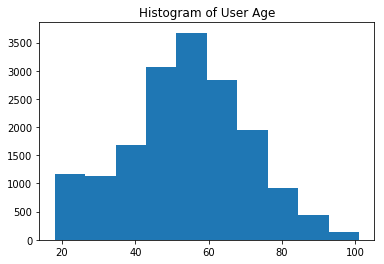

In [119]:
#plotting age
plt.hist(user_demographic.age)
plt.title('Histogram of User Age')
plt.show();

Most users are on the age range of 40 - 80. This result is somewhat consistent with the findings from [numerator](http://snapshot.numerator.com/brand/starbucks) website. However, the major difference is that Numerator found most users of Starbucks to be at the age of 25-34. The rest of the bucket is similar.

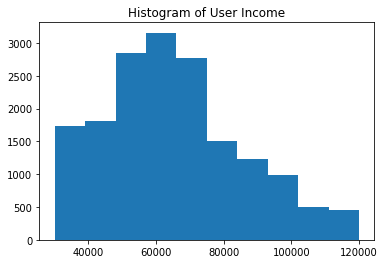

In [392]:
plt.hist(user_demographic.income)
plt.title('Histogram of User Income')
plt.show();

The income of most users is between 50000 - 78000. This makes sense, since a lot of people from the USA is from the lower-middle class with the income between 35000 to 75000 according to [wikipedia](https://en.wikipedia.org/wiki/Household_income_in_the_United_States).

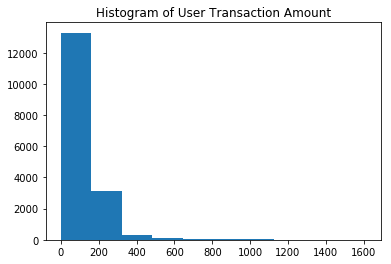

In [393]:
plt.hist(user_demographic.transaction_amount)
plt.title('Histogram of User Transaction Amount')
plt.show();

The amount of transaction for most users is between USD 0 - 200. It would be interesting to see whether users who joined earlier spend more or not.

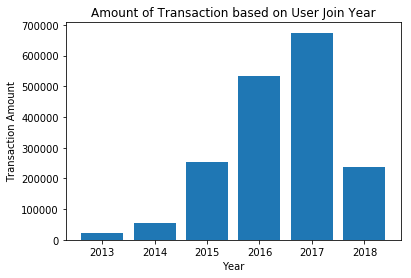

In [136]:
profile['user_id'] = id_mapper(profile)
user_demographic['became_member_on'] = profile['became_member_on']
user_demographic['join_year'] = user_demographic.became_member_on.apply(lambda x: int(str(x)[:4]))
transaction_per_year = user_demographic.groupby('join_year', as_index = False)['transaction_amount'].agg('sum')
plt.bar(transaction_per_year.join_year, transaction_per_year.transaction_amount)
plt.title('Amount of Transaction based on User Join Year')
plt.xlabel('Year')
plt.ylabel('Transaction Amount')
plt.show();

In total, the users who joined in the earlier year spend the least. This is very interesting since they have more time to accumulate the spending. The users who joined on 2017 spend the most. Now, it will also be interesting to see the average spending of these users.

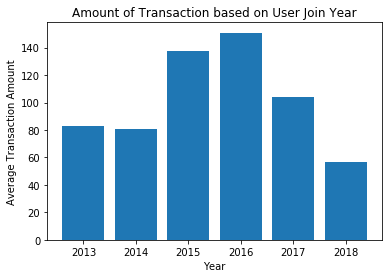

In [137]:
avg_transaction_per_year = user_demographic.groupby('join_year', as_index = False)['transaction_amount'].agg('mean')
plt.bar(avg_transaction_per_year.join_year, avg_transaction_per_year.transaction_amount)
plt.title('Amount of Transaction based on User Join Year')
plt.xlabel('Year')
plt.ylabel('Average Transaction Amount')
plt.show();

Although all users who joined on year 2013 spend the least money to purchase in Starbucks, each user spend considerably more than those who joined on the year 2018. Each user who joined on year 2016 spend the most money per purchase based on average transaction.

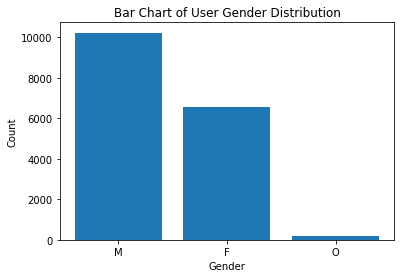

In [394]:
plt.bar(['M', 'F', 'O'],user_demographic.gender.value_counts().tolist())
plt.title('Bar Chart of User Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show();

Most of Starbucks' customers are male, followed by female customers and others. Now, it would be interesting to see which gender is affected by offer.

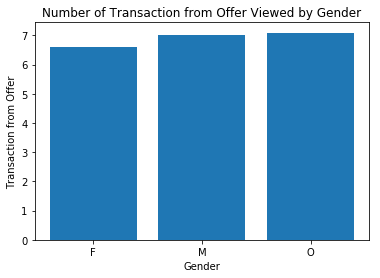

In [396]:
gender_offer = user_demographic.groupby('gender', as_index = False).agg({'transaction_from_offer': 'mean'})
plt.bar(gender_offer.gender.tolist(), gender_offer.transaction_from_offer.tolist())
plt.title('Number of Transaction from Offer Viewed by Gender')
plt.xlabel('Gender')
plt.ylabel('Transaction from Offer')
plt.show();

Surprisingly, the ones filling 'other' as their gender do transaction more after viewing an offer. Female users are the least affected by offer they view. Next, I will look at the percentage of offer completed by gender.

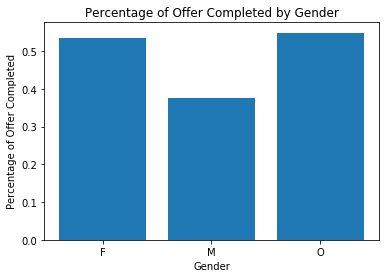

In [397]:
gender_offer_completed = user_demographic.groupby('gender', as_index = False).agg({'perc_offer_completed': 'mean'})
plt.bar(gender_offer_completed.gender.tolist(), gender_offer_completed.perc_offer_completed.tolist())
plt.title('Percentage of Offer Completed by Gender')
plt.xlabel('Gender')
plt.ylabel('Percentage of Offer Completed')
plt.show();

Again, the ones with 'other' as gender completed the most offer. Male customers, although they do more transaction, they don't really try to complete the offer.

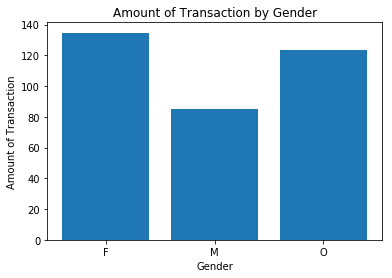

In [140]:
gender_trans_amount = user_demographic.groupby('gender', as_index = False).agg({'transaction_amount': 'mean'})
plt.bar(gender_trans_amount.gender.tolist(), gender_trans_amount.transaction_amount.tolist())
plt.title('Amount of Transaction by Gender')
plt.xlabel('Gender')
plt.ylabel('Amount of Transaction')
plt.show();

As expected, the Female users spend more. So, although they have the least number of transaction, they tend to complete the offer more than male users.

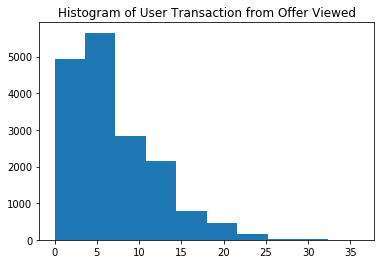

In [395]:
plt.hist(user_demographic.transaction_from_offer)
plt.title('Histogram of User Transaction from Offer Viewed')
plt.show();

In total, most customers have between 0-7 transactions after viewing the offer. This is good, since we can say that when the customers view the offer, they tend to purchase something from Starbucks.

# Clustering
After getting a fair grasp on the Starbucks' customers demographic profile, I will do a clustering using KMeans to segment the demographics into clusters.

In [144]:
user_cluster = pd.concat([user_demographic,pd.get_dummies(user_demographic.gender)], axis = 1).copy()
user_cluster.drop(['gender', 'user_id','join_year'], axis = 1, inplace = True)

### Methodology
Before doing the clustering, I will use standard scaler to scale the data. This is necessary because there are columns with really big values and those with just 0 and 1. Performing standard scaler will normalize the data. 

Then, I will do KMeans clustering and determine how many clusters I will use to predict the data using elbow method. After finding the number of cluster, I will predict the data using KMeans and get the clusters. These clusters will be appended to the dataframe.

After getting the clustering done, I will group the dataframe by clusters to identify the certain characteristics of each cluster. Then, I will describe the first 3 clusters to give a picture of what the customer segments look like.

### Implementation

In [146]:
#scale the data using standard scaler
scale = StandardScaler()
scale.fit(user_cluster)
data = scale.transform(user_cluster)
user_scaled = pd.DataFrame(data)
user_scaled.columns = user_cluster.columns
user_scaled.index = user_cluster.index
user_scaled.head()

,age,income,reward_achieved,transaction,transaction_from_offer,transaction_amount,informational1,informational2,bogo1,bogo2,...,discount3,discount4,transaction_not_from_offer,perc_offer_completed,trans_from_offer_ratio,trans_not_from_offer_ratio,became_member_on,F,M,O
0,-0.006404,0.155647,-0.183028,0.161509,0.429938,-0.667401,-0.317957,-0.419148,-0.431109,-0.437258,...,0.392164,1.735161,-0.880450,-0.117248,0.221047,-0.037628,0.272135,1.279568,-1.246168,-0.112643
1,0.054142,2.310126,-0.183028,-1.011260,-1.373751,-0.217826,-0.317957,-0.419148,-0.431109,-0.437258,...,-0.448487,-0.327858,1.122089,0.177367,-1.393856,0.042308,0.315211,1.279568,-1.246168,-0.112643
2,0.175232,-0.735185,-1.125615,-0.424876,-0.972931,-0.715844,-0.317957,0.194063,-0.431109,-0.437258,...,-0.448487,-0.327858,1.789602,-1.295709,-0.496687,0.068953,1.171327,-0.781514,0.802460,-0.112643
3,1.265048,1.722795,0.948076,-0.229414,0.029118,0.435452,-0.317957,0.194063,0.523915,-0.437258,...,-0.448487,-0.327858,-0.880450,0.913905,0.176189,-0.037628,0.297570,1.279568,-1.246168,-0.112643
4,-0.430221,-0.162448,-1.125615,-1.011260,-1.173341,-0.792481,-0.317957,-0.419148,-0.431109,-0.437258,...,-0.448487,-0.327858,0.454576,-1.295709,-1.214422,-0.016312,0.322833,1.279568,-1.246168,-0.112643


In [147]:
#fit KMeans for every k, append the SSE score to a list (scores)
scores = []
k_list = list(range(1,user_scaled.shape[1]+1))
for k in k_list:
    kmeans = KMeans(k)
    model = kmeans.fit(user_scaled)
    scores.append(np.abs(model.score(user_scaled)))

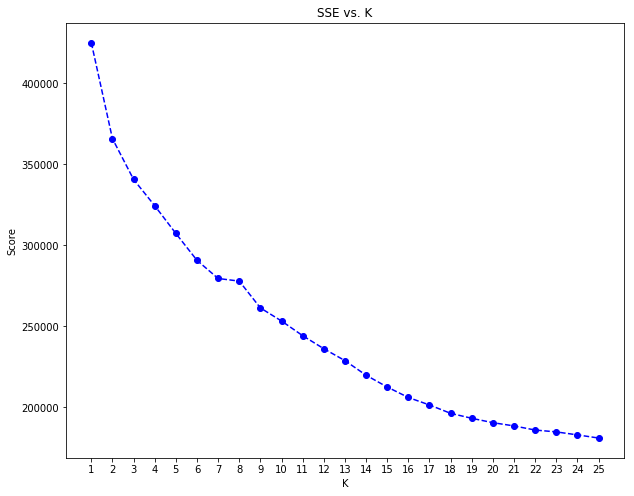

In [591]:
#plot the scores to find the elbow
plt.figure(figsize = (10,8))
plt.plot(k_list, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Score');
plt.xticks(k_list)
plt.title('SSE vs. K');

There is no clear elbow in the KMeans result, except for the slightly huge reduction of SSE from cluster 7 to 16. Therefore, I decided to go with 16 clusters.

In [148]:
#predicting clusters for each users
k_16 = KMeans(16)
cluster_list = k_16.fit_predict(user_scaled)

In [149]:
#changing values in cluster_list so it starts from 1 and ends at 16
cluster_list = cluster_list + 1

In [150]:
user_demographic['cluster'] = cluster_list
user_demographic.head(10)

,user_id,age,gender,income,reward_achieved,transaction,transaction_from_offer,transaction_amount,informational1,informational2,...,discount2,discount3,discount4,transaction_not_from_offer,perc_offer_completed,trans_from_offer_ratio,trans_not_from_offer_ratio,became_member_on,join_year,cluster
0,1,54.0,F,67980.952381,5.0,9,9,20.40,0,0,...,1,2,3,0,0.400000,1.80,0.0,20170212,2017,16
1,2,55.0,F,112000.000000,5.0,3,0,77.01,0,0,...,0,0,0,3,0.500000,0.00,1.5,20170715,2017,16
2,3,57.0,M,49780.000000,0.0,6,2,14.30,0,1,...,0,0,0,4,0.000000,1.00,2.0,20180712,2018,2
3,4,75.0,F,100000.000000,11.0,7,7,159.27,0,1,...,0,0,0,0,0.750000,1.75,0.0,20170509,2017,7
4,5,47.0,F,61481.818182,0.0,3,1,4.65,0,0,...,0,0,0,2,0.000000,0.20,0.4,20170804,2017,16
5,6,68.0,M,70000.000000,7.0,3,1,57.73,0,0,...,0,0,0,2,0.500000,0.25,0.5,20180426,2018,3
6,7,39.0,M,45300.000000,0.0,0,0,0.00,0,0,...,0,0,0,0,0.000000,0.00,0.0,20170925,2017,2
7,8,47.0,F,58918.181818,0.0,2,2,0.24,0,0,...,1,0,1,0,0.000000,0.40,0.0,20171002,2017,16
8,9,65.0,M,53000.000000,19.0,3,3,36.43,0,0,...,0,0,1,0,0.833333,0.50,0.0,20180209,2018,3
9,10,54.0,M,69650.000000,5.0,6,4,15.62,0,3,...,0,0,0,2,0.250000,1.00,0.5,20161122,2016,2


In [170]:
user_demographic.groupby('cluster')['user_id'].agg('count')

cluster
1      629
2     4330
3     2077
4      561
5      647
6      649
7     2188
8        6
9      558
10     540
11     677
12     213
13     593
14     676
15     530
16    2126
Name: user_id, dtype: int64

The number of users who belong in each cluster is different. Cluster 2 has most users and cluster 8 has the least. This might affect the quality of recommendation engine based on cluster since the clusters with a lot of users will have a lot of different preferences mixed in a cluster.

In [151]:
from scipy import stats

In [154]:
#creating a dataframe containing the column values of cluster demographic
df_cluster = user_demographic.groupby('cluster', as_index = False).agg({
    'age':'mean',
    'gender': lambda x:stats.mode(x)[0],
    'income': 'mean',
    'trans_from_offer_ratio': 'mean',
    'trans_not_from_offer_ratio': 'mean',
    'perc_offer_completed': 'mean',
    'reward_achieved': 'sum',
    'transaction_amount': 'mean',
    'transaction': 'sum',
    'bogo1': 'sum',
    'bogo2': 'sum',
    'bogo3': 'sum',
    'bogo4': 'sum',
    'discount1': 'sum',
    'discount2': 'sum',
    'discount3': 'sum',
    'discount4': 'sum',
    'informational1': 'sum',
    'informational2': 'sum',
    
})

d:\anaconda\lib\site-packages\scipy\stats\stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [155]:
df_cluster

,cluster,discount1,bogo4,income,transaction,age,trans_from_offer_ratio,discount3,informational1,bogo1,discount2,gender,trans_not_from_offer_ratio,bogo3,informational2,bogo2,perc_offer_completed,transaction_amount,discount4,reward_achieved
0,1,53,4702,58052.238131,8568,49.750397,2.661102,671,123,521,444,M,0.369687,221,302,409,0.625172,149.336407,201,6649.0
1,2,380,1885,56291.942441,19755,49.884527,0.792737,2160,724,2134,2024,M,0.334646,726,1764,2055,0.101232,21.186035,737,5768.0
2,3,462,1275,78141.624188,13052,60.120366,1.168809,1850,563,1208,1414,M,0.360592,779,841,1229,0.664396,138.931131,774,18312.0
3,4,111,418,59457.347099,7271,51.773619,2.570351,535,154,403,372,M,0.360042,3696,282,333,0.669875,160.111640,169,6331.0
4,5,76,400,54208.098001,9328,50.001546,2.880835,644,128,5422,438,M,0.443199,149,320,468,0.486656,126.762906,164,3624.0
5,6,37,420,54998.708387,10140,50.571649,3.133102,6173,119,503,531,M,0.461916,138,348,529,0.643374,154.559507,164,5028.0
6,7,403,1592,85068.621826,14984,62.817642,1.275609,2001,544,1526,1816,F,0.359682,857,916,1587,0.734407,169.907107,843,21395.0
7,8,0,0,57666.666667,20,64.000000,0.000000,0,0,0,0,F,999.000000,0,0,0,0.000000,41.768333,0,0.0
8,9,99,343,61271.382671,7093,52.860215,2.507885,523,155,390,403,M,0.328315,159,298,367,0.633094,162.853029,3624,4344.0
9,10,2994,313,64807.049255,6235,53.451852,2.356451,464,179,411,386,M,0.274198,235,231,260,0.724043,191.399741,195,6407.0


### First 3 Cluster Description
1. The first cluster is populated with Male customers with the age around 49 and the income around USD 58052. They tend to favor bogo4 over other types of offer. After receiving an offer, they do about 2-3 transactions. They also do moderate transaction not from offer received, indicating that they do like to have their coffee at Starbucks.
2. The second cluster is also populated with Male customers with the age around 49 and the income around USD 56291. They tend to favor discount3 over other types of offer. After receiving an offer, they only do about 1 transaction. However, they do purchase in Starbucks although they didn't receive any offer. I think, these customers are not really loyal. They buy coffee whenever they feel like it, and they prefer discount over anything else.
3. The third cluster is populated with Male customers with the age around 60 and income around USD 78141. They tend to favor bogo1 over other types of offer. After receiving an offer, they do about 2-3 transactions and they also buy coffee although they didn't receive offers. This cluster is similar to the first cluster, only they have higher income. 

# Recommendation based on cluster
Finally, after segmenting the customers, I will create a recommendation system based on these clusters. The things to do are as follows:
1. I have to consider which users don't like offers. Therefore, I will create a dataframe containing the user_id and transaction not from offer ratio. If the ratio is greater than the mean value, I will not recommend anything to these users.
2. Create cluster-promotion matrix.
3. Check which cluster a user belongs to.
4. Recommend top 3 offers which the cluster this user belongs to like, and get the list of these offer ids.  

If the user id is new, I will give a list of most popular offers.

In [156]:
def get_offer_id(offer_list):
    '''
    INPUT: a list of offer names (bogo1, discount1, etc)
    OUTPUT: a list of offer ids according to the portfolio dataframe
    '''
    offer_names = []
    reverse_offer_name = {v: k for k, v in offer_name_dict.items()}
    for offer in offer_list:
        offer_names.append(reverse_offer_name[offer])
    return offer_names

In [157]:
#create dataframe to check which cluster a user belongs to
check_cluster = user_demographic[['cluster', 'user_id']]

In [158]:
#create cluster - promotion matrix
recom_cluster = df_cluster[['cluster', 'discount1', 'discount2','discount3','discount4', 'bogo1','bogo2','bogo3','bogo4']]
recom_cluster = recom_cluster.set_index('cluster')

In [159]:
#create a dataframe to find out which users should not be given recommendation
offer_or_not = user_demographic[['user_id', 'trans_not_from_offer_ratio']]
offer_or_not = offer_or_not[offer_or_not['trans_not_from_offer_ratio'] > offer_or_not.trans_not_from_offer_ratio.mean()]

In [160]:
def cluster_recommendation(user_id, top_n=3):
    '''
    INPUT: 
    user_id - an id of a user
    top_n - how many recommendation will be made
    
    OUTPUT:
    The offer id of recommended offers (list)
    '''
    
    if user_id in offer_or_not['user_id'].tolist():
        return 'do not offer anything'
    else:
        #check cluster for user_id
        if user_id in check_cluster['user_id']:
            cls = check_cluster[check_cluster['user_id'] == user_id]['cluster'].tolist()[0]
            recommendation = recom_cluster.loc[cls].nlargest(top_n).index.tolist()
        else:
            recommendation = recom_cluster.stack().nlargest(top_n).index.get_level_values(level=1).tolist()
    return get_offer_id(recommendation)

In [161]:
#test for user who should be given recommendation
cluster_recommendation(293)

['fafdcd668e3743c1bb461111dcafc2a4',
 'ae264e3637204a6fb9bb56bc8210ddfd',
 '4d5c57ea9a6940dd891ad53e9dbe8da0']

In [162]:
#test for user who should not be given recommendation
cluster_recommendation(20)

'do not offer anything'

In [163]:
#test for new user
cluster_recommendation(9999999999)

['fafdcd668e3743c1bb461111dcafc2a4',
 'ae264e3637204a6fb9bb56bc8210ddfd',
 '2298d6c36e964ae4a3e7e9706d1fb8c2']

# User-based Recommendation
A cluster recommendation system is good. However, I decide to create user-based recommendation system to make it more personalized. To do this, I will do the following:
1. Create a user-promotion matrix.
2. Create a function to find similar users.
3. Check if a user id likes being given offers or not. If he/she doesn't like it, don't offer anything.
4. Find top 10 similar users and get top 3 offers they like.
5. Create recommendation based on the offers. 

In [164]:
#create user-promotion matrix
recom_user = user_demographic[['user_id', 'discount1', 'discount2','discount3','discount4', 'bogo1','bogo2','bogo3','bogo4']]
recom_user = recom_user.set_index('user_id')

In [165]:
def find_similar_users(user_id, recom_user = recom_user):
    '''
    INPUT:
    user_id - (int) a user_id
    recom_user - (pandas dataframe) matrix of users by prommotion
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first   
    '''
    
    # compute similarity of each user to the provided user
    user_row = recom_user.loc[user_id]
    similarities = np.dot(user_row.T, recom_user.T)
    # create list of just the ids
    most_similar_users = list(((-similarities).argsort()) + 1)
       
    # remove the own user's id
    most_similar_users.remove(user_id)  
    return most_similar_users # return a list of the users in order from most to least similar
    

In [166]:
def user_user_recs(user_id, recom_user = recom_user, offer_or_not = offer_or_not, n_user = 10, top_n = 3):
    '''
    INPUT:
    user_id - an id of a user
    recom_user - user-promotion matrix
    offer_or_not - a pandas dataframe consisting of user_id and trans_not_from_offer_ratio
    n_user - number of similar users we want to use to create recommendation
    top_n - number of recommendation to be given to the user_id
    
    OUTPUT:
    the offer id of recommendation (list)
    '''
    if user_id in offer_or_not['user_id'].tolist():
        return 'do not offer anything'
    else:
        if user_id in recom_user.index:
            #find top 10 similar users 
            sim_users = find_similar_users(user_id)[:n_user]
            sim_users_df = pd.DataFrame(columns = recom_user.columns)
            for user in sim_users:
                sim_users_df = sim_users_df.append(recom_user.loc[user])
            recommendation = sim_users_df.sum().nlargest(top_n).index.tolist()
        else:
            recommendation = recom_user.sum().nlargest(top_n).index.tolist()
    return get_offer_id(recommendation)

In [167]:
#test for user who should be given recommendation
user_user_recs(293)

['4d5c57ea9a6940dd891ad53e9dbe8da0',
 'fafdcd668e3743c1bb461111dcafc2a4',
 'f19421c1d4aa40978ebb69ca19b0e20d']

In [168]:
#test for user who should not be given recommendation
user_user_recs(3)

'do not offer anything'

In [169]:
#test for new user
user_user_recs(99999999999999999)

['fafdcd668e3743c1bb461111dcafc2a4',
 '2298d6c36e964ae4a3e7e9706d1fb8c2',
 'ae264e3637204a6fb9bb56bc8210ddfd']

# Evaluation and Validation
Both of the recommendation engines have successfully achieved what I want:
1. It recognizes which users should not be given offers
2. It recommends offers based on similar users / clusters' preference
3. It recommends most popular offers for new users.

Evaluating the recommendation engines is not an easy task. Starbucks has to spend certain amount of time to do A/B testing for these system. The metrics have already been mentioned in the introduction part of this notebook. However, there is a slight change on the number of group. Starbucks should have 3 groups, 1 control group and 2 experimental groups to test these recommendation engines.

### Justification
Personally, I think that the user-based recommendation engine is better than the cluster-based one. It is more personalized and versatile as we can determine how many similar users we'd like to use. Also, as I have mentioned above, the number of users in each cluster is considerably different. The maximum number is above 4000, and the minimum number is only 8. This will affect the cluster-based recommendation engine since the more users are in a cluster, the higher the variance of preference. 

# Conclusion
## Reflection
The data sets which is given is really tough, in the sense that there are just basic features in the dataset. Most of the time, businesses in hospitality industry tend to rely on ratios as metrics, so I have to create those ratios data with what these data sets. However, that wasn't really the toughest part. 

The toughest part of this project was to clean the data, especially imputing age, gender, and income. I can impute these variables using statistics such as mean for age, mode for gender, and mean / median for income. However, the result will be less accurate. When I decided to create a recommendation engine for this project, I realized that getting the most accurate data is vital, especially for the clustering part. Therefore, I decided to impute the missing / wrong values using machine learning. It was not easy for me, especially because I have to determine the order of imputation. I decided to go with the one with higher R2 score first.

After imputing the data, the process towards creating recommendation engine is not that difficult (assuming I got my logic right). However, the problem with recommendation engine is that it should be tested in real life to find out whether it's working great or not. I will need to study further to deepen my knowledge on machine learning and recommendation engine to make sure that I can build great performing models.

## Improvement
Several improvements can be made to build better recommendation engine. Some of those are:
1. Build a better random forest model to predict age, gender, and income. The R2 score is not high enough, and the MSE score is also not low enough. I can tune the hyperparameter more if I have more time, or perhaps try to use other algorithms such as Ada Boost or perhaps even neural networks.
2. Build a better recommendation engine by classifying promotion offers into star, workhorse, puzzle, and dog. I will use the menu engineering concept and implement it to classify promotion. The star promotion will be those which have low cost and high amount of transaction generated. The workhorse will be those which have high cost and high amount of transaction generated. The puzzle will be those which have low cost but low amount of transaction generated. The dog will be those which have high cost and low amount of transaction generated. By doing this, we can always promote either star or puzzle promotion and tune the workhorse promotion as well as getting rid of the dog promotion. Of course, I will need additional data to do that.